<a href="https://colab.research.google.com/github/TasfiaTahsinAnnita/CSE438/blob/main/Assignment_PART_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yt_dlp
!pip install opencv-python-headless --quiet

In [ ]:
import yt_dlp
import cv2
import numpy as np
import urllib.request
import os
from IPython.display import display, Video

# **Download Video from YouTube**

The script starts by defining a function to download a video from YouTube using the yt-dlp library. This function takes a video URL and the path where the video should be saved locally.

yt-dlp.YoutubeDL(): Initializes the downloader with options to save the video to the given path and choose the best available quality.

ydl.download([video_url]): Downloads the video from the provided URL.

In [ ]:
def download_youtube_video(video_url, output_path):
    ydl_opts = {
        'outtmpl': output_path,  # Path to save the video
        'format': 'best',  # Download the best available quality
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])

# **Check if Video Exists or Download**

Next, the script defines the YouTube video URL and checks whether the video already exists locally. If the video doesn't exist, it will be downloaded using the download_youtube_video function defined above.

VIDEO_PATH: This is the path where the video will be saved (in this case, downloaded_video.mp4).

os.path.exists(): Checks if the video already exists at the specified path. If it doesn't, the script proceeds to download the video.

In [ ]:
# YouTube video URL
video_url = "https://youtu.be/RJ60ON-GSo8?si=UcRD_5Wc9OsS00b9"  # Replace with your video URL
VIDEO_PATH = "downloaded_video.mp4"

# Check if video exists, else download it
if not os.path.exists(VIDEO_PATH):
    download_youtube_video(video_url, VIDEO_PATH)

[youtube] Extracting URL: https://youtu.be/RJ60ON-GSo8?si=UcRD_5Wc9OsS00b9
[youtube] RJ60ON-GSo8: Downloading webpage
[youtube] RJ60ON-GSo8: Downloading tv client config
[youtube] RJ60ON-GSo8: Downloading player 6e20d3a8-main
[youtube] RJ60ON-GSo8: Downloading tv player API JSON
[youtube] RJ60ON-GSo8: Downloading ios player API JSON
[youtube] RJ60ON-GSo8: Downloading m3u8 information
[info] RJ60ON-GSo8: Downloading 1 format(s): 18
[download] Destination: downloaded_video.mp4
[download] 100% of   10.39MiB in 00:00:00 at 20.51MiB/s  


# **Open Video Using OpenCV**
Once the video is downloaded (or if it already exists), the script opens the video using OpenCV's cv2.VideoCapture() method. It then retrieves the video's frame width, height, and FPS.

cv2.VideoCapture(): Opens the video file.

cap.get(): Retrieves properties like the video’s frame dimensions and frames per second (FPS).

In [ ]:
# 2. Open the downloaded video using OpenCV
cap = cv2.VideoCapture(VIDEO_PATH)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# **Initialize Video Output Writers**
The script creates two video writers using OpenCV to save processed videos:

Global Histogram Equalization (HE) Output.

CLAHE Comparison Output.

cv2.VideoWriter(): Initializes the video writers. The first argument is the output file name, the second argument defines the codec, the third argument is the FPS, and the fourth argument defines the output frame size.

In [ ]:
# 3. Initialize Video Output Writers (same as before)
out = cv2.VideoWriter('outputyt_hist_eq_grid.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps if fps > 0 else 24,
                      (frame_width * 2, frame_height * 2))

clahe_out = cv2.VideoWriter('outputyt_clahe_comparison.mp4',
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps if fps > 0 else 24,
                            (frame_width * 2, frame_height))



## **Histogram**
----
The histogram of gray level digital image with intensity values between $[0, L - 1]$ is a discrete function:

<font size="5">
$$h(r_k) = n_k$$
</font>

* $r_k$ : $k$-th intensity value
* $n_k$ : the number of pixels with $r_k$ value in the image




In [ ]:
# 4. Histogram Helper Function (same as before)
def make_histogram_panel(bgr_frame, size=(320, 240), bins=64):
    panel = np.zeros((size[1], size[0], 3), dtype=np.uint8)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([bgr_frame], [i], None, [bins], [0, 256])
        cv2.normalize(hist, hist, alpha=0, beta=size[1], norm_type=cv2.NORM_MINMAX)
        bin_width = int(size[0] / bins)
        for j in range(1, bins):
            cv2.line(panel,
                     (bin_width*(j-1), size[1] - int(hist[j-1])),
                     (bin_width*j, size[1] - int(hist[j])),
                     color=(255 if color == 'b' else 0,
                            255 if color == 'g' else 0,
                            255 if color == 'r' else 0),
                     thickness=2)
    return panel


# **RMS Contrast Function**

The Root Mean Square (RMS) contrast function calculates the contrast of a grayscale image. It is defined as the standard deviation of pixel intensities.

The Root Mean Square (RMS) Contrast is a measure of image contrast, calculated as:

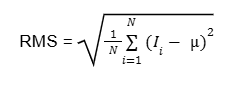

Where:

𝐼𝑖 is the pixel intensity at position
𝑖,

𝜇 is the mean pixel intensity,

𝑁 is the total number of pixels in the image.

This function calculates the square root of the average squared deviation from the mean of pixel values.

In [ ]:
# 5. RMS Contrast Function (same as before)
def rms_contrast(gray_img):
    return np.sqrt(np.mean(np.square(gray_img - np.mean(gray_img))))

# **Main Processing Loop**

The main loop processes the video frame by frame:

Global Histogram Equalization (HE): Enhances the global contrast of the image.

CLAHE (Contrast Limited Adaptive Histogram Equalization): Enhances local contrast.

Global Histogram Equalization: Uses cv2.equalizeHist() to enhance the contrast of the Y-channel (luminance) in the YCrCb color space.

CLAHE: Applies adaptive histogram equalization using cv2.createCLAHE().

# **Writing Output Videos**

After processing each frame, the script:

Creates a 2x2 grid of the original and processed frames along with their histograms.

Saves the 2x2 grid and the CLAHE comparison side by side.

np.hstack(): Stacks images horizontally.

np.vstack(): Stacks images vertically.

The resulting frames are written to the video files using out.write() and clahe_out.write().

# **Print RMS Contrast**
For each frame, the RMS contrast of the processed frames (Global HE and CLAHE) is printed to the console.

This helps to track the contrast changes between the original and processed frames.

In [ ]:
# 6. Main Processing Loop (same as before)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original = frame.copy()

    # === Global Histogram Equalisation ===
    ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    y_eq = cv2.equalizeHist(ycrcb[:, :, 0])
    ycrcb[:, :, 0] = y_eq
    he_frame = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

    # === CLAHE ===
    ycrcb_clahe = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    y_clahe = clahe.apply(ycrcb_clahe[:, :, 0])
    ycrcb_clahe[:, :, 0] = y_clahe
    clahe_frame = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)

    # === Histogram Panels ===
    hist_orig = make_histogram_panel(original, size=(frame.shape[1], frame.shape[0]))
    hist_eq = make_histogram_panel(he_frame, size=(frame.shape[1], frame.shape[0]))

    # === 2x2 Grid for global HE ===
    top_row = np.hstack((original, he_frame))
    bottom_row = np.hstack((hist_orig, hist_eq))
    grid = np.vstack((top_row, bottom_row))
    out.write(grid)

    # === 2x1 CLAHE comparison ===
    comparison = np.hstack((he_frame, clahe_frame))
    clahe_out.write(comparison)

    # === Print RMS contrast (once or as debug info) ===
    gray_he = cv2.cvtColor(he_frame, cv2.COLOR_BGR2GRAY)
    gray_clahe = cv2.cvtColor(clahe_frame, cv2.COLOR_BGR2GRAY)
    contrast_he = rms_contrast(gray_he)
    contrast_clahe = rms_contrast(gray_clahe)
    print(f"RMS Contrast – HE: {contrast_he:.2f}, CLAHE: {contrast_clahe:.2f}")



/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.36, CLAHE: 56.45
RMS Contrast – HE: 73.34, CLAHE: 56.46
RMS Contrast – HE: 73.35, CLAHE: 56.55
RMS Contrast – HE: 73.34, CLAHE: 56.62
RMS Contrast – HE: 73.37, CLAHE: 56.63
RMS Contrast – HE: 73.38, CLAHE: 56.71


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 56.73
RMS Contrast – HE: 73.40, CLAHE: 56.56
RMS Contrast – HE: 73.42, CLAHE: 56.72
RMS Contrast – HE: 73.40, CLAHE: 56.72
RMS Contrast – HE: 73.37, CLAHE: 56.62
RMS Contrast – HE: 73.37, CLAHE: 56.63
RMS Contrast – HE: 73.36, CLAHE: 56.70
RMS Contrast – HE: 73.37, CLAHE: 56.74
RMS Contrast – HE: 73.38, CLAHE: 56.66
RMS Contrast – HE: 73.36, CLAHE: 56.70
RMS Contrast – HE: 73.35, CLAHE: 56.74
RMS Contrast – HE: 73.41, CLAHE: 56.75
RMS Contrast – HE: 73.38, CLAHE: 56.76
RMS Contrast – HE: 73.36, CLAHE: 56.61
RMS Contrast – HE: 73.37, CLAHE: 56.72
RMS Contrast – HE: 73.35, CLAHE: 56.74
RMS Contrast – HE: 73.37, CLAHE: 56.62
RMS Contrast – HE: 73.40, CLAHE: 56.62
RMS Contrast – HE: 73.36, CLAHE: 56.74
RMS Contrast – HE: 73.39, CLAHE: 56.70
RMS Contrast – HE: 73.35, CLAHE: 56.68
RMS Contrast – HE: 73.36, CLAHE: 56.73
RMS Contrast – HE: 73.37, CLAHE: 56.63
RMS Contrast – HE: 73.38, CLAHE: 56.73
RMS Contrast – HE: 73.36, CLAHE: 56.65
RMS Contrast – HE: 73.36,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.36, CLAHE: 57.03
RMS Contrast – HE: 73.39, CLAHE: 57.10
RMS Contrast – HE: 73.40, CLAHE: 57.12
RMS Contrast – HE: 73.36, CLAHE: 57.19
RMS Contrast – HE: 73.34, CLAHE: 57.19
RMS Contrast – HE: 73.38, CLAHE: 57.20
RMS Contrast – HE: 73.42, CLAHE: 57.32
RMS Contrast – HE: 73.35, CLAHE: 57.43
RMS Contrast – HE: 73.34, CLAHE: 57.24
RMS Contrast – HE: 73.40, CLAHE: 57.23
RMS Contrast – HE: 73.36, CLAHE: 57.30
RMS Contrast – HE: 73.34, CLAHE: 57.21
RMS Contrast – HE: 73.35, CLAHE: 57.13
RMS Contrast – HE: 73.39, CLAHE: 57.18
RMS Contrast – HE: 73.38, CLAHE: 57.06
RMS Contrast – HE: 73.37, CLAHE: 57.04
RMS Contrast – HE: 73.35, CLAHE: 57.05
RMS Contrast – HE: 73.38, CLAHE: 57.03
RMS Contrast – HE: 73.35, CLAHE: 57.06
RMS Contrast – HE: 73.31, CLAHE: 56.94


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 56.95
RMS Contrast – HE: 73.32, CLAHE: 56.92
RMS Contrast – HE: 73.34, CLAHE: 56.87
RMS Contrast – HE: 73.30, CLAHE: 56.70
RMS Contrast – HE: 73.31, CLAHE: 56.77
RMS Contrast – HE: 73.31, CLAHE: 56.72
RMS Contrast – HE: 73.30, CLAHE: 56.71
RMS Contrast – HE: 73.31, CLAHE: 56.77
RMS Contrast – HE: 73.31, CLAHE: 56.64
RMS Contrast – HE: 73.25, CLAHE: 56.59
RMS Contrast – HE: 73.29, CLAHE: 56.70
RMS Contrast – HE: 73.32, CLAHE: 56.57
RMS Contrast – HE: 73.29, CLAHE: 56.61
RMS Contrast – HE: 73.34, CLAHE: 56.66
RMS Contrast – HE: 73.31, CLAHE: 56.59
RMS Contrast – HE: 73.30, CLAHE: 56.49
RMS Contrast – HE: 73.30, CLAHE: 56.47
RMS Contrast – HE: 73.31, CLAHE: 56.49
RMS Contrast – HE: 73.27, CLAHE: 56.45
RMS Contrast – HE: 73.25, CLAHE: 56.53
RMS Contrast – HE: 73.30, CLAHE: 56.59
RMS Contrast – HE: 73.31, CLAHE: 56.62
RMS Contrast – HE: 73.30, CLAHE: 56.59
RMS Contrast – HE: 73.31, CLAHE: 56.48
RMS Contrast – HE: 73.32, CLAHE: 56.51
RMS Contrast – HE: 73.29,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 56.38
RMS Contrast – HE: 73.35, CLAHE: 56.34
RMS Contrast – HE: 73.34, CLAHE: 56.38
RMS Contrast – HE: 73.28, CLAHE: 56.45
RMS Contrast – HE: 73.31, CLAHE: 56.40
RMS Contrast – HE: 73.33, CLAHE: 56.36
RMS Contrast – HE: 73.28, CLAHE: 56.37
RMS Contrast – HE: 73.28, CLAHE: 56.41
RMS Contrast – HE: 73.30, CLAHE: 56.38
RMS Contrast – HE: 73.31, CLAHE: 56.35
RMS Contrast – HE: 73.30, CLAHE: 56.41
RMS Contrast – HE: 73.28, CLAHE: 56.39
RMS Contrast – HE: 73.34, CLAHE: 56.40


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.31, CLAHE: 56.42
RMS Contrast – HE: 73.29, CLAHE: 56.51
RMS Contrast – HE: 73.30, CLAHE: 56.53
RMS Contrast – HE: 73.34, CLAHE: 56.61
RMS Contrast – HE: 73.30, CLAHE: 56.52
RMS Contrast – HE: 73.33, CLAHE: 56.52
RMS Contrast – HE: 73.33, CLAHE: 56.56
RMS Contrast – HE: 73.30, CLAHE: 56.63
RMS Contrast – HE: 73.31, CLAHE: 56.55


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 56.61
RMS Contrast – HE: 73.29, CLAHE: 56.49
RMS Contrast – HE: 73.27, CLAHE: 56.55
RMS Contrast – HE: 73.34, CLAHE: 56.46


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 56.41
RMS Contrast – HE: 73.34, CLAHE: 56.39
RMS Contrast – HE: 73.34, CLAHE: 56.42
RMS Contrast – HE: 73.33, CLAHE: 56.51
RMS Contrast – HE: 73.31, CLAHE: 56.49
RMS Contrast – HE: 73.32, CLAHE: 56.50
RMS Contrast – HE: 73.31, CLAHE: 56.58
RMS Contrast – HE: 73.35, CLAHE: 56.44
RMS Contrast – HE: 73.34, CLAHE: 56.55
RMS Contrast – HE: 73.33, CLAHE: 56.42
RMS Contrast – HE: 73.32, CLAHE: 56.48
RMS Contrast – HE: 73.29, CLAHE: 56.48
RMS Contrast – HE: 73.33, CLAHE: 56.48
RMS Contrast – HE: 73.33, CLAHE: 56.49
RMS Contrast – HE: 73.34, CLAHE: 56.44
RMS Contrast – HE: 73.36, CLAHE: 56.42
RMS Contrast – HE: 73.34, CLAHE: 56.45
RMS Contrast – HE: 73.34, CLAHE: 56.54
RMS Contrast – HE: 73.32, CLAHE: 56.50


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 56.36
RMS Contrast – HE: 73.32, CLAHE: 56.49
RMS Contrast – HE: 73.35, CLAHE: 56.42
RMS Contrast – HE: 73.35, CLAHE: 56.39
RMS Contrast – HE: 73.39, CLAHE: 56.45
RMS Contrast – HE: 73.33, CLAHE: 56.34
RMS Contrast – HE: 73.33, CLAHE: 56.36
RMS Contrast – HE: 73.39, CLAHE: 56.40
RMS Contrast – HE: 73.35, CLAHE: 56.34
RMS Contrast – HE: 73.36, CLAHE: 56.37
RMS Contrast – HE: 73.30, CLAHE: 56.45
RMS Contrast – HE: 73.32, CLAHE: 56.40
RMS Contrast – HE: 73.34, CLAHE: 56.43
RMS Contrast – HE: 73.36, CLAHE: 56.44
RMS Contrast – HE: 73.37, CLAHE: 56.36
RMS Contrast – HE: 73.37, CLAHE: 56.37


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.34, CLAHE: 56.51
RMS Contrast – HE: 73.36, CLAHE: 56.43
RMS Contrast – HE: 73.35, CLAHE: 56.49
RMS Contrast – HE: 73.33, CLAHE: 56.51
RMS Contrast – HE: 73.37, CLAHE: 56.40
RMS Contrast – HE: 73.36, CLAHE: 56.40
RMS Contrast – HE: 73.31, CLAHE: 56.37
RMS Contrast – HE: 73.34, CLAHE: 56.29
RMS Contrast – HE: 73.34, CLAHE: 56.37
RMS Contrast – HE: 73.34, CLAHE: 56.43


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 56.38
RMS Contrast – HE: 73.39, CLAHE: 56.39
RMS Contrast – HE: 73.34, CLAHE: 56.37
RMS Contrast – HE: 73.40, CLAHE: 56.36
RMS Contrast – HE: 73.34, CLAHE: 56.34
RMS Contrast – HE: 73.37, CLAHE: 56.37
RMS Contrast – HE: 73.35, CLAHE: 56.35
RMS Contrast – HE: 73.35, CLAHE: 56.46
RMS Contrast – HE: 73.32, CLAHE: 56.49
RMS Contrast – HE: 73.34, CLAHE: 56.48
RMS Contrast – HE: 73.34, CLAHE: 56.57
RMS Contrast – HE: 73.32, CLAHE: 56.50
RMS Contrast – HE: 73.36, CLAHE: 56.41
RMS Contrast – HE: 73.33, CLAHE: 56.43
RMS Contrast – HE: 73.34, CLAHE: 56.37
RMS Contrast – HE: 73.37, CLAHE: 56.34
RMS Contrast – HE: 73.35, CLAHE: 56.40
RMS Contrast – HE: 73.32, CLAHE: 56.36


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.38, CLAHE: 56.34
RMS Contrast – HE: 73.38, CLAHE: 56.34
RMS Contrast – HE: 73.34, CLAHE: 56.38
RMS Contrast – HE: 73.38, CLAHE: 56.31
RMS Contrast – HE: 73.38, CLAHE: 56.38
RMS Contrast – HE: 73.36, CLAHE: 56.36
RMS Contrast – HE: 73.38, CLAHE: 56.32
RMS Contrast – HE: 73.38, CLAHE: 56.38
RMS Contrast – HE: 73.38, CLAHE: 56.29
RMS Contrast – HE: 73.38, CLAHE: 56.25
RMS Contrast – HE: 73.38, CLAHE: 56.33
RMS Contrast – HE: 73.38, CLAHE: 56.26
RMS Contrast – HE: 73.37, CLAHE: 56.19
RMS Contrast – HE: 73.39, CLAHE: 56.30
RMS Contrast – HE: 73.34, CLAHE: 56.15
RMS Contrast – HE: 73.41, CLAHE: 56.15
RMS Contrast – HE: 73.39, CLAHE: 56.22
RMS Contrast – HE: 73.39, CLAHE: 56.13
RMS Contrast – HE: 73.38, CLAHE: 56.15


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 56.23
RMS Contrast – HE: 73.40, CLAHE: 56.18
RMS Contrast – HE: 73.37, CLAHE: 56.15
RMS Contrast – HE: 73.36, CLAHE: 56.22
RMS Contrast – HE: 73.36, CLAHE: 56.13
RMS Contrast – HE: 73.37, CLAHE: 56.17
RMS Contrast – HE: 73.38, CLAHE: 56.17
RMS Contrast – HE: 73.35, CLAHE: 56.19
RMS Contrast – HE: 73.33, CLAHE: 56.17
RMS Contrast – HE: 73.38, CLAHE: 56.16


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.34, CLAHE: 56.08
RMS Contrast – HE: 73.38, CLAHE: 56.12
RMS Contrast – HE: 73.37, CLAHE: 56.21
RMS Contrast – HE: 73.38, CLAHE: 56.16
RMS Contrast – HE: 73.33, CLAHE: 56.19
RMS Contrast – HE: 73.33, CLAHE: 56.22
RMS Contrast – HE: 73.38, CLAHE: 56.13
RMS Contrast – HE: 73.41, CLAHE: 56.15
RMS Contrast – HE: 73.38, CLAHE: 56.28
RMS Contrast – HE: 73.36, CLAHE: 56.20
RMS Contrast – HE: 73.41, CLAHE: 56.17
RMS Contrast – HE: 73.38, CLAHE: 56.31
RMS Contrast – HE: 73.39, CLAHE: 56.29
RMS Contrast – HE: 73.38, CLAHE: 56.22
RMS Contrast – HE: 73.41, CLAHE: 56.29
RMS Contrast – HE: 73.36, CLAHE: 56.28
RMS Contrast – HE: 73.37, CLAHE: 56.19
RMS Contrast – HE: 73.33, CLAHE: 56.22
RMS Contrast – HE: 73.40, CLAHE: 56.29
RMS Contrast – HE: 73.36, CLAHE: 56.28
RMS Contrast – HE: 73.33, CLAHE: 56.30
RMS Contrast – HE: 73.35, CLAHE: 56.26
RMS Contrast – HE: 73.34, CLAHE: 56.23
RMS Contrast – HE: 73.37, CLAHE: 56.26
RMS Contrast – HE: 73.37, CLAHE: 56.24
RMS Contrast – HE: 73.36,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.34, CLAHE: 56.25
RMS Contrast – HE: 73.34, CLAHE: 56.29
RMS Contrast – HE: 73.36, CLAHE: 56.26
RMS Contrast – HE: 73.35, CLAHE: 56.27
RMS Contrast – HE: 73.32, CLAHE: 56.38
RMS Contrast – HE: 73.35, CLAHE: 56.38
RMS Contrast – HE: 73.30, CLAHE: 56.27
RMS Contrast – HE: 73.36, CLAHE: 56.28
RMS Contrast – HE: 73.35, CLAHE: 56.31
RMS Contrast – HE: 73.33, CLAHE: 56.24
RMS Contrast – HE: 73.37, CLAHE: 56.25
RMS Contrast – HE: 73.37, CLAHE: 56.40
RMS Contrast – HE: 73.39, CLAHE: 56.33
RMS Contrast – HE: 73.37, CLAHE: 56.36
RMS Contrast – HE: 73.33, CLAHE: 56.31
RMS Contrast – HE: 73.37, CLAHE: 56.25
RMS Contrast – HE: 73.35, CLAHE: 56.39
RMS Contrast – HE: 73.33, CLAHE: 56.33
RMS Contrast – HE: 73.35, CLAHE: 56.33
RMS Contrast – HE: 73.34, CLAHE: 56.38
RMS Contrast – HE: 73.35, CLAHE: 56.34
RMS Contrast – HE: 73.37, CLAHE: 56.33
RMS Contrast – HE: 73.35, CLAHE: 56.33
RMS Contrast – HE: 73.36, CLAHE: 56.31
RMS Contrast – HE: 73.37, CLAHE: 56.34
RMS Contrast – HE: 73.33,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.34, CLAHE: 56.39
RMS Contrast – HE: 73.32, CLAHE: 56.28
RMS Contrast – HE: 73.37, CLAHE: 56.45
RMS Contrast – HE: 73.33, CLAHE: 56.48
RMS Contrast – HE: 73.35, CLAHE: 56.46
RMS Contrast – HE: 73.35, CLAHE: 56.57
RMS Contrast – HE: 73.33, CLAHE: 56.52
RMS Contrast – HE: 73.31, CLAHE: 56.56
RMS Contrast – HE: 73.30, CLAHE: 56.58
RMS Contrast – HE: 73.31, CLAHE: 56.54
RMS Contrast – HE: 73.31, CLAHE: 56.52
RMS Contrast – HE: 73.34, CLAHE: 56.58
RMS Contrast – HE: 73.33, CLAHE: 56.50
RMS Contrast – HE: 73.33, CLAHE: 56.52
RMS Contrast – HE: 73.34, CLAHE: 56.65
RMS Contrast – HE: 73.34, CLAHE: 56.54
RMS Contrast – HE: 73.34, CLAHE: 56.55
RMS Contrast – HE: 73.33, CLAHE: 56.50
RMS Contrast – HE: 73.33, CLAHE: 56.56
RMS Contrast – HE: 73.34, CLAHE: 56.46
RMS Contrast – HE: 73.30, CLAHE: 56.69
RMS Contrast – HE: 73.35, CLAHE: 56.78
RMS Contrast – HE: 73.34, CLAHE: 56.94
RMS Contrast – HE: 73.34, CLAHE: 56.97
RMS Contrast – HE: 73.31, CLAHE: 56.97
RMS Contrast – HE: 73.32,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 55.28
RMS Contrast – HE: 73.38, CLAHE: 55.44
RMS Contrast – HE: 73.37, CLAHE: 55.23
RMS Contrast – HE: 73.38, CLAHE: 55.26
RMS Contrast – HE: 73.39, CLAHE: 55.43
RMS Contrast – HE: 73.34, CLAHE: 55.43
RMS Contrast – HE: 73.36, CLAHE: 55.44
RMS Contrast – HE: 73.35, CLAHE: 55.44
RMS Contrast – HE: 73.33, CLAHE: 55.41
RMS Contrast – HE: 73.38, CLAHE: 55.42
RMS Contrast – HE: 73.36, CLAHE: 55.46
RMS Contrast – HE: 73.35, CLAHE: 55.38
RMS Contrast – HE: 73.38, CLAHE: 55.38
RMS Contrast – HE: 73.35, CLAHE: 55.39


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 55.35
RMS Contrast – HE: 73.35, CLAHE: 55.36
RMS Contrast – HE: 73.35, CLAHE: 55.33
RMS Contrast – HE: 73.36, CLAHE: 55.40
RMS Contrast – HE: 73.36, CLAHE: 55.38
RMS Contrast – HE: 73.36, CLAHE: 55.33
RMS Contrast – HE: 73.36, CLAHE: 55.40
RMS Contrast – HE: 73.35, CLAHE: 55.36
RMS Contrast – HE: 73.39, CLAHE: 55.41
RMS Contrast – HE: 73.36, CLAHE: 55.40
RMS Contrast – HE: 73.38, CLAHE: 55.38
RMS Contrast – HE: 73.36, CLAHE: 55.43
RMS Contrast – HE: 73.38, CLAHE: 55.37
RMS Contrast – HE: 73.37, CLAHE: 55.39
RMS Contrast – HE: 73.38, CLAHE: 55.41
RMS Contrast – HE: 73.39, CLAHE: 55.40
RMS Contrast – HE: 73.37, CLAHE: 55.42
RMS Contrast – HE: 73.38, CLAHE: 55.47
RMS Contrast – HE: 73.38, CLAHE: 55.42
RMS Contrast – HE: 73.35, CLAHE: 55.41
RMS Contrast – HE: 73.38, CLAHE: 55.42
RMS Contrast – HE: 73.37, CLAHE: 55.40
RMS Contrast – HE: 73.39, CLAHE: 55.44
RMS Contrast – HE: 73.38, CLAHE: 55.50
RMS Contrast – HE: 73.37, CLAHE: 55.49
RMS Contrast – HE: 73.38,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 55.66
RMS Contrast – HE: 73.35, CLAHE: 55.63
RMS Contrast – HE: 73.35, CLAHE: 55.60
RMS Contrast – HE: 73.36, CLAHE: 55.60
RMS Contrast – HE: 73.34, CLAHE: 55.57
RMS Contrast – HE: 73.38, CLAHE: 55.46
RMS Contrast – HE: 73.34, CLAHE: 55.61
RMS Contrast – HE: 73.37, CLAHE: 55.61
RMS Contrast – HE: 73.40, CLAHE: 55.62
RMS Contrast – HE: 73.33, CLAHE: 55.82
RMS Contrast – HE: 73.34, CLAHE: 55.71
RMS Contrast – HE: 73.38, CLAHE: 55.67
RMS Contrast – HE: 73.37, CLAHE: 55.70
RMS Contrast – HE: 73.38, CLAHE: 55.70
RMS Contrast – HE: 73.33, CLAHE: 55.79
RMS Contrast – HE: 73.35, CLAHE: 55.91
RMS Contrast – HE: 73.34, CLAHE: 55.82
RMS Contrast – HE: 73.35, CLAHE: 55.81
RMS Contrast – HE: 73.37, CLAHE: 55.77
RMS Contrast – HE: 73.36, CLAHE: 55.81
RMS Contrast – HE: 73.34, CLAHE: 55.88
RMS Contrast – HE: 73.37, CLAHE: 55.85
RMS Contrast – HE: 73.36, CLAHE: 55.92
RMS Contrast – HE: 73.34, CLAHE: 55.88
RMS Contrast – HE: 73.34, CLAHE: 55.83
RMS Contrast – HE: 73.35,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.38, CLAHE: 56.18
RMS Contrast – HE: 73.38, CLAHE: 56.20
RMS Contrast – HE: 73.39, CLAHE: 56.11
RMS Contrast – HE: 73.36, CLAHE: 56.18
RMS Contrast – HE: 73.34, CLAHE: 56.24
RMS Contrast – HE: 73.35, CLAHE: 56.24
RMS Contrast – HE: 73.36, CLAHE: 56.30
RMS Contrast – HE: 73.36, CLAHE: 56.30
RMS Contrast – HE: 73.38, CLAHE: 56.30
RMS Contrast – HE: 73.41, CLAHE: 56.33
RMS Contrast – HE: 73.37, CLAHE: 56.22
RMS Contrast – HE: 73.43, CLAHE: 56.30
RMS Contrast – HE: 73.38, CLAHE: 56.32
RMS Contrast – HE: 73.37, CLAHE: 56.09
RMS Contrast – HE: 73.37, CLAHE: 56.05


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 56.34
RMS Contrast – HE: 73.39, CLAHE: 56.53
RMS Contrast – HE: 73.37, CLAHE: 56.57
RMS Contrast – HE: 73.40, CLAHE: 56.53
RMS Contrast – HE: 73.34, CLAHE: 56.62
RMS Contrast – HE: 73.36, CLAHE: 56.66
RMS Contrast – HE: 73.33, CLAHE: 56.72
RMS Contrast – HE: 73.37, CLAHE: 56.76
RMS Contrast – HE: 73.33, CLAHE: 56.77
RMS Contrast – HE: 73.32, CLAHE: 56.84
RMS Contrast – HE: 73.35, CLAHE: 56.85
RMS Contrast – HE: 73.38, CLAHE: 56.81
RMS Contrast – HE: 73.35, CLAHE: 56.91
RMS Contrast – HE: 73.34, CLAHE: 56.94
RMS Contrast – HE: 73.34, CLAHE: 56.93
RMS Contrast – HE: 73.34, CLAHE: 56.94
RMS Contrast – HE: 73.38, CLAHE: 56.90
RMS Contrast – HE: 73.36, CLAHE: 56.87
RMS Contrast – HE: 73.32, CLAHE: 56.92
RMS Contrast – HE: 73.34, CLAHE: 56.91
RMS Contrast – HE: 73.34, CLAHE: 56.81
RMS Contrast – HE: 73.36, CLAHE: 56.87
RMS Contrast – HE: 73.35, CLAHE: 56.86
RMS Contrast – HE: 73.35, CLAHE: 56.90
RMS Contrast – HE: 73.38, CLAHE: 56.95
RMS Contrast – HE: 73.36,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 56.94
RMS Contrast – HE: 73.36, CLAHE: 56.94
RMS Contrast – HE: 73.39, CLAHE: 56.91
RMS Contrast – HE: 73.39, CLAHE: 56.94
RMS Contrast – HE: 73.34, CLAHE: 56.95
RMS Contrast – HE: 73.35, CLAHE: 57.03
RMS Contrast – HE: 73.35, CLAHE: 56.94
RMS Contrast – HE: 73.33, CLAHE: 57.03
RMS Contrast – HE: 73.35, CLAHE: 57.00
RMS Contrast – HE: 73.34, CLAHE: 56.92
RMS Contrast – HE: 73.35, CLAHE: 56.96
RMS Contrast – HE: 73.39, CLAHE: 56.98
RMS Contrast – HE: 73.37, CLAHE: 57.01
RMS Contrast – HE: 73.38, CLAHE: 57.13
RMS Contrast – HE: 73.31, CLAHE: 57.10
RMS Contrast – HE: 73.22, CLAHE: 57.34
RMS Contrast – HE: 73.27, CLAHE: 57.47
RMS Contrast – HE: 73.22, CLAHE: 57.48
RMS Contrast – HE: 73.16, CLAHE: 57.67
RMS Contrast – HE: 73.23, CLAHE: 57.80
RMS Contrast – HE: 73.20, CLAHE: 57.68
RMS Contrast – HE: 73.18, CLAHE: 57.63
RMS Contrast – HE: 73.21, CLAHE: 57.61
RMS Contrast – HE: 73.23, CLAHE: 57.67
RMS Contrast – HE: 73.22, CLAHE: 57.67
RMS Contrast – HE: 73.23,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 58.51
RMS Contrast – HE: 73.28, CLAHE: 58.56
RMS Contrast – HE: 73.28, CLAHE: 58.44
RMS Contrast – HE: 73.29, CLAHE: 58.47
RMS Contrast – HE: 73.28, CLAHE: 58.56
RMS Contrast – HE: 73.26, CLAHE: 58.45
RMS Contrast – HE: 73.27, CLAHE: 58.49
RMS Contrast – HE: 73.28, CLAHE: 58.41
RMS Contrast – HE: 73.26, CLAHE: 58.36
RMS Contrast – HE: 73.28, CLAHE: 58.33
RMS Contrast – HE: 73.24, CLAHE: 58.34
RMS Contrast – HE: 73.27, CLAHE: 58.26
RMS Contrast – HE: 73.25, CLAHE: 58.25
RMS Contrast – HE: 73.24, CLAHE: 58.18
RMS Contrast – HE: 73.26, CLAHE: 57.99


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 57.95
RMS Contrast – HE: 73.30, CLAHE: 57.77
RMS Contrast – HE: 73.27, CLAHE: 57.70
RMS Contrast – HE: 73.28, CLAHE: 57.64
RMS Contrast – HE: 73.26, CLAHE: 57.50
RMS Contrast – HE: 73.24, CLAHE: 57.38
RMS Contrast – HE: 73.24, CLAHE: 57.32
RMS Contrast – HE: 73.25, CLAHE: 57.23
RMS Contrast – HE: 73.26, CLAHE: 57.12
RMS Contrast – HE: 73.28, CLAHE: 57.05
RMS Contrast – HE: 73.24, CLAHE: 56.90
RMS Contrast – HE: 73.25, CLAHE: 56.88
RMS Contrast – HE: 73.27, CLAHE: 56.94
RMS Contrast – HE: 73.30, CLAHE: 56.86
RMS Contrast – HE: 73.30, CLAHE: 56.91
RMS Contrast – HE: 73.27, CLAHE: 56.86
RMS Contrast – HE: 73.28, CLAHE: 56.82
RMS Contrast – HE: 73.26, CLAHE: 56.65
RMS Contrast – HE: 73.25, CLAHE: 56.57
RMS Contrast – HE: 73.25, CLAHE: 56.69
RMS Contrast – HE: 73.25, CLAHE: 56.52
RMS Contrast – HE: 73.28, CLAHE: 56.44


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.29, CLAHE: 56.35
RMS Contrast – HE: 73.30, CLAHE: 56.30
RMS Contrast – HE: 73.29, CLAHE: 56.29
RMS Contrast – HE: 73.30, CLAHE: 56.35
RMS Contrast – HE: 73.34, CLAHE: 56.24
RMS Contrast – HE: 73.32, CLAHE: 56.27
RMS Contrast – HE: 73.26, CLAHE: 56.26
RMS Contrast – HE: 73.23, CLAHE: 56.15
RMS Contrast – HE: 73.26, CLAHE: 56.21
RMS Contrast – HE: 73.30, CLAHE: 56.22
RMS Contrast – HE: 73.26, CLAHE: 56.23
RMS Contrast – HE: 73.31, CLAHE: 56.29
RMS Contrast – HE: 73.25, CLAHE: 56.12
RMS Contrast – HE: 73.23, CLAHE: 56.06
RMS Contrast – HE: 73.24, CLAHE: 56.22
RMS Contrast – HE: 73.25, CLAHE: 56.26
RMS Contrast – HE: 73.26, CLAHE: 56.22
RMS Contrast – HE: 73.27, CLAHE: 56.37
RMS Contrast – HE: 73.27, CLAHE: 56.36
RMS Contrast – HE: 73.30, CLAHE: 56.29
RMS Contrast – HE: 73.33, CLAHE: 56.33
RMS Contrast – HE: 73.27, CLAHE: 56.36
RMS Contrast – HE: 73.32, CLAHE: 56.36
RMS Contrast – HE: 73.29, CLAHE: 56.48
RMS Contrast – HE: 73.23, CLAHE: 56.46
RMS Contrast – HE: 73.28,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 57.22
RMS Contrast – HE: 73.24, CLAHE: 57.15
RMS Contrast – HE: 73.24, CLAHE: 57.19
RMS Contrast – HE: 73.29, CLAHE: 57.29
RMS Contrast – HE: 73.28, CLAHE: 57.23
RMS Contrast – HE: 73.25, CLAHE: 57.27
RMS Contrast – HE: 73.28, CLAHE: 57.28
RMS Contrast – HE: 73.25, CLAHE: 57.31
RMS Contrast – HE: 73.27, CLAHE: 57.29
RMS Contrast – HE: 73.24, CLAHE: 57.39
RMS Contrast – HE: 73.25, CLAHE: 57.45
RMS Contrast – HE: 73.25, CLAHE: 57.43
RMS Contrast – HE: 73.22, CLAHE: 57.37
RMS Contrast – HE: 73.22, CLAHE: 57.33
RMS Contrast – HE: 73.26, CLAHE: 57.36
RMS Contrast – HE: 73.28, CLAHE: 57.39
RMS Contrast – HE: 73.29, CLAHE: 57.33
RMS Contrast – HE: 73.25, CLAHE: 57.35
RMS Contrast – HE: 73.27, CLAHE: 57.18
RMS Contrast – HE: 73.24, CLAHE: 57.22
RMS Contrast – HE: 73.26, CLAHE: 57.19
RMS Contrast – HE: 73.29, CLAHE: 57.21
RMS Contrast – HE: 73.24, CLAHE: 57.25
RMS Contrast – HE: 73.25, CLAHE: 57.21
RMS Contrast – HE: 73.24, CLAHE: 57.20
RMS Contrast – HE: 73.31,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.27, CLAHE: 57.39
RMS Contrast – HE: 73.26, CLAHE: 57.44
RMS Contrast – HE: 73.25, CLAHE: 57.42
RMS Contrast – HE: 73.28, CLAHE: 57.47
RMS Contrast – HE: 73.25, CLAHE: 57.47
RMS Contrast – HE: 73.24, CLAHE: 57.32
RMS Contrast – HE: 73.29, CLAHE: 57.32
RMS Contrast – HE: 73.30, CLAHE: 57.31
RMS Contrast – HE: 73.30, CLAHE: 57.33
RMS Contrast – HE: 73.28, CLAHE: 57.37
RMS Contrast – HE: 73.28, CLAHE: 57.32
RMS Contrast – HE: 73.24, CLAHE: 57.30
RMS Contrast – HE: 73.27, CLAHE: 57.24
RMS Contrast – HE: 73.30, CLAHE: 57.29
RMS Contrast – HE: 73.30, CLAHE: 57.38
RMS Contrast – HE: 73.25, CLAHE: 57.39


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.29, CLAHE: 57.43
RMS Contrast – HE: 73.27, CLAHE: 57.45
RMS Contrast – HE: 73.29, CLAHE: 57.45
RMS Contrast – HE: 73.29, CLAHE: 57.39
RMS Contrast – HE: 73.29, CLAHE: 57.47
RMS Contrast – HE: 73.30, CLAHE: 57.53
RMS Contrast – HE: 73.30, CLAHE: 57.55
RMS Contrast – HE: 73.30, CLAHE: 57.57
RMS Contrast – HE: 73.31, CLAHE: 57.58
RMS Contrast – HE: 73.29, CLAHE: 57.60
RMS Contrast – HE: 73.28, CLAHE: 57.65
RMS Contrast – HE: 73.30, CLAHE: 57.64
RMS Contrast – HE: 73.31, CLAHE: 57.63
RMS Contrast – HE: 73.30, CLAHE: 57.75
RMS Contrast – HE: 73.28, CLAHE: 57.86
RMS Contrast – HE: 73.29, CLAHE: 57.75
RMS Contrast – HE: 73.29, CLAHE: 57.85
RMS Contrast – HE: 73.31, CLAHE: 57.83
RMS Contrast – HE: 73.27, CLAHE: 57.94
RMS Contrast – HE: 73.27, CLAHE: 57.89
RMS Contrast – HE: 73.27, CLAHE: 57.86
RMS Contrast – HE: 73.26, CLAHE: 57.85
RMS Contrast – HE: 73.26, CLAHE: 57.83
RMS Contrast – HE: 73.27, CLAHE: 57.79
RMS Contrast – HE: 73.27, CLAHE: 57.73
RMS Contrast – HE: 73.27,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.30, CLAHE: 57.77
RMS Contrast – HE: 73.31, CLAHE: 57.72
RMS Contrast – HE: 73.31, CLAHE: 57.70
RMS Contrast – HE: 73.32, CLAHE: 57.60
RMS Contrast – HE: 73.32, CLAHE: 57.52
RMS Contrast – HE: 73.33, CLAHE: 57.53
RMS Contrast – HE: 73.30, CLAHE: 57.51
RMS Contrast – HE: 73.32, CLAHE: 57.57
RMS Contrast – HE: 73.30, CLAHE: 57.58
RMS Contrast – HE: 73.30, CLAHE: 57.57
RMS Contrast – HE: 73.30, CLAHE: 57.55
RMS Contrast – HE: 73.31, CLAHE: 57.58
RMS Contrast – HE: 73.29, CLAHE: 57.54
RMS Contrast – HE: 73.29, CLAHE: 57.57
RMS Contrast – HE: 73.32, CLAHE: 57.64
RMS Contrast – HE: 73.33, CLAHE: 57.64
RMS Contrast – HE: 73.33, CLAHE: 57.69
RMS Contrast – HE: 73.26, CLAHE: 57.74
RMS Contrast – HE: 73.28, CLAHE: 57.80
RMS Contrast – HE: 73.28, CLAHE: 57.77
RMS Contrast – HE: 73.28, CLAHE: 57.79
RMS Contrast – HE: 73.27, CLAHE: 57.80
RMS Contrast – HE: 73.28, CLAHE: 57.81
RMS Contrast – HE: 73.31, CLAHE: 57.85
RMS Contrast – HE: 73.31, CLAHE: 57.92
RMS Contrast – HE: 73.29,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 57.96
RMS Contrast – HE: 73.32, CLAHE: 57.96
RMS Contrast – HE: 73.31, CLAHE: 58.03
RMS Contrast – HE: 73.33, CLAHE: 58.02
RMS Contrast – HE: 73.31, CLAHE: 58.00
RMS Contrast – HE: 73.30, CLAHE: 58.00
RMS Contrast – HE: 73.35, CLAHE: 58.00
RMS Contrast – HE: 73.33, CLAHE: 58.01
RMS Contrast – HE: 73.31, CLAHE: 58.01
RMS Contrast – HE: 73.33, CLAHE: 57.92
RMS Contrast – HE: 73.29, CLAHE: 57.97
RMS Contrast – HE: 73.31, CLAHE: 57.91
RMS Contrast – HE: 73.34, CLAHE: 57.90
RMS Contrast – HE: 73.31, CLAHE: 57.86
RMS Contrast – HE: 73.34, CLAHE: 57.86
RMS Contrast – HE: 73.35, CLAHE: 57.86
RMS Contrast – HE: 73.33, CLAHE: 57.80
RMS Contrast – HE: 73.35, CLAHE: 57.82
RMS Contrast – HE: 73.33, CLAHE: 57.82
RMS Contrast – HE: 73.34, CLAHE: 57.84
RMS Contrast – HE: 73.34, CLAHE: 57.96
RMS Contrast – HE: 73.32, CLAHE: 57.98
RMS Contrast – HE: 73.32, CLAHE: 58.02
RMS Contrast – HE: 73.35, CLAHE: 58.00
RMS Contrast – HE: 73.34, CLAHE: 57.87
RMS Contrast – HE: 73.35,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 57.91
RMS Contrast – HE: 73.35, CLAHE: 57.90
RMS Contrast – HE: 73.37, CLAHE: 57.96
RMS Contrast – HE: 73.36, CLAHE: 57.97
RMS Contrast – HE: 73.36, CLAHE: 58.01
RMS Contrast – HE: 73.34, CLAHE: 57.91
RMS Contrast – HE: 73.33, CLAHE: 57.90
RMS Contrast – HE: 73.37, CLAHE: 57.98
RMS Contrast – HE: 73.34, CLAHE: 57.99
RMS Contrast – HE: 73.33, CLAHE: 57.96
RMS Contrast – HE: 73.36, CLAHE: 58.05
RMS Contrast – HE: 73.36, CLAHE: 57.98
RMS Contrast – HE: 73.33, CLAHE: 58.01
RMS Contrast – HE: 73.33, CLAHE: 58.04
RMS Contrast – HE: 73.36, CLAHE: 58.03
RMS Contrast – HE: 73.35, CLAHE: 58.13
RMS Contrast – HE: 73.32, CLAHE: 58.12
RMS Contrast – HE: 73.35, CLAHE: 58.09
RMS Contrast – HE: 73.32, CLAHE: 58.07
RMS Contrast – HE: 73.34, CLAHE: 58.30
RMS Contrast – HE: 73.35, CLAHE: 58.35
RMS Contrast – HE: 73.32, CLAHE: 58.37
RMS Contrast – HE: 73.32, CLAHE: 58.36
RMS Contrast – HE: 73.33, CLAHE: 58.39
RMS Contrast – HE: 73.32, CLAHE: 58.34
RMS Contrast – HE: 73.31,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 58.42
RMS Contrast – HE: 73.35, CLAHE: 58.41
RMS Contrast – HE: 73.35, CLAHE: 58.36
RMS Contrast – HE: 73.33, CLAHE: 58.49
RMS Contrast – HE: 73.33, CLAHE: 58.51
RMS Contrast – HE: 73.33, CLAHE: 58.49
RMS Contrast – HE: 73.33, CLAHE: 58.42
RMS Contrast – HE: 73.35, CLAHE: 58.43
RMS Contrast – HE: 73.35, CLAHE: 58.42
RMS Contrast – HE: 73.35, CLAHE: 58.50
RMS Contrast – HE: 73.34, CLAHE: 58.50
RMS Contrast – HE: 73.34, CLAHE: 58.52
RMS Contrast – HE: 73.35, CLAHE: 58.49
RMS Contrast – HE: 73.37, CLAHE: 58.44


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.34, CLAHE: 58.46
RMS Contrast – HE: 73.35, CLAHE: 58.47
RMS Contrast – HE: 73.38, CLAHE: 58.49
RMS Contrast – HE: 73.38, CLAHE: 58.53
RMS Contrast – HE: 73.38, CLAHE: 58.56
RMS Contrast – HE: 73.39, CLAHE: 58.49
RMS Contrast – HE: 73.36, CLAHE: 58.41
RMS Contrast – HE: 73.36, CLAHE: 58.40
RMS Contrast – HE: 73.36, CLAHE: 58.43
RMS Contrast – HE: 73.38, CLAHE: 58.41
RMS Contrast – HE: 73.33, CLAHE: 58.42
RMS Contrast – HE: 73.31, CLAHE: 58.33
RMS Contrast – HE: 73.30, CLAHE: 58.25
RMS Contrast – HE: 73.33, CLAHE: 58.24
RMS Contrast – HE: 73.38, CLAHE: 58.16
RMS Contrast – HE: 73.37, CLAHE: 58.22
RMS Contrast – HE: 73.31, CLAHE: 58.24
RMS Contrast – HE: 73.35, CLAHE: 58.19
RMS Contrast – HE: 73.35, CLAHE: 58.14
RMS Contrast – HE: 73.35, CLAHE: 58.25
RMS Contrast – HE: 73.35, CLAHE: 58.19
RMS Contrast – HE: 73.35, CLAHE: 58.28
RMS Contrast – HE: 73.29, CLAHE: 58.32
RMS Contrast – HE: 73.31, CLAHE: 58.26
RMS Contrast – HE: 73.31, CLAHE: 58.42
RMS Contrast – HE: 73.30,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.31, CLAHE: 58.36
RMS Contrast – HE: 73.33, CLAHE: 58.32
RMS Contrast – HE: 73.34, CLAHE: 58.30
RMS Contrast – HE: 73.30, CLAHE: 58.27
RMS Contrast – HE: 73.28, CLAHE: 58.21
RMS Contrast – HE: 73.30, CLAHE: 58.40
RMS Contrast – HE: 73.31, CLAHE: 58.38
RMS Contrast – HE: 73.30, CLAHE: 58.36
RMS Contrast – HE: 73.30, CLAHE: 58.37
RMS Contrast – HE: 73.32, CLAHE: 58.27
RMS Contrast – HE: 73.33, CLAHE: 58.25
RMS Contrast – HE: 73.30, CLAHE: 58.35
RMS Contrast – HE: 73.31, CLAHE: 58.28
RMS Contrast – HE: 73.30, CLAHE: 58.30
RMS Contrast – HE: 73.33, CLAHE: 58.26
RMS Contrast – HE: 73.33, CLAHE: 58.30
RMS Contrast – HE: 73.31, CLAHE: 58.26
RMS Contrast – HE: 73.30, CLAHE: 58.50
RMS Contrast – HE: 73.29, CLAHE: 58.31
RMS Contrast – HE: 73.31, CLAHE: 58.29
RMS Contrast – HE: 73.31, CLAHE: 58.31
RMS Contrast – HE: 73.31, CLAHE: 58.31
RMS Contrast – HE: 73.31, CLAHE: 58.71
RMS Contrast – HE: 73.29, CLAHE: 58.70
RMS Contrast – HE: 73.25, CLAHE: 58.59
RMS Contrast – HE: 73.31,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.30, CLAHE: 58.68
RMS Contrast – HE: 73.33, CLAHE: 58.59
RMS Contrast – HE: 73.31, CLAHE: 58.60
RMS Contrast – HE: 73.26, CLAHE: 58.68
RMS Contrast – HE: 73.30, CLAHE: 58.78
RMS Contrast – HE: 73.31, CLAHE: 58.80
RMS Contrast – HE: 73.26, CLAHE: 58.71
RMS Contrast – HE: 73.29, CLAHE: 58.74
RMS Contrast – HE: 73.28, CLAHE: 58.69
RMS Contrast – HE: 73.25, CLAHE: 58.65
RMS Contrast – HE: 73.25, CLAHE: 58.82
RMS Contrast – HE: 73.28, CLAHE: 58.85
RMS Contrast – HE: 73.31, CLAHE: 58.88
RMS Contrast – HE: 73.27, CLAHE: 58.86
RMS Contrast – HE: 73.32, CLAHE: 58.72
RMS Contrast – HE: 73.34, CLAHE: 58.66
RMS Contrast – HE: 73.30, CLAHE: 58.95
RMS Contrast – HE: 73.35, CLAHE: 58.92
RMS Contrast – HE: 73.35, CLAHE: 58.81
RMS Contrast – HE: 73.33, CLAHE: 58.90
RMS Contrast – HE: 73.34, CLAHE: 58.77
RMS Contrast – HE: 73.40, CLAHE: 58.83
RMS Contrast – HE: 73.37, CLAHE: 58.75
RMS Contrast – HE: 73.39, CLAHE: 58.79
RMS Contrast – HE: 73.34, CLAHE: 58.68
RMS Contrast – HE: 73.33,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.38, CLAHE: 58.53
RMS Contrast – HE: 73.36, CLAHE: 58.50
RMS Contrast – HE: 73.39, CLAHE: 58.54
RMS Contrast – HE: 73.32, CLAHE: 58.57
RMS Contrast – HE: 73.32, CLAHE: 58.39
RMS Contrast – HE: 73.34, CLAHE: 58.37
RMS Contrast – HE: 73.37, CLAHE: 58.51
RMS Contrast – HE: 73.35, CLAHE: 58.54


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 58.28
RMS Contrast – HE: 73.33, CLAHE: 58.29
RMS Contrast – HE: 73.38, CLAHE: 58.38
RMS Contrast – HE: 73.37, CLAHE: 58.39
RMS Contrast – HE: 73.35, CLAHE: 58.44
RMS Contrast – HE: 73.38, CLAHE: 58.37
RMS Contrast – HE: 73.36, CLAHE: 58.40
RMS Contrast – HE: 73.38, CLAHE: 58.38
RMS Contrast – HE: 73.40, CLAHE: 58.43
RMS Contrast – HE: 73.38, CLAHE: 58.43
RMS Contrast – HE: 73.41, CLAHE: 58.33
RMS Contrast – HE: 73.40, CLAHE: 58.23
RMS Contrast – HE: 73.38, CLAHE: 58.20
RMS Contrast – HE: 73.36, CLAHE: 58.27
RMS Contrast – HE: 73.37, CLAHE: 58.23
RMS Contrast – HE: 73.37, CLAHE: 58.27
RMS Contrast – HE: 73.36, CLAHE: 58.26
RMS Contrast – HE: 73.39, CLAHE: 58.30
RMS Contrast – HE: 73.38, CLAHE: 58.26
RMS Contrast – HE: 73.38, CLAHE: 58.22
RMS Contrast – HE: 73.43, CLAHE: 58.07
RMS Contrast – HE: 73.40, CLAHE: 58.03
RMS Contrast – HE: 73.35, CLAHE: 58.15
RMS Contrast – HE: 73.36, CLAHE: 58.13
RMS Contrast – HE: 73.36, CLAHE: 58.18
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.32, CLAHE: 58.11
RMS Contrast – HE: 73.33, CLAHE: 58.04
RMS Contrast – HE: 73.31, CLAHE: 58.17
RMS Contrast – HE: 73.34, CLAHE: 58.08
RMS Contrast – HE: 73.35, CLAHE: 58.13
RMS Contrast – HE: 73.34, CLAHE: 58.12
RMS Contrast – HE: 73.31, CLAHE: 58.09
RMS Contrast – HE: 73.34, CLAHE: 58.06
RMS Contrast – HE: 73.35, CLAHE: 58.06
RMS Contrast – HE: 73.33, CLAHE: 57.98
RMS Contrast – HE: 73.29, CLAHE: 58.09
RMS Contrast – HE: 73.31, CLAHE: 58.02
RMS Contrast – HE: 73.33, CLAHE: 58.02
RMS Contrast – HE: 73.29, CLAHE: 58.06
RMS Contrast – HE: 73.30, CLAHE: 58.08
RMS Contrast – HE: 73.34, CLAHE: 58.08
RMS Contrast – HE: 73.34, CLAHE: 57.99
RMS Contrast – HE: 73.33, CLAHE: 58.03
RMS Contrast – HE: 73.30, CLAHE: 58.01
RMS Contrast – HE: 73.31, CLAHE: 58.04
RMS Contrast – HE: 73.31, CLAHE: 57.95
RMS Contrast – HE: 73.30, CLAHE: 57.92
RMS Contrast – HE: 73.30, CLAHE: 57.92
RMS Contrast – HE: 73.32, CLAHE: 57.97
RMS Contrast – HE: 73.33, CLAHE: 57.92


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.32, CLAHE: 58.00
RMS Contrast – HE: 73.35, CLAHE: 58.06
RMS Contrast – HE: 73.32, CLAHE: 58.02
RMS Contrast – HE: 73.34, CLAHE: 57.97
RMS Contrast – HE: 73.32, CLAHE: 57.99


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.31, CLAHE: 58.03
RMS Contrast – HE: 73.32, CLAHE: 58.16
RMS Contrast – HE: 73.36, CLAHE: 58.19
RMS Contrast – HE: 73.34, CLAHE: 58.21
RMS Contrast – HE: 73.35, CLAHE: 58.20
RMS Contrast – HE: 73.33, CLAHE: 58.44
RMS Contrast – HE: 73.35, CLAHE: 58.47
RMS Contrast – HE: 73.34, CLAHE: 58.44
RMS Contrast – HE: 73.33, CLAHE: 58.45
RMS Contrast – HE: 73.36, CLAHE: 58.49
RMS Contrast – HE: 73.36, CLAHE: 58.58
RMS Contrast – HE: 73.34, CLAHE: 58.65
RMS Contrast – HE: 73.33, CLAHE: 58.60
RMS Contrast – HE: 73.37, CLAHE: 58.62
RMS Contrast – HE: 73.36, CLAHE: 58.47
RMS Contrast – HE: 73.38, CLAHE: 58.60
RMS Contrast – HE: 73.34, CLAHE: 58.70
RMS Contrast – HE: 73.35, CLAHE: 58.76
RMS Contrast – HE: 73.37, CLAHE: 58.68
RMS Contrast – HE: 73.33, CLAHE: 58.62
RMS Contrast – HE: 73.37, CLAHE: 58.61
RMS Contrast – HE: 73.35, CLAHE: 58.62
RMS Contrast – HE: 73.39, CLAHE: 58.65
RMS Contrast – HE: 73.41, CLAHE: 58.73
RMS Contrast – HE: 73.35, CLAHE: 58.65
RMS Contrast – HE: 73.36,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.34, CLAHE: 58.72
RMS Contrast – HE: 73.35, CLAHE: 58.69
RMS Contrast – HE: 73.37, CLAHE: 58.65
RMS Contrast – HE: 73.36, CLAHE: 58.77
RMS Contrast – HE: 73.34, CLAHE: 58.70
RMS Contrast – HE: 73.35, CLAHE: 58.74
RMS Contrast – HE: 73.33, CLAHE: 58.64
RMS Contrast – HE: 73.33, CLAHE: 58.44
RMS Contrast – HE: 73.30, CLAHE: 58.57
RMS Contrast – HE: 73.35, CLAHE: 58.58
RMS Contrast – HE: 73.32, CLAHE: 58.52
RMS Contrast – HE: 73.33, CLAHE: 58.47
RMS Contrast – HE: 73.33, CLAHE: 58.34
RMS Contrast – HE: 73.35, CLAHE: 58.26
RMS Contrast – HE: 73.37, CLAHE: 58.28
RMS Contrast – HE: 73.36, CLAHE: 58.14
RMS Contrast – HE: 73.36, CLAHE: 58.23
RMS Contrast – HE: 73.34, CLAHE: 58.48
RMS Contrast – HE: 73.29, CLAHE: 58.23
RMS Contrast – HE: 73.33, CLAHE: 58.14
RMS Contrast – HE: 73.33, CLAHE: 57.98
RMS Contrast – HE: 73.31, CLAHE: 58.16
RMS Contrast – HE: 73.34, CLAHE: 57.98
RMS Contrast – HE: 73.35, CLAHE: 57.95
RMS Contrast – HE: 73.35, CLAHE: 57.89
RMS Contrast – HE: 73.31,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 57.29
RMS Contrast – HE: 73.43, CLAHE: 57.38
RMS Contrast – HE: 73.40, CLAHE: 57.44
RMS Contrast – HE: 73.38, CLAHE: 57.39
RMS Contrast – HE: 73.42, CLAHE: 57.38
RMS Contrast – HE: 73.31, CLAHE: 57.59
RMS Contrast – HE: 73.38, CLAHE: 57.38
RMS Contrast – HE: 73.39, CLAHE: 57.36
RMS Contrast – HE: 73.38, CLAHE: 57.32
RMS Contrast – HE: 73.41, CLAHE: 57.28
RMS Contrast – HE: 73.41, CLAHE: 57.25
RMS Contrast – HE: 73.39, CLAHE: 57.33
RMS Contrast – HE: 73.42, CLAHE: 57.22
RMS Contrast – HE: 73.39, CLAHE: 57.22


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 57.24
RMS Contrast – HE: 73.38, CLAHE: 57.13
RMS Contrast – HE: 73.36, CLAHE: 57.20
RMS Contrast – HE: 73.38, CLAHE: 57.36
RMS Contrast – HE: 73.37, CLAHE: 57.18
RMS Contrast – HE: 73.38, CLAHE: 57.12
RMS Contrast – HE: 73.41, CLAHE: 57.34
RMS Contrast – HE: 73.41, CLAHE: 57.15
RMS Contrast – HE: 73.37, CLAHE: 57.15
RMS Contrast – HE: 73.44, CLAHE: 57.19
RMS Contrast – HE: 73.40, CLAHE: 57.06
RMS Contrast – HE: 73.39, CLAHE: 57.10
RMS Contrast – HE: 73.41, CLAHE: 57.16
RMS Contrast – HE: 73.41, CLAHE: 57.14
RMS Contrast – HE: 73.39, CLAHE: 57.09
RMS Contrast – HE: 73.39, CLAHE: 57.12
RMS Contrast – HE: 73.41, CLAHE: 57.00
RMS Contrast – HE: 73.42, CLAHE: 57.07
RMS Contrast – HE: 73.37, CLAHE: 57.15
RMS Contrast – HE: 73.42, CLAHE: 57.12
RMS Contrast – HE: 73.38, CLAHE: 57.13
RMS Contrast – HE: 73.43, CLAHE: 57.04
RMS Contrast – HE: 73.40, CLAHE: 56.99
RMS Contrast – HE: 73.39, CLAHE: 57.03
RMS Contrast – HE: 73.40, CLAHE: 57.17
RMS Contrast – HE: 73.38,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 56.96
RMS Contrast – HE: 73.32, CLAHE: 56.99
RMS Contrast – HE: 73.37, CLAHE: 56.61
RMS Contrast – HE: 73.33, CLAHE: 56.91
RMS Contrast – HE: 73.37, CLAHE: 56.82
RMS Contrast – HE: 73.35, CLAHE: 56.78
RMS Contrast – HE: 73.32, CLAHE: 56.79
RMS Contrast – HE: 73.33, CLAHE: 56.82
RMS Contrast – HE: 73.35, CLAHE: 56.72
RMS Contrast – HE: 73.34, CLAHE: 56.79
RMS Contrast – HE: 73.36, CLAHE: 56.78
RMS Contrast – HE: 73.36, CLAHE: 56.78
RMS Contrast – HE: 73.32, CLAHE: 56.82
RMS Contrast – HE: 73.30, CLAHE: 56.78
RMS Contrast – HE: 73.34, CLAHE: 56.73
RMS Contrast – HE: 73.37, CLAHE: 56.73
RMS Contrast – HE: 73.36, CLAHE: 56.66
RMS Contrast – HE: 73.37, CLAHE: 56.68
RMS Contrast – HE: 73.39, CLAHE: 56.70
RMS Contrast – HE: 73.41, CLAHE: 56.74
RMS Contrast – HE: 73.38, CLAHE: 56.67
RMS Contrast – HE: 73.38, CLAHE: 56.61
RMS Contrast – HE: 73.39, CLAHE: 56.58
RMS Contrast – HE: 73.38, CLAHE: 56.65
RMS Contrast – HE: 73.36, CLAHE: 56.72
RMS Contrast – HE: 73.35,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 56.81
RMS Contrast – HE: 73.36, CLAHE: 56.80
RMS Contrast – HE: 73.36, CLAHE: 56.85
RMS Contrast – HE: 73.37, CLAHE: 56.80
RMS Contrast – HE: 73.38, CLAHE: 56.80
RMS Contrast – HE: 73.34, CLAHE: 56.64
RMS Contrast – HE: 73.38, CLAHE: 56.84
RMS Contrast – HE: 73.35, CLAHE: 56.82
RMS Contrast – HE: 73.39, CLAHE: 56.79
RMS Contrast – HE: 73.38, CLAHE: 56.84
RMS Contrast – HE: 73.42, CLAHE: 56.79
RMS Contrast – HE: 73.34, CLAHE: 56.76
RMS Contrast – HE: 73.34, CLAHE: 56.77
RMS Contrast – HE: 73.33, CLAHE: 56.80
RMS Contrast – HE: 73.37, CLAHE: 56.82


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 56.89
RMS Contrast – HE: 73.38, CLAHE: 56.84
RMS Contrast – HE: 73.34, CLAHE: 56.84
RMS Contrast – HE: 73.37, CLAHE: 56.84
RMS Contrast – HE: 73.36, CLAHE: 56.73
RMS Contrast – HE: 73.36, CLAHE: 56.77
RMS Contrast – HE: 73.31, CLAHE: 56.85
RMS Contrast – HE: 73.33, CLAHE: 56.83
RMS Contrast – HE: 73.34, CLAHE: 56.88
RMS Contrast – HE: 73.33, CLAHE: 56.85
RMS Contrast – HE: 73.33, CLAHE: 56.77
RMS Contrast – HE: 73.34, CLAHE: 56.79
RMS Contrast – HE: 73.33, CLAHE: 56.79
RMS Contrast – HE: 73.33, CLAHE: 56.77
RMS Contrast – HE: 73.35, CLAHE: 56.79
RMS Contrast – HE: 73.33, CLAHE: 56.78
RMS Contrast – HE: 73.32, CLAHE: 56.77
RMS Contrast – HE: 73.33, CLAHE: 56.83
RMS Contrast – HE: 73.33, CLAHE: 56.78
RMS Contrast – HE: 73.32, CLAHE: 56.87
RMS Contrast – HE: 73.36, CLAHE: 56.93
RMS Contrast – HE: 73.36, CLAHE: 56.91
RMS Contrast – HE: 73.37, CLAHE: 56.89
RMS Contrast – HE: 73.34, CLAHE: 56.94
RMS Contrast – HE: 73.32, CLAHE: 56.92
RMS Contrast – HE: 73.32,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.44, CLAHE: 56.87
RMS Contrast – HE: 73.42, CLAHE: 57.10
RMS Contrast – HE: 73.38, CLAHE: 57.08
RMS Contrast – HE: 73.39, CLAHE: 57.20
RMS Contrast – HE: 73.35, CLAHE: 57.21
RMS Contrast – HE: 73.38, CLAHE: 57.20
RMS Contrast – HE: 73.37, CLAHE: 57.05
RMS Contrast – HE: 73.38, CLAHE: 57.09
RMS Contrast – HE: 73.38, CLAHE: 57.04
RMS Contrast – HE: 73.38, CLAHE: 56.99
RMS Contrast – HE: 73.37, CLAHE: 57.17
RMS Contrast – HE: 73.41, CLAHE: 57.21
RMS Contrast – HE: 73.40, CLAHE: 57.07
RMS Contrast – HE: 73.37, CLAHE: 57.17
RMS Contrast – HE: 73.38, CLAHE: 57.05
RMS Contrast – HE: 73.41, CLAHE: 57.00
RMS Contrast – HE: 73.43, CLAHE: 57.04
RMS Contrast – HE: 73.42, CLAHE: 57.07
RMS Contrast – HE: 73.40, CLAHE: 57.13
RMS Contrast – HE: 73.41, CLAHE: 57.26
RMS Contrast – HE: 73.42, CLAHE: 57.15
RMS Contrast – HE: 73.39, CLAHE: 57.01
RMS Contrast – HE: 73.38, CLAHE: 57.05
RMS Contrast – HE: 73.38, CLAHE: 57.08
RMS Contrast – HE: 73.42, CLAHE: 57.13
RMS Contrast – HE: 73.42,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.47, CLAHE: 57.27
RMS Contrast – HE: 73.44, CLAHE: 57.33
RMS Contrast – HE: 73.48, CLAHE: 57.38
RMS Contrast – HE: 73.47, CLAHE: 57.43
RMS Contrast – HE: 73.45, CLAHE: 57.42
RMS Contrast – HE: 73.46, CLAHE: 57.35
RMS Contrast – HE: 73.46, CLAHE: 57.31
RMS Contrast – HE: 73.45, CLAHE: 57.35
RMS Contrast – HE: 73.43, CLAHE: 57.37
RMS Contrast – HE: 73.46, CLAHE: 57.35
RMS Contrast – HE: 73.48, CLAHE: 57.48
RMS Contrast – HE: 73.45, CLAHE: 57.46
RMS Contrast – HE: 73.46, CLAHE: 57.56
RMS Contrast – HE: 73.45, CLAHE: 57.53


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.43, CLAHE: 57.57
RMS Contrast – HE: 73.42, CLAHE: 57.52
RMS Contrast – HE: 73.41, CLAHE: 57.65
RMS Contrast – HE: 73.41, CLAHE: 57.58
RMS Contrast – HE: 73.43, CLAHE: 57.54
RMS Contrast – HE: 73.42, CLAHE: 57.45
RMS Contrast – HE: 73.42, CLAHE: 57.49
RMS Contrast – HE: 73.43, CLAHE: 57.47
RMS Contrast – HE: 73.45, CLAHE: 57.61
RMS Contrast – HE: 73.47, CLAHE: 57.56
RMS Contrast – HE: 73.41, CLAHE: 57.58
RMS Contrast – HE: 73.46, CLAHE: 57.54
RMS Contrast – HE: 73.40, CLAHE: 57.42
RMS Contrast – HE: 73.43, CLAHE: 57.52
RMS Contrast – HE: 73.42, CLAHE: 57.54
RMS Contrast – HE: 73.45, CLAHE: 57.56
RMS Contrast – HE: 73.46, CLAHE: 57.54
RMS Contrast – HE: 73.44, CLAHE: 57.56
RMS Contrast – HE: 73.43, CLAHE: 57.42
RMS Contrast – HE: 73.40, CLAHE: 57.41
RMS Contrast – HE: 73.44, CLAHE: 57.61
RMS Contrast – HE: 73.42, CLAHE: 57.63
RMS Contrast – HE: 73.46, CLAHE: 57.58
RMS Contrast – HE: 73.43, CLAHE: 57.59
RMS Contrast – HE: 73.41, CLAHE: 57.47
RMS Contrast – HE: 73.38,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.45, CLAHE: 57.57
RMS Contrast – HE: 73.41, CLAHE: 57.58
RMS Contrast – HE: 73.40, CLAHE: 57.51
RMS Contrast – HE: 73.39, CLAHE: 57.39
RMS Contrast – HE: 73.37, CLAHE: 57.55
RMS Contrast – HE: 73.42, CLAHE: 57.47
RMS Contrast – HE: 73.42, CLAHE: 57.50
RMS Contrast – HE: 73.41, CLAHE: 57.56
RMS Contrast – HE: 73.41, CLAHE: 57.38
RMS Contrast – HE: 73.42, CLAHE: 57.38
RMS Contrast – HE: 73.37, CLAHE: 57.49
RMS Contrast – HE: 73.41, CLAHE: 57.48
RMS Contrast – HE: 73.43, CLAHE: 57.53
RMS Contrast – HE: 73.39, CLAHE: 57.53
RMS Contrast – HE: 73.39, CLAHE: 57.65
RMS Contrast – HE: 73.36, CLAHE: 57.79
RMS Contrast – HE: 73.35, CLAHE: 57.90
RMS Contrast – HE: 73.38, CLAHE: 57.73
RMS Contrast – HE: 73.42, CLAHE: 57.75
RMS Contrast – HE: 73.38, CLAHE: 57.68
RMS Contrast – HE: 73.36, CLAHE: 57.55
RMS Contrast – HE: 73.40, CLAHE: 57.67
RMS Contrast – HE: 73.40, CLAHE: 57.72
RMS Contrast – HE: 73.36, CLAHE: 57.77
RMS Contrast – HE: 73.38, CLAHE: 57.65
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 57.48
RMS Contrast – HE: 73.39, CLAHE: 57.55
RMS Contrast – HE: 73.38, CLAHE: 57.43
RMS Contrast – HE: 73.39, CLAHE: 57.34
RMS Contrast – HE: 73.38, CLAHE: 57.33
RMS Contrast – HE: 73.40, CLAHE: 57.35
RMS Contrast – HE: 73.39, CLAHE: 57.44
RMS Contrast – HE: 73.40, CLAHE: 57.49
RMS Contrast – HE: 73.42, CLAHE: 57.36


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.36, CLAHE: 57.22
RMS Contrast – HE: 73.40, CLAHE: 57.20
RMS Contrast – HE: 73.42, CLAHE: 57.27
RMS Contrast – HE: 73.40, CLAHE: 57.39
RMS Contrast – HE: 73.39, CLAHE: 57.43
RMS Contrast – HE: 73.40, CLAHE: 57.27
RMS Contrast – HE: 73.38, CLAHE: 56.95
RMS Contrast – HE: 73.36, CLAHE: 56.94
RMS Contrast – HE: 73.40, CLAHE: 57.16
RMS Contrast – HE: 73.41, CLAHE: 57.18
RMS Contrast – HE: 73.39, CLAHE: 57.23
RMS Contrast – HE: 73.42, CLAHE: 57.15
RMS Contrast – HE: 73.40, CLAHE: 56.88
RMS Contrast – HE: 73.40, CLAHE: 56.92
RMS Contrast – HE: 73.40, CLAHE: 57.11
RMS Contrast – HE: 73.44, CLAHE: 57.18
RMS Contrast – HE: 73.41, CLAHE: 56.90
RMS Contrast – HE: 73.40, CLAHE: 56.88
RMS Contrast – HE: 73.41, CLAHE: 56.99
RMS Contrast – HE: 73.40, CLAHE: 57.10
RMS Contrast – HE: 73.43, CLAHE: 57.20
RMS Contrast – HE: 73.42, CLAHE: 57.13


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.41, CLAHE: 56.93
RMS Contrast – HE: 73.39, CLAHE: 57.02
RMS Contrast – HE: 73.44, CLAHE: 57.21
RMS Contrast – HE: 73.40, CLAHE: 57.26
RMS Contrast – HE: 73.41, CLAHE: 57.14
RMS Contrast – HE: 73.37, CLAHE: 56.96
RMS Contrast – HE: 73.42, CLAHE: 57.01
RMS Contrast – HE: 73.41, CLAHE: 57.10
RMS Contrast – HE: 73.42, CLAHE: 57.23
RMS Contrast – HE: 73.40, CLAHE: 57.15
RMS Contrast – HE: 73.38, CLAHE: 56.93
RMS Contrast – HE: 73.41, CLAHE: 57.01
RMS Contrast – HE: 73.43, CLAHE: 57.16
RMS Contrast – HE: 73.42, CLAHE: 57.26
RMS Contrast – HE: 73.40, CLAHE: 57.18
RMS Contrast – HE: 73.42, CLAHE: 56.90
RMS Contrast – HE: 73.39, CLAHE: 56.82
RMS Contrast – HE: 73.40, CLAHE: 57.02
RMS Contrast – HE: 73.41, CLAHE: 57.22
RMS Contrast – HE: 73.43, CLAHE: 57.27
RMS Contrast – HE: 73.41, CLAHE: 57.20
RMS Contrast – HE: 73.40, CLAHE: 57.01
RMS Contrast – HE: 73.44, CLAHE: 56.97
RMS Contrast – HE: 73.43, CLAHE: 57.20
RMS Contrast – HE: 73.43, CLAHE: 57.43
RMS Contrast – HE: 73.42,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 57.48
RMS Contrast – HE: 73.44, CLAHE: 57.75
RMS Contrast – HE: 73.45, CLAHE: 57.79
RMS Contrast – HE: 73.44, CLAHE: 57.91
RMS Contrast – HE: 73.46, CLAHE: 57.86
RMS Contrast – HE: 73.46, CLAHE: 58.06
RMS Contrast – HE: 73.42, CLAHE: 58.02
RMS Contrast – HE: 73.45, CLAHE: 57.65
RMS Contrast – HE: 73.43, CLAHE: 57.52
RMS Contrast – HE: 73.48, CLAHE: 57.68
RMS Contrast – HE: 73.44, CLAHE: 57.80
RMS Contrast – HE: 73.50, CLAHE: 57.89
RMS Contrast – HE: 73.41, CLAHE: 57.66
RMS Contrast – HE: 73.47, CLAHE: 57.53


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.44, CLAHE: 57.67
RMS Contrast – HE: 73.44, CLAHE: 57.99
RMS Contrast – HE: 73.49, CLAHE: 57.99
RMS Contrast – HE: 73.45, CLAHE: 57.89
RMS Contrast – HE: 73.46, CLAHE: 57.58
RMS Contrast – HE: 73.44, CLAHE: 57.60
RMS Contrast – HE: 73.46, CLAHE: 57.92
RMS Contrast – HE: 73.46, CLAHE: 58.03
RMS Contrast – HE: 73.42, CLAHE: 57.78
RMS Contrast – HE: 73.45, CLAHE: 57.70
RMS Contrast – HE: 73.44, CLAHE: 58.04
RMS Contrast – HE: 73.47, CLAHE: 58.11
RMS Contrast – HE: 73.45, CLAHE: 57.75
RMS Contrast – HE: 73.47, CLAHE: 57.75
RMS Contrast – HE: 73.47, CLAHE: 58.01
RMS Contrast – HE: 73.44, CLAHE: 58.16
RMS Contrast – HE: 73.45, CLAHE: 57.77
RMS Contrast – HE: 73.45, CLAHE: 57.72
RMS Contrast – HE: 73.48, CLAHE: 58.02
RMS Contrast – HE: 73.46, CLAHE: 58.13
RMS Contrast – HE: 73.45, CLAHE: 57.74
RMS Contrast – HE: 73.45, CLAHE: 57.68
RMS Contrast – HE: 73.45, CLAHE: 57.97
RMS Contrast – HE: 73.49, CLAHE: 58.13
RMS Contrast – HE: 73.41, CLAHE: 57.76
RMS Contrast – HE: 73.47,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.46, CLAHE: 57.78
RMS Contrast – HE: 73.47, CLAHE: 58.12
RMS Contrast – HE: 73.43, CLAHE: 58.24
RMS Contrast – HE: 73.42, CLAHE: 57.89
RMS Contrast – HE: 73.44, CLAHE: 57.75
RMS Contrast – HE: 73.44, CLAHE: 58.11
RMS Contrast – HE: 73.49, CLAHE: 58.22
RMS Contrast – HE: 73.42, CLAHE: 57.95
RMS Contrast – HE: 73.47, CLAHE: 57.82
RMS Contrast – HE: 73.44, CLAHE: 58.24
RMS Contrast – HE: 73.49, CLAHE: 58.37
RMS Contrast – HE: 73.42, CLAHE: 57.99
RMS Contrast – HE: 73.44, CLAHE: 57.93
RMS Contrast – HE: 73.38, CLAHE: 58.41
RMS Contrast – HE: 73.45, CLAHE: 58.49
RMS Contrast – HE: 73.44, CLAHE: 58.19
RMS Contrast – HE: 73.41, CLAHE: 58.07
RMS Contrast – HE: 73.39, CLAHE: 58.47
RMS Contrast – HE: 73.45, CLAHE: 58.63
RMS Contrast – HE: 73.40, CLAHE: 58.29
RMS Contrast – HE: 73.43, CLAHE: 58.19
RMS Contrast – HE: 73.43, CLAHE: 58.60
RMS Contrast – HE: 73.50, CLAHE: 58.69
RMS Contrast – HE: 73.44, CLAHE: 58.39
RMS Contrast – HE: 73.43, CLAHE: 58.24
RMS Contrast – HE: 73.45,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.45, CLAHE: 58.33
RMS Contrast – HE: 73.39, CLAHE: 58.64
RMS Contrast – HE: 73.49, CLAHE: 58.82
RMS Contrast – HE: 73.41, CLAHE: 58.46
RMS Contrast – HE: 73.44, CLAHE: 58.25
RMS Contrast – HE: 73.45, CLAHE: 58.62


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.48, CLAHE: 58.78
RMS Contrast – HE: 73.40, CLAHE: 58.48
RMS Contrast – HE: 73.43, CLAHE: 58.20
RMS Contrast – HE: 73.44, CLAHE: 58.40
RMS Contrast – HE: 73.42, CLAHE: 58.55
RMS Contrast – HE: 73.45, CLAHE: 58.75
RMS Contrast – HE: 73.46, CLAHE: 58.30
RMS Contrast – HE: 73.44, CLAHE: 58.13
RMS Contrast – HE: 73.44, CLAHE: 58.56
RMS Contrast – HE: 73.46, CLAHE: 58.65
RMS Contrast – HE: 73.44, CLAHE: 58.18
RMS Contrast – HE: 73.44, CLAHE: 58.15
RMS Contrast – HE: 73.44, CLAHE: 58.39
RMS Contrast – HE: 73.42, CLAHE: 58.47
RMS Contrast – HE: 73.38, CLAHE: 58.11
RMS Contrast – HE: 73.44, CLAHE: 58.05
RMS Contrast – HE: 73.43, CLAHE: 58.23
RMS Contrast – HE: 73.41, CLAHE: 58.43
RMS Contrast – HE: 73.41, CLAHE: 57.92
RMS Contrast – HE: 73.43, CLAHE: 57.89
RMS Contrast – HE: 73.41, CLAHE: 58.22
RMS Contrast – HE: 73.44, CLAHE: 58.35
RMS Contrast – HE: 73.40, CLAHE: 57.89
RMS Contrast – HE: 73.41, CLAHE: 57.79
RMS Contrast – HE: 73.39, CLAHE: 58.07
RMS Contrast – HE: 73.42,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.70
RMS Contrast – HE: 73.37, CLAHE: 57.62
RMS Contrast – HE: 73.42, CLAHE: 57.96
RMS Contrast – HE: 73.35, CLAHE: 58.04
RMS Contrast – HE: 73.34, CLAHE: 57.66
RMS Contrast – HE: 73.38, CLAHE: 57.57
RMS Contrast – HE: 73.37, CLAHE: 57.84
RMS Contrast – HE: 73.41, CLAHE: 57.96
RMS Contrast – HE: 73.37, CLAHE: 57.55
RMS Contrast – HE: 73.42, CLAHE: 57.36
RMS Contrast – HE: 73.39, CLAHE: 57.75
RMS Contrast – HE: 73.37, CLAHE: 57.85
RMS Contrast – HE: 73.39, CLAHE: 57.40
RMS Contrast – HE: 73.41, CLAHE: 57.70
RMS Contrast – HE: 73.37, CLAHE: 57.83
RMS Contrast – HE: 73.42, CLAHE: 58.17
RMS Contrast – HE: 73.35, CLAHE: 58.08
RMS Contrast – HE: 73.39, CLAHE: 57.55
RMS Contrast – HE: 73.37, CLAHE: 57.60
RMS Contrast – HE: 73.42, CLAHE: 58.04
RMS Contrast – HE: 73.38, CLAHE: 58.15
RMS Contrast – HE: 73.38, CLAHE: 57.72
RMS Contrast – HE: 73.38, CLAHE: 57.63
RMS Contrast – HE: 73.39, CLAHE: 57.58
RMS Contrast – HE: 73.38, CLAHE: 58.04
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 57.70
RMS Contrast – HE: 73.39, CLAHE: 58.13
RMS Contrast – HE: 73.41, CLAHE: 58.19
RMS Contrast – HE: 73.38, CLAHE: 57.80
RMS Contrast – HE: 73.41, CLAHE: 57.74
RMS Contrast – HE: 73.40, CLAHE: 58.11
RMS Contrast – HE: 73.40, CLAHE: 58.21
RMS Contrast – HE: 73.40, CLAHE: 57.84
RMS Contrast – HE: 73.37, CLAHE: 57.70
RMS Contrast – HE: 73.38, CLAHE: 58.07
RMS Contrast – HE: 73.42, CLAHE: 58.28
RMS Contrast – HE: 73.38, CLAHE: 57.91
RMS Contrast – HE: 73.40, CLAHE: 57.78
RMS Contrast – HE: 73.39, CLAHE: 58.17


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.38, CLAHE: 58.31
RMS Contrast – HE: 73.39, CLAHE: 57.84
RMS Contrast – HE: 73.37, CLAHE: 57.71
RMS Contrast – HE: 73.36, CLAHE: 58.18
RMS Contrast – HE: 73.37, CLAHE: 58.21
RMS Contrast – HE: 73.38, CLAHE: 57.90
RMS Contrast – HE: 73.35, CLAHE: 57.82
RMS Contrast – HE: 73.38, CLAHE: 58.27
RMS Contrast – HE: 73.40, CLAHE: 58.39
RMS Contrast – HE: 73.38, CLAHE: 58.01
RMS Contrast – HE: 73.38, CLAHE: 57.91
RMS Contrast – HE: 73.37, CLAHE: 58.29
RMS Contrast – HE: 73.43, CLAHE: 58.41
RMS Contrast – HE: 73.40, CLAHE: 57.94
RMS Contrast – HE: 73.34, CLAHE: 57.78
RMS Contrast – HE: 73.36, CLAHE: 58.22
RMS Contrast – HE: 73.39, CLAHE: 58.33
RMS Contrast – HE: 73.42, CLAHE: 58.01
RMS Contrast – HE: 73.40, CLAHE: 57.94
RMS Contrast – HE: 73.37, CLAHE: 58.39
RMS Contrast – HE: 73.42, CLAHE: 58.53
RMS Contrast – HE: 73.39, CLAHE: 58.14
RMS Contrast – HE: 73.38, CLAHE: 57.91
RMS Contrast – HE: 73.39, CLAHE: 58.25
RMS Contrast – HE: 73.42, CLAHE: 58.37
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 58.14
RMS Contrast – HE: 73.41, CLAHE: 57.70
RMS Contrast – HE: 73.37, CLAHE: 57.55
RMS Contrast – HE: 73.38, CLAHE: 58.01
RMS Contrast – HE: 73.39, CLAHE: 58.10
RMS Contrast – HE: 73.38, CLAHE: 57.65
RMS Contrast – HE: 73.39, CLAHE: 57.52
RMS Contrast – HE: 73.35, CLAHE: 57.90
RMS Contrast – HE: 73.41, CLAHE: 58.06
RMS Contrast – HE: 73.35, CLAHE: 57.57
RMS Contrast – HE: 73.42, CLAHE: 57.45
RMS Contrast – HE: 73.39, CLAHE: 57.92
RMS Contrast – HE: 73.38, CLAHE: 58.03
RMS Contrast – HE: 73.40, CLAHE: 57.60
RMS Contrast – HE: 73.36, CLAHE: 57.42
RMS Contrast – HE: 73.41, CLAHE: 57.92
RMS Contrast – HE: 73.37, CLAHE: 57.99
RMS Contrast – HE: 73.38, CLAHE: 57.50
RMS Contrast – HE: 73.37, CLAHE: 57.38
RMS Contrast – HE: 73.40, CLAHE: 57.85
RMS Contrast – HE: 73.36, CLAHE: 57.95
RMS Contrast – HE: 73.36, CLAHE: 57.51
RMS Contrast – HE: 73.37, CLAHE: 57.29
RMS Contrast – HE: 73.39, CLAHE: 57.87
RMS Contrast – HE: 73.36, CLAHE: 58.02
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 57.88
RMS Contrast – HE: 73.38, CLAHE: 57.99
RMS Contrast – HE: 73.40, CLAHE: 57.55
RMS Contrast – HE: 73.36, CLAHE: 57.44
RMS Contrast – HE: 73.37, CLAHE: 57.82
RMS Contrast – HE: 73.41, CLAHE: 57.95
RMS Contrast – HE: 73.34, CLAHE: 57.42
RMS Contrast – HE: 73.33, CLAHE: 57.47
RMS Contrast – HE: 73.36, CLAHE: 57.79
RMS Contrast – HE: 73.40, CLAHE: 57.87
RMS Contrast – HE: 73.37, CLAHE: 57.43
RMS Contrast – HE: 73.38, CLAHE: 57.26
RMS Contrast – HE: 73.37, CLAHE: 57.68
RMS Contrast – HE: 73.34, CLAHE: 57.78
RMS Contrast – HE: 73.36, CLAHE: 57.35
RMS Contrast – HE: 73.39, CLAHE: 57.19
RMS Contrast – HE: 73.42, CLAHE: 57.65
RMS Contrast – HE: 73.41, CLAHE: 57.67
RMS Contrast – HE: 73.37, CLAHE: 57.29


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 57.18
RMS Contrast – HE: 73.41, CLAHE: 57.71
RMS Contrast – HE: 73.37, CLAHE: 57.80
RMS Contrast – HE: 73.38, CLAHE: 58.37
RMS Contrast – HE: 73.39, CLAHE: 58.22
RMS Contrast – HE: 73.37, CLAHE: 57.78
RMS Contrast – HE: 73.37, CLAHE: 58.15
RMS Contrast – HE: 73.38, CLAHE: 58.21
RMS Contrast – HE: 73.37, CLAHE: 57.63
RMS Contrast – HE: 73.38, CLAHE: 57.65
RMS Contrast – HE: 73.36, CLAHE: 58.06
RMS Contrast – HE: 73.44, CLAHE: 58.20
RMS Contrast – HE: 73.38, CLAHE: 57.94
RMS Contrast – HE: 73.37, CLAHE: 57.64
RMS Contrast – HE: 73.36, CLAHE: 58.08
RMS Contrast – HE: 73.41, CLAHE: 58.19
RMS Contrast – HE: 73.37, CLAHE: 57.67
RMS Contrast – HE: 73.35, CLAHE: 57.56
RMS Contrast – HE: 73.40, CLAHE: 57.98
RMS Contrast – HE: 73.40, CLAHE: 58.14


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 57.77
RMS Contrast – HE: 73.36, CLAHE: 57.57
RMS Contrast – HE: 73.35, CLAHE: 58.12
RMS Contrast – HE: 73.43, CLAHE: 58.27
RMS Contrast – HE: 73.37, CLAHE: 57.94
RMS Contrast – HE: 73.38, CLAHE: 57.85
RMS Contrast – HE: 73.38, CLAHE: 58.30
RMS Contrast – HE: 73.39, CLAHE: 58.34
RMS Contrast – HE: 73.38, CLAHE: 57.96
RMS Contrast – HE: 73.34, CLAHE: 57.83
RMS Contrast – HE: 73.41, CLAHE: 58.13
RMS Contrast – HE: 73.38, CLAHE: 58.29
RMS Contrast – HE: 73.37, CLAHE: 57.94
RMS Contrast – HE: 73.35, CLAHE: 57.87


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.36, CLAHE: 58.28
RMS Contrast – HE: 73.36, CLAHE: 58.37
RMS Contrast – HE: 73.39, CLAHE: 58.09
RMS Contrast – HE: 73.35, CLAHE: 57.89
RMS Contrast – HE: 73.39, CLAHE: 58.33
RMS Contrast – HE: 73.38, CLAHE: 58.49
RMS Contrast – HE: 73.41, CLAHE: 58.04
RMS Contrast – HE: 73.36, CLAHE: 58.05
RMS Contrast – HE: 73.39, CLAHE: 58.57
RMS Contrast – HE: 73.39, CLAHE: 58.69
RMS Contrast – HE: 73.35, CLAHE: 58.15
RMS Contrast – HE: 73.32, CLAHE: 58.11
RMS Contrast – HE: 73.35, CLAHE: 58.68
RMS Contrast – HE: 73.40, CLAHE: 58.87
RMS Contrast – HE: 73.37, CLAHE: 58.43
RMS Contrast – HE: 73.39, CLAHE: 58.29
RMS Contrast – HE: 73.39, CLAHE: 58.66
RMS Contrast – HE: 73.37, CLAHE: 58.76
RMS Contrast – HE: 73.37, CLAHE: 58.21
RMS Contrast – HE: 73.37, CLAHE: 58.11
RMS Contrast – HE: 73.37, CLAHE: 58.57
RMS Contrast – HE: 73.38, CLAHE: 58.74
RMS Contrast – HE: 73.37, CLAHE: 58.45
RMS Contrast – HE: 73.35, CLAHE: 58.18
RMS Contrast – HE: 73.39, CLAHE: 58.61
RMS Contrast – HE: 73.41,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 58.14
RMS Contrast – HE: 73.39, CLAHE: 58.67
RMS Contrast – HE: 73.38, CLAHE: 58.79
RMS Contrast – HE: 73.39, CLAHE: 58.57
RMS Contrast – HE: 73.36, CLAHE: 57.97
RMS Contrast – HE: 73.38, CLAHE: 58.29
RMS Contrast – HE: 73.41, CLAHE: 58.61
RMS Contrast – HE: 73.39, CLAHE: 58.77
RMS Contrast – HE: 73.38, CLAHE: 58.56
RMS Contrast – HE: 73.38, CLAHE: 58.05
RMS Contrast – HE: 73.40, CLAHE: 58.33
RMS Contrast – HE: 73.45, CLAHE: 58.58
RMS Contrast – HE: 73.43, CLAHE: 58.65
RMS Contrast – HE: 73.41, CLAHE: 58.40
RMS Contrast – HE: 73.39, CLAHE: 57.95
RMS Contrast – HE: 73.39, CLAHE: 58.22
RMS Contrast – HE: 73.43, CLAHE: 58.45
RMS Contrast – HE: 73.42, CLAHE: 58.52
RMS Contrast – HE: 73.39, CLAHE: 58.13
RMS Contrast – HE: 73.40, CLAHE: 57.97
RMS Contrast – HE: 73.40, CLAHE: 58.46
RMS Contrast – HE: 73.42, CLAHE: 58.51
RMS Contrast – HE: 73.41, CLAHE: 58.13
RMS Contrast – HE: 73.38, CLAHE: 57.88
RMS Contrast – HE: 73.40, CLAHE: 58.34
RMS Contrast – HE: 73.44,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.90
RMS Contrast – HE: 73.40, CLAHE: 57.82
RMS Contrast – HE: 73.40, CLAHE: 58.13
RMS Contrast – HE: 73.42, CLAHE: 58.29
RMS Contrast – HE: 73.37, CLAHE: 57.90
RMS Contrast – HE: 73.40, CLAHE: 57.85
RMS Contrast – HE: 73.40, CLAHE: 58.17
RMS Contrast – HE: 73.41, CLAHE: 58.33
RMS Contrast – HE: 73.37, CLAHE: 57.94
RMS Contrast – HE: 73.38, CLAHE: 57.82
RMS Contrast – HE: 73.40, CLAHE: 58.19
RMS Contrast – HE: 73.42, CLAHE: 58.30
RMS Contrast – HE: 73.41, CLAHE: 58.00
RMS Contrast – HE: 73.41, CLAHE: 57.86
RMS Contrast – HE: 73.42, CLAHE: 58.25
RMS Contrast – HE: 73.42, CLAHE: 58.33
RMS Contrast – HE: 73.42, CLAHE: 57.98
RMS Contrast – HE: 73.37, CLAHE: 57.85
RMS Contrast – HE: 73.42, CLAHE: 58.26
RMS Contrast – HE: 73.42, CLAHE: 58.36
RMS Contrast – HE: 73.40, CLAHE: 57.93
RMS Contrast – HE: 73.40, CLAHE: 57.76
RMS Contrast – HE: 73.41, CLAHE: 58.11
RMS Contrast – HE: 73.42, CLAHE: 58.21
RMS Contrast – HE: 73.41, CLAHE: 57.86
RMS Contrast – HE: 73.40,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.41, CLAHE: 58.09
RMS Contrast – HE: 73.42, CLAHE: 58.62
RMS Contrast – HE: 73.41, CLAHE: 58.70
RMS Contrast – HE: 73.40, CLAHE: 58.26
RMS Contrast – HE: 73.41, CLAHE: 58.19
RMS Contrast – HE: 73.43, CLAHE: 58.64
RMS Contrast – HE: 73.42, CLAHE: 58.78
RMS Contrast – HE: 73.37, CLAHE: 58.35
RMS Contrast – HE: 73.43, CLAHE: 58.29
RMS Contrast – HE: 73.41, CLAHE: 58.88
RMS Contrast – HE: 73.46, CLAHE: 58.99
RMS Contrast – HE: 73.42, CLAHE: 59.45
RMS Contrast – HE: 73.42, CLAHE: 59.32
RMS Contrast – HE: 73.40, CLAHE: 58.85
RMS Contrast – HE: 73.41, CLAHE: 59.24
RMS Contrast – HE: 73.41, CLAHE: 59.34
RMS Contrast – HE: 73.39, CLAHE: 58.77
RMS Contrast – HE: 73.38, CLAHE: 58.71
RMS Contrast – HE: 73.42, CLAHE: 59.15
RMS Contrast – HE: 73.43, CLAHE: 59.23
RMS Contrast – HE: 73.42, CLAHE: 58.81
RMS Contrast – HE: 73.38, CLAHE: 58.64
RMS Contrast – HE: 73.40, CLAHE: 58.98
RMS Contrast – HE: 73.43, CLAHE: 59.13
RMS Contrast – HE: 73.41, CLAHE: 58.66
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 58.98
RMS Contrast – HE: 73.43, CLAHE: 59.07
RMS Contrast – HE: 73.40, CLAHE: 58.70
RMS Contrast – HE: 73.40, CLAHE: 58.60
RMS Contrast – HE: 73.42, CLAHE: 58.99
RMS Contrast – HE: 73.40, CLAHE: 59.10
RMS Contrast – HE: 73.42, CLAHE: 59.01
RMS Contrast – HE: 73.39, CLAHE: 58.60
RMS Contrast – HE: 73.44, CLAHE: 58.86
RMS Contrast – HE: 73.39, CLAHE: 58.94
RMS Contrast – HE: 73.38, CLAHE: 58.50
RMS Contrast – HE: 73.39, CLAHE: 58.43
RMS Contrast – HE: 73.39, CLAHE: 58.79
RMS Contrast – HE: 73.42, CLAHE: 58.88


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 58.46
RMS Contrast – HE: 73.38, CLAHE: 58.32
RMS Contrast – HE: 73.42, CLAHE: 58.78
RMS Contrast – HE: 73.39, CLAHE: 58.88
RMS Contrast – HE: 73.38, CLAHE: 58.40
RMS Contrast – HE: 73.39, CLAHE: 58.34
RMS Contrast – HE: 73.39, CLAHE: 58.77
RMS Contrast – HE: 73.42, CLAHE: 58.84
RMS Contrast – HE: 73.40, CLAHE: 58.46
RMS Contrast – HE: 73.41, CLAHE: 58.41
RMS Contrast – HE: 73.39, CLAHE: 58.70
RMS Contrast – HE: 73.42, CLAHE: 58.77
RMS Contrast – HE: 73.38, CLAHE: 58.40
RMS Contrast – HE: 73.36, CLAHE: 58.18
RMS Contrast – HE: 73.40, CLAHE: 58.59
RMS Contrast – HE: 73.41, CLAHE: 58.69
RMS Contrast – HE: 73.39, CLAHE: 58.24
RMS Contrast – HE: 73.36, CLAHE: 58.13
RMS Contrast – HE: 73.40, CLAHE: 58.52
RMS Contrast – HE: 73.41, CLAHE: 58.61
RMS Contrast – HE: 73.39, CLAHE: 58.22
RMS Contrast – HE: 73.35, CLAHE: 58.15
RMS Contrast – HE: 73.38, CLAHE: 58.48
RMS Contrast – HE: 73.41, CLAHE: 58.65
RMS Contrast – HE: 73.38, CLAHE: 58.17
RMS Contrast – HE: 73.33,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.36, CLAHE: 58.55
RMS Contrast – HE: 73.35, CLAHE: 58.16
RMS Contrast – HE: 73.35, CLAHE: 58.02
RMS Contrast – HE: 73.41, CLAHE: 58.44
RMS Contrast – HE: 73.38, CLAHE: 58.60
RMS Contrast – HE: 73.36, CLAHE: 58.05
RMS Contrast – HE: 73.40, CLAHE: 57.98
RMS Contrast – HE: 73.42, CLAHE: 58.42
RMS Contrast – HE: 73.42, CLAHE: 58.54
RMS Contrast – HE: 73.39, CLAHE: 57.94
RMS Contrast – HE: 73.38, CLAHE: 58.01
RMS Contrast – HE: 73.39, CLAHE: 58.43
RMS Contrast – HE: 73.42, CLAHE: 58.52
RMS Contrast – HE: 73.39, CLAHE: 58.20
RMS Contrast – HE: 73.35, CLAHE: 58.03
RMS Contrast – HE: 73.38, CLAHE: 58.50
RMS Contrast – HE: 73.37, CLAHE: 58.61
RMS Contrast – HE: 73.32, CLAHE: 58.17
RMS Contrast – HE: 73.36, CLAHE: 58.03
RMS Contrast – HE: 73.36, CLAHE: 58.52
RMS Contrast – HE: 73.38, CLAHE: 58.58
RMS Contrast – HE: 73.38, CLAHE: 58.06
RMS Contrast – HE: 73.37, CLAHE: 58.06
RMS Contrast – HE: 73.43, CLAHE: 58.40
RMS Contrast – HE: 73.43, CLAHE: 58.49
RMS Contrast – HE: 73.42,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 58.34
RMS Contrast – HE: 73.44, CLAHE: 58.38
RMS Contrast – HE: 73.36, CLAHE: 58.03
RMS Contrast – HE: 73.40, CLAHE: 57.83
RMS Contrast – HE: 73.40, CLAHE: 58.33
RMS Contrast – HE: 73.41, CLAHE: 58.41
RMS Contrast – HE: 73.38, CLAHE: 58.00
RMS Contrast – HE: 73.33, CLAHE: 57.85
RMS Contrast – HE: 73.41, CLAHE: 58.40
RMS Contrast – HE: 73.39, CLAHE: 58.47
RMS Contrast – HE: 73.38, CLAHE: 58.01
RMS Contrast – HE: 73.38, CLAHE: 57.94
RMS Contrast – HE: 73.39, CLAHE: 58.41
RMS Contrast – HE: 73.39, CLAHE: 58.43
RMS Contrast – HE: 73.33, CLAHE: 57.97
RMS Contrast – HE: 73.37, CLAHE: 57.91
RMS Contrast – HE: 73.40, CLAHE: 58.37
RMS Contrast – HE: 73.40, CLAHE: 58.52
RMS Contrast – HE: 73.36, CLAHE: 58.07
RMS Contrast – HE: 73.37, CLAHE: 57.97
RMS Contrast – HE: 73.38, CLAHE: 58.35
RMS Contrast – HE: 73.39, CLAHE: 58.50
RMS Contrast – HE: 73.39, CLAHE: 58.16
RMS Contrast – HE: 73.36, CLAHE: 57.94
RMS Contrast – HE: 73.39, CLAHE: 58.58
RMS Contrast – HE: 73.41,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 58.14
RMS Contrast – HE: 73.40, CLAHE: 58.60
RMS Contrast – HE: 73.38, CLAHE: 58.70
RMS Contrast – HE: 73.34, CLAHE: 58.29
RMS Contrast – HE: 73.38, CLAHE: 58.19
RMS Contrast – HE: 73.41, CLAHE: 58.64
RMS Contrast – HE: 73.41, CLAHE: 58.68
RMS Contrast – HE: 73.38, CLAHE: 58.27
RMS Contrast – HE: 73.35, CLAHE: 58.12
RMS Contrast – HE: 73.41, CLAHE: 58.59
RMS Contrast – HE: 73.41, CLAHE: 58.72
RMS Contrast – HE: 73.39, CLAHE: 58.28
RMS Contrast – HE: 73.36, CLAHE: 58.23
RMS Contrast – HE: 73.39, CLAHE: 58.61
RMS Contrast – HE: 73.40, CLAHE: 58.70
RMS Contrast – HE: 73.34, CLAHE: 58.23
RMS Contrast – HE: 73.37, CLAHE: 58.14
RMS Contrast – HE: 73.40, CLAHE: 58.67
RMS Contrast – HE: 73.38, CLAHE: 58.78
RMS Contrast – HE: 73.38, CLAHE: 58.48
RMS Contrast – HE: 73.35, CLAHE: 58.04
RMS Contrast – HE: 73.36, CLAHE: 58.18
RMS Contrast – HE: 73.39, CLAHE: 58.48
RMS Contrast – HE: 73.39, CLAHE: 58.59
RMS Contrast – HE: 73.39, CLAHE: 58.67
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.27, CLAHE: 58.40
RMS Contrast – HE: 73.27, CLAHE: 58.93
RMS Contrast – HE: 73.30, CLAHE: 59.03
RMS Contrast – HE: 73.26, CLAHE: 58.57
RMS Contrast – HE: 73.23, CLAHE: 58.36
RMS Contrast – HE: 73.31, CLAHE: 58.96
RMS Contrast – HE: 73.29, CLAHE: 59.08
RMS Contrast – HE: 73.27, CLAHE: 58.67
RMS Contrast – HE: 73.24, CLAHE: 58.55
RMS Contrast – HE: 73.28, CLAHE: 59.09
RMS Contrast – HE: 73.31, CLAHE: 59.17
RMS Contrast – HE: 73.28, CLAHE: 58.64
RMS Contrast – HE: 73.23, CLAHE: 58.53
RMS Contrast – HE: 73.28, CLAHE: 59.07
RMS Contrast – HE: 73.31, CLAHE: 59.16
RMS Contrast – HE: 73.26, CLAHE: 58.71
RMS Contrast – HE: 73.27, CLAHE: 58.88
RMS Contrast – HE: 73.27, CLAHE: 59.31
RMS Contrast – HE: 73.28, CLAHE: 59.33


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.27, CLAHE: 58.90
RMS Contrast – HE: 73.24, CLAHE: 58.69
RMS Contrast – HE: 73.29, CLAHE: 59.12
RMS Contrast – HE: 73.27, CLAHE: 59.22
RMS Contrast – HE: 73.27, CLAHE: 58.70
RMS Contrast – HE: 73.26, CLAHE: 58.57
RMS Contrast – HE: 73.30, CLAHE: 59.22
RMS Contrast – HE: 73.29, CLAHE: 59.19
RMS Contrast – HE: 73.28, CLAHE: 58.74


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.29, CLAHE: 58.57
RMS Contrast – HE: 73.28, CLAHE: 59.07
RMS Contrast – HE: 73.32, CLAHE: 59.17
RMS Contrast – HE: 73.30, CLAHE: 58.68
RMS Contrast – HE: 73.27, CLAHE: 58.51
RMS Contrast – HE: 73.27, CLAHE: 58.99
RMS Contrast – HE: 73.31, CLAHE: 59.07
RMS Contrast – HE: 73.31, CLAHE: 58.67
RMS Contrast – HE: 73.28, CLAHE: 58.50
RMS Contrast – HE: 73.31, CLAHE: 58.96
RMS Contrast – HE: 73.32, CLAHE: 59.06
RMS Contrast – HE: 73.34, CLAHE: 58.71
RMS Contrast – HE: 73.28, CLAHE: 58.38
RMS Contrast – HE: 73.28, CLAHE: 58.79
RMS Contrast – HE: 73.29, CLAHE: 59.04
RMS Contrast – HE: 73.29, CLAHE: 58.57
RMS Contrast – HE: 73.31, CLAHE: 58.33
RMS Contrast – HE: 73.31, CLAHE: 58.86
RMS Contrast – HE: 73.32, CLAHE: 58.95


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.31, CLAHE: 58.42
RMS Contrast – HE: 73.28, CLAHE: 58.30
RMS Contrast – HE: 73.33, CLAHE: 58.76
RMS Contrast – HE: 73.31, CLAHE: 58.87
RMS Contrast – HE: 73.31, CLAHE: 58.35
RMS Contrast – HE: 73.31, CLAHE: 58.27
RMS Contrast – HE: 73.30, CLAHE: 58.69
RMS Contrast – HE: 73.35, CLAHE: 58.81
RMS Contrast – HE: 73.30, CLAHE: 58.37
RMS Contrast – HE: 73.30, CLAHE: 58.25
RMS Contrast – HE: 73.31, CLAHE: 58.75
RMS Contrast – HE: 73.31, CLAHE: 58.84
RMS Contrast – HE: 73.29, CLAHE: 58.32
RMS Contrast – HE: 73.25, CLAHE: 58.27
RMS Contrast – HE: 73.30, CLAHE: 58.65
RMS Contrast – HE: 73.31, CLAHE: 58.76
RMS Contrast – HE: 73.29, CLAHE: 58.35
RMS Contrast – HE: 73.28, CLAHE: 58.28
RMS Contrast – HE: 73.30, CLAHE: 58.62
RMS Contrast – HE: 73.31, CLAHE: 58.83
RMS Contrast – HE: 73.25, CLAHE: 58.42
RMS Contrast – HE: 73.29, CLAHE: 58.36
RMS Contrast – HE: 73.31, CLAHE: 58.68
RMS Contrast – HE: 73.32, CLAHE: 58.84
RMS Contrast – HE: 73.29, CLAHE: 58.64
RMS Contrast – HE: 73.28,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 59.00
RMS Contrast – HE: 73.29, CLAHE: 58.47
RMS Contrast – HE: 73.30, CLAHE: 58.45
RMS Contrast – HE: 73.31, CLAHE: 58.94
RMS Contrast – HE: 73.31, CLAHE: 59.04
RMS Contrast – HE: 73.26, CLAHE: 58.68
RMS Contrast – HE: 73.30, CLAHE: 58.39
RMS Contrast – HE: 73.29, CLAHE: 58.82
RMS Contrast – HE: 73.29, CLAHE: 58.87
RMS Contrast – HE: 73.25, CLAHE: 58.24
RMS Contrast – HE: 73.30, CLAHE: 58.10
RMS Contrast – HE: 73.28, CLAHE: 58.64
RMS Contrast – HE: 73.27, CLAHE: 58.70
RMS Contrast – HE: 73.30, CLAHE: 58.25
RMS Contrast – HE: 73.27, CLAHE: 58.05
RMS Contrast – HE: 73.31, CLAHE: 58.55
RMS Contrast – HE: 73.27, CLAHE: 58.68
RMS Contrast – HE: 73.27, CLAHE: 58.22
RMS Contrast – HE: 73.28, CLAHE: 58.11
RMS Contrast – HE: 73.27, CLAHE: 58.63
RMS Contrast – HE: 73.27, CLAHE: 58.65
RMS Contrast – HE: 73.29, CLAHE: 58.29
RMS Contrast – HE: 73.29, CLAHE: 58.14
RMS Contrast – HE: 73.26, CLAHE: 58.51
RMS Contrast – HE: 73.30, CLAHE: 58.56
RMS Contrast – HE: 73.28,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.27, CLAHE: 58.23
RMS Contrast – HE: 73.27, CLAHE: 58.01
RMS Contrast – HE: 73.28, CLAHE: 58.51
RMS Contrast – HE: 73.29, CLAHE: 58.55
RMS Contrast – HE: 73.30, CLAHE: 58.23
RMS Contrast – HE: 73.33, CLAHE: 58.46
RMS Contrast – HE: 73.36, CLAHE: 58.94
RMS Contrast – HE: 73.39, CLAHE: 58.94
RMS Contrast – HE: 73.37, CLAHE: 58.63
RMS Contrast – HE: 73.35, CLAHE: 58.58
RMS Contrast – HE: 73.38, CLAHE: 59.07
RMS Contrast – HE: 73.36, CLAHE: 59.15
RMS Contrast – HE: 73.33, CLAHE: 58.75
RMS Contrast – HE: 73.37, CLAHE: 58.99
RMS Contrast – HE: 73.38, CLAHE: 59.07
RMS Contrast – HE: 73.33, CLAHE: 59.82
RMS Contrast – HE: 73.35, CLAHE: 59.68
RMS Contrast – HE: 73.36, CLAHE: 59.19
RMS Contrast – HE: 73.39, CLAHE: 59.44
RMS Contrast – HE: 73.41, CLAHE: 59.58
RMS Contrast – HE: 73.34, CLAHE: 59.00
RMS Contrast – HE: 73.37, CLAHE: 59.08
RMS Contrast – HE: 73.36, CLAHE: 59.52
RMS Contrast – HE: 73.37, CLAHE: 59.63
RMS Contrast – HE: 73.36, CLAHE: 59.53
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 59.15
RMS Contrast – HE: 73.35, CLAHE: 59.05
RMS Contrast – HE: 73.33, CLAHE: 59.41
RMS Contrast – HE: 73.39, CLAHE: 59.56
RMS Contrast – HE: 73.38, CLAHE: 59.30
RMS Contrast – HE: 73.37, CLAHE: 58.90
RMS Contrast – HE: 73.38, CLAHE: 59.31
RMS Contrast – HE: 73.36, CLAHE: 59.47
RMS Contrast – HE: 73.37, CLAHE: 59.11
RMS Contrast – HE: 73.32, CLAHE: 59.07
RMS Contrast – HE: 73.37, CLAHE: 59.50
RMS Contrast – HE: 73.37, CLAHE: 59.56
RMS Contrast – HE: 73.39, CLAHE: 59.09
RMS Contrast – HE: 73.39, CLAHE: 59.03
RMS Contrast – HE: 73.37, CLAHE: 59.41
RMS Contrast – HE: 73.41, CLAHE: 59.44
RMS Contrast – HE: 73.37, CLAHE: 59.21
RMS Contrast – HE: 73.36, CLAHE: 59.06
RMS Contrast – HE: 73.34, CLAHE: 59.54
RMS Contrast – HE: 73.40, CLAHE: 59.71
RMS Contrast – HE: 73.33, CLAHE: 59.28
RMS Contrast – HE: 73.38, CLAHE: 59.29
RMS Contrast – HE: 73.37, CLAHE: 59.62
RMS Contrast – HE: 73.38, CLAHE: 59.67
RMS Contrast – HE: 73.34, CLAHE: 59.42
RMS Contrast – HE: 73.33,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 59.36
RMS Contrast – HE: 73.36, CLAHE: 58.97
RMS Contrast – HE: 73.35, CLAHE: 58.99
RMS Contrast – HE: 73.38, CLAHE: 59.27
RMS Contrast – HE: 73.42, CLAHE: 59.37
RMS Contrast – HE: 73.38, CLAHE: 58.96
RMS Contrast – HE: 73.34, CLAHE: 58.79
RMS Contrast – HE: 73.40, CLAHE: 59.19
RMS Contrast – HE: 73.38, CLAHE: 59.21
RMS Contrast – HE: 73.37, CLAHE: 58.82
RMS Contrast – HE: 73.40, CLAHE: 58.83
RMS Contrast – HE: 73.42, CLAHE: 59.20
RMS Contrast – HE: 73.40, CLAHE: 59.29


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.38, CLAHE: 58.86
RMS Contrast – HE: 73.34, CLAHE: 58.83
RMS Contrast – HE: 73.41, CLAHE: 59.16
RMS Contrast – HE: 73.38, CLAHE: 59.27
RMS Contrast – HE: 73.38, CLAHE: 58.82
RMS Contrast – HE: 73.37, CLAHE: 58.73
RMS Contrast – HE: 73.37, CLAHE: 59.13
RMS Contrast – HE: 73.41, CLAHE: 59.25
RMS Contrast – HE: 73.37, CLAHE: 58.82
RMS Contrast – HE: 73.36, CLAHE: 58.73
RMS Contrast – HE: 73.41, CLAHE: 58.99
RMS Contrast – HE: 73.38, CLAHE: 59.15
RMS Contrast – HE: 73.37, CLAHE: 58.70
RMS Contrast – HE: 73.34, CLAHE: 58.61
RMS Contrast – HE: 73.37, CLAHE: 59.03
RMS Contrast – HE: 73.38, CLAHE: 59.09
RMS Contrast – HE: 73.37, CLAHE: 58.65
RMS Contrast – HE: 73.38, CLAHE: 58.69
RMS Contrast – HE: 73.41, CLAHE: 59.15
RMS Contrast – HE: 73.40, CLAHE: 59.21
RMS Contrast – HE: 73.39, CLAHE: 58.76
RMS Contrast – HE: 73.36, CLAHE: 58.83
RMS Contrast – HE: 73.37, CLAHE: 58.98
RMS Contrast – HE: 73.39, CLAHE: 59.15
RMS Contrast – HE: 73.42, CLAHE: 58.81
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 59.26
RMS Contrast – HE: 73.36, CLAHE: 58.80
RMS Contrast – HE: 73.36, CLAHE: 58.60
RMS Contrast – HE: 73.39, CLAHE: 59.08
RMS Contrast – HE: 73.36, CLAHE: 59.13
RMS Contrast – HE: 73.38, CLAHE: 58.66
RMS Contrast – HE: 73.36, CLAHE: 58.50
RMS Contrast – HE: 73.40, CLAHE: 58.93
RMS Contrast – HE: 73.41, CLAHE: 59.06
RMS Contrast – HE: 73.41, CLAHE: 58.52
RMS Contrast – HE: 73.40, CLAHE: 58.42
RMS Contrast – HE: 73.43, CLAHE: 58.86
RMS Contrast – HE: 73.45, CLAHE: 58.99
RMS Contrast – HE: 73.41, CLAHE: 58.64
RMS Contrast – HE: 73.40, CLAHE: 58.44
RMS Contrast – HE: 73.44, CLAHE: 58.82
RMS Contrast – HE: 73.45, CLAHE: 59.02
RMS Contrast – HE: 73.40, CLAHE: 58.55
RMS Contrast – HE: 73.42, CLAHE: 58.59
RMS Contrast – HE: 73.41, CLAHE: 58.85
RMS Contrast – HE: 73.46, CLAHE: 58.96
RMS Contrast – HE: 73.40, CLAHE: 58.53
RMS Contrast – HE: 73.42, CLAHE: 58.34
RMS Contrast – HE: 73.44, CLAHE: 58.90
RMS Contrast – HE: 73.40, CLAHE: 58.97
RMS Contrast – HE: 73.42,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 58.62
RMS Contrast – HE: 73.33, CLAHE: 58.33
RMS Contrast – HE: 73.35, CLAHE: 58.41
RMS Contrast – HE: 73.38, CLAHE: 58.73
RMS Contrast – HE: 73.40, CLAHE: 58.92
RMS Contrast – HE: 73.37, CLAHE: 58.66


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 58.47
RMS Contrast – HE: 73.36, CLAHE: 58.86
RMS Contrast – HE: 73.40, CLAHE: 58.98
RMS Contrast – HE: 73.36, CLAHE: 58.58
RMS Contrast – HE: 73.38, CLAHE: 58.55
RMS Contrast – HE: 73.36, CLAHE: 58.94
RMS Contrast – HE: 73.42, CLAHE: 59.04
RMS Contrast – HE: 73.34, CLAHE: 58.79
RMS Contrast – HE: 73.36, CLAHE: 58.64
RMS Contrast – HE: 73.40, CLAHE: 58.87
RMS Contrast – HE: 73.42, CLAHE: 59.01
RMS Contrast – HE: 73.38, CLAHE: 58.72
RMS Contrast – HE: 73.38, CLAHE: 58.64
RMS Contrast – HE: 73.37, CLAHE: 59.00
RMS Contrast – HE: 73.40, CLAHE: 59.04
RMS Contrast – HE: 73.36, CLAHE: 58.71
RMS Contrast – HE: 73.32, CLAHE: 58.67
RMS Contrast – HE: 73.37, CLAHE: 59.01
RMS Contrast – HE: 73.43, CLAHE: 59.09
RMS Contrast – HE: 73.37, CLAHE: 58.80
RMS Contrast – HE: 73.35, CLAHE: 58.79
RMS Contrast – HE: 73.42, CLAHE: 59.13
RMS Contrast – HE: 73.42, CLAHE: 59.22
RMS Contrast – HE: 73.41, CLAHE: 58.86
RMS Contrast – HE: 73.36, CLAHE: 58.79
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 58.97
RMS Contrast – HE: 73.41, CLAHE: 59.13
RMS Contrast – HE: 73.34, CLAHE: 58.77
RMS Contrast – HE: 73.38, CLAHE: 58.64
RMS Contrast – HE: 73.40, CLAHE: 59.00
RMS Contrast – HE: 73.40, CLAHE: 59.09
RMS Contrast – HE: 73.35, CLAHE: 58.72
RMS Contrast – HE: 73.38, CLAHE: 58.61
RMS Contrast – HE: 73.36, CLAHE: 58.99
RMS Contrast – HE: 73.39, CLAHE: 59.05
RMS Contrast – HE: 73.40, CLAHE: 58.76
RMS Contrast – HE: 73.38, CLAHE: 58.64
RMS Contrast – HE: 73.35, CLAHE: 58.91
RMS Contrast – HE: 73.41, CLAHE: 59.02
RMS Contrast – HE: 73.35, CLAHE: 58.86
RMS Contrast – HE: 73.37, CLAHE: 58.44
RMS Contrast – HE: 73.37, CLAHE: 58.78
RMS Contrast – HE: 73.41, CLAHE: 59.09
RMS Contrast – HE: 73.43, CLAHE: 59.18
RMS Contrast – HE: 73.35, CLAHE: 58.97
RMS Contrast – HE: 73.35, CLAHE: 58.96
RMS Contrast – HE: 73.37, CLAHE: 59.30
RMS Contrast – HE: 73.36, CLAHE: 59.42
RMS Contrast – HE: 73.37, CLAHE: 59.09
RMS Contrast – HE: 73.36, CLAHE: 58.94
RMS Contrast – HE: 73.35,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.32, CLAHE: 58.82
RMS Contrast – HE: 73.35, CLAHE: 58.99
RMS Contrast – HE: 73.37, CLAHE: 59.00
RMS Contrast – HE: 73.37, CLAHE: 58.88
RMS Contrast – HE: 73.35, CLAHE: 58.43
RMS Contrast – HE: 73.39, CLAHE: 58.79
RMS Contrast – HE: 73.36, CLAHE: 58.97
RMS Contrast – HE: 73.35, CLAHE: 59.01
RMS Contrast – HE: 73.35, CLAHE: 58.77


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.32, CLAHE: 58.50
RMS Contrast – HE: 73.40, CLAHE: 58.66
RMS Contrast – HE: 73.38, CLAHE: 58.93
RMS Contrast – HE: 73.38, CLAHE: 59.00
RMS Contrast – HE: 73.37, CLAHE: 58.87
RMS Contrast – HE: 73.32, CLAHE: 58.38
RMS Contrast – HE: 73.40, CLAHE: 58.55
RMS Contrast – HE: 73.40, CLAHE: 58.86
RMS Contrast – HE: 73.43, CLAHE: 58.82
RMS Contrast – HE: 73.41, CLAHE: 58.68
RMS Contrast – HE: 73.34, CLAHE: 58.24
RMS Contrast – HE: 73.35, CLAHE: 58.43
RMS Contrast – HE: 73.40, CLAHE: 58.82
RMS Contrast – HE: 73.39, CLAHE: 58.85
RMS Contrast – HE: 73.38, CLAHE: 58.72
RMS Contrast – HE: 73.37, CLAHE: 58.29
RMS Contrast – HE: 73.40, CLAHE: 58.43
RMS Contrast – HE: 73.41, CLAHE: 58.83


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 58.82
RMS Contrast – HE: 73.35, CLAHE: 58.49
RMS Contrast – HE: 73.38, CLAHE: 58.22
RMS Contrast – HE: 73.41, CLAHE: 58.74
RMS Contrast – HE: 73.42, CLAHE: 58.68
RMS Contrast – HE: 73.39, CLAHE: 58.31
RMS Contrast – HE: 73.35, CLAHE: 58.17
RMS Contrast – HE: 73.39, CLAHE: 58.51
RMS Contrast – HE: 73.39, CLAHE: 58.68
RMS Contrast – HE: 73.41, CLAHE: 58.37
RMS Contrast – HE: 73.43, CLAHE: 58.32
RMS Contrast – HE: 73.42, CLAHE: 58.62
RMS Contrast – HE: 73.41, CLAHE: 58.65
RMS Contrast – HE: 73.42, CLAHE: 58.42
RMS Contrast – HE: 73.38, CLAHE: 58.17
RMS Contrast – HE: 73.35, CLAHE: 58.18
RMS Contrast – HE: 73.39, CLAHE: 58.53
RMS Contrast – HE: 73.43, CLAHE: 58.69
RMS Contrast – HE: 73.45, CLAHE: 58.77
RMS Contrast – HE: 73.43, CLAHE: 58.79
RMS Contrast – HE: 73.43, CLAHE: 58.78
RMS Contrast – HE: 73.43, CLAHE: 58.32
RMS Contrast – HE: 73.42, CLAHE: 58.08
RMS Contrast – HE: 73.40, CLAHE: 58.44
RMS Contrast – HE: 73.43, CLAHE: 58.55
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.44, CLAHE: 58.35
RMS Contrast – HE: 73.43, CLAHE: 58.47
RMS Contrast – HE: 73.43, CLAHE: 58.25
RMS Contrast – HE: 73.43, CLAHE: 58.10
RMS Contrast – HE: 73.43, CLAHE: 58.41
RMS Contrast – HE: 73.43, CLAHE: 58.49
RMS Contrast – HE: 73.40, CLAHE: 58.09
RMS Contrast – HE: 73.39, CLAHE: 58.21
RMS Contrast – HE: 73.43, CLAHE: 58.43
RMS Contrast – HE: 73.47, CLAHE: 58.62
RMS Contrast – HE: 73.43, CLAHE: 58.38
RMS Contrast – HE: 73.44, CLAHE: 58.30
RMS Contrast – HE: 73.39, CLAHE: 58.59


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.43, CLAHE: 58.66
RMS Contrast – HE: 73.42, CLAHE: 58.19
RMS Contrast – HE: 73.37, CLAHE: 58.32
RMS Contrast – HE: 73.39, CLAHE: 58.51
RMS Contrast – HE: 73.43, CLAHE: 58.65
RMS Contrast – HE: 73.40, CLAHE: 58.30
RMS Contrast – HE: 73.38, CLAHE: 58.22
RMS Contrast – HE: 73.42, CLAHE: 58.46
RMS Contrast – HE: 73.40, CLAHE: 58.57
RMS Contrast – HE: 73.39, CLAHE: 58.23
RMS Contrast – HE: 73.41, CLAHE: 58.19
RMS Contrast – HE: 73.46, CLAHE: 58.46
RMS Contrast – HE: 73.46, CLAHE: 58.62
RMS Contrast – HE: 73.37, CLAHE: 58.23
RMS Contrast – HE: 73.41, CLAHE: 58.18
RMS Contrast – HE: 73.41, CLAHE: 58.45
RMS Contrast – HE: 73.41, CLAHE: 58.51
RMS Contrast – HE: 73.41, CLAHE: 58.22
RMS Contrast – HE: 73.39, CLAHE: 58.18
RMS Contrast – HE: 73.42, CLAHE: 58.41
RMS Contrast – HE: 73.43, CLAHE: 58.53
RMS Contrast – HE: 73.41, CLAHE: 58.37
RMS Contrast – HE: 73.38, CLAHE: 58.13
RMS Contrast – HE: 73.40, CLAHE: 58.41
RMS Contrast – HE: 73.40, CLAHE: 58.53
RMS Contrast – HE: 73.41,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 58.37
RMS Contrast – HE: 73.37, CLAHE: 58.02
RMS Contrast – HE: 73.37, CLAHE: 58.09
RMS Contrast – HE: 73.39, CLAHE: 58.35
RMS Contrast – HE: 73.42, CLAHE: 58.52
RMS Contrast – HE: 73.39, CLAHE: 58.25
RMS Contrast – HE: 73.37, CLAHE: 57.97
RMS Contrast – HE: 73.40, CLAHE: 58.12
RMS Contrast – HE: 73.40, CLAHE: 58.47
RMS Contrast – HE: 73.43, CLAHE: 58.52
RMS Contrast – HE: 73.37, CLAHE: 58.33
RMS Contrast – HE: 73.40, CLAHE: 58.08
RMS Contrast – HE: 73.40, CLAHE: 58.28
RMS Contrast – HE: 73.41, CLAHE: 58.36
RMS Contrast – HE: 73.43, CLAHE: 58.46
RMS Contrast – HE: 73.39, CLAHE: 58.19
RMS Contrast – HE: 73.36, CLAHE: 58.02
RMS Contrast – HE: 73.35, CLAHE: 58.22
RMS Contrast – HE: 73.42, CLAHE: 58.32
RMS Contrast – HE: 73.39, CLAHE: 58.44
RMS Contrast – HE: 73.41, CLAHE: 58.25
RMS Contrast – HE: 73.42, CLAHE: 57.97
RMS Contrast – HE: 73.39, CLAHE: 58.04
RMS Contrast – HE: 73.39, CLAHE: 58.19
RMS Contrast – HE: 73.38, CLAHE: 58.26
RMS Contrast – HE: 73.37,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.44, CLAHE: 58.22
RMS Contrast – HE: 73.36, CLAHE: 58.00
RMS Contrast – HE: 73.39, CLAHE: 57.69
RMS Contrast – HE: 73.39, CLAHE: 57.94
RMS Contrast – HE: 73.44, CLAHE: 58.19
RMS Contrast – HE: 73.43, CLAHE: 58.23
RMS Contrast – HE: 73.40, CLAHE: 57.99
RMS Contrast – HE: 73.39, CLAHE: 57.75
RMS Contrast – HE: 73.44, CLAHE: 58.18
RMS Contrast – HE: 73.39, CLAHE: 58.24
RMS Contrast – HE: 73.38, CLAHE: 57.88
RMS Contrast – HE: 73.39, CLAHE: 57.80
RMS Contrast – HE: 73.42, CLAHE: 58.20


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.42, CLAHE: 58.27
RMS Contrast – HE: 73.39, CLAHE: 57.91
RMS Contrast – HE: 73.41, CLAHE: 57.89
RMS Contrast – HE: 73.43, CLAHE: 58.26
RMS Contrast – HE: 73.44, CLAHE: 58.31
RMS Contrast – HE: 73.39, CLAHE: 57.97
RMS Contrast – HE: 73.42, CLAHE: 57.90
RMS Contrast – HE: 73.45, CLAHE: 58.31
RMS Contrast – HE: 73.45, CLAHE: 58.38
RMS Contrast – HE: 73.40, CLAHE: 57.89
RMS Contrast – HE: 73.44, CLAHE: 57.88
RMS Contrast – HE: 73.43, CLAHE: 58.17
RMS Contrast – HE: 73.42, CLAHE: 58.15
RMS Contrast – HE: 73.42, CLAHE: 57.80
RMS Contrast – HE: 73.43, CLAHE: 57.73
RMS Contrast – HE: 73.43, CLAHE: 58.03
RMS Contrast – HE: 73.42, CLAHE: 58.14
RMS Contrast – HE: 73.43, CLAHE: 57.78
RMS Contrast – HE: 73.40, CLAHE: 57.70
RMS Contrast – HE: 73.45, CLAHE: 58.03
RMS Contrast – HE: 73.43, CLAHE: 58.10
RMS Contrast – HE: 73.42, CLAHE: 57.70
RMS Contrast – HE: 73.44, CLAHE: 57.66
RMS Contrast – HE: 73.43, CLAHE: 57.97
RMS Contrast – HE: 73.42, CLAHE: 58.03
RMS Contrast – HE: 73.40,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.46, CLAHE: 57.82
RMS Contrast – HE: 73.42, CLAHE: 57.47
RMS Contrast – HE: 73.42, CLAHE: 57.34
RMS Contrast – HE: 73.44, CLAHE: 57.65
RMS Contrast – HE: 73.44, CLAHE: 57.84
RMS Contrast – HE: 73.43, CLAHE: 57.39
RMS Contrast – HE: 73.42, CLAHE: 57.43
RMS Contrast – HE: 73.47, CLAHE: 57.66
RMS Contrast – HE: 73.46, CLAHE: 57.76
RMS Contrast – HE: 73.42, CLAHE: 58.15
RMS Contrast – HE: 73.42, CLAHE: 57.90
RMS Contrast – HE: 73.41, CLAHE: 57.71
RMS Contrast – HE: 73.45, CLAHE: 57.81
RMS Contrast – HE: 73.45, CLAHE: 57.89


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.42, CLAHE: 57.58
RMS Contrast – HE: 73.41, CLAHE: 57.64
RMS Contrast – HE: 73.44, CLAHE: 57.85
RMS Contrast – HE: 73.43, CLAHE: 57.93
RMS Contrast – HE: 73.39, CLAHE: 57.67
RMS Contrast – HE: 73.41, CLAHE: 57.50
RMS Contrast – HE: 73.43, CLAHE: 57.81
RMS Contrast – HE: 73.42, CLAHE: 57.89
RMS Contrast – HE: 73.40, CLAHE: 57.62
RMS Contrast – HE: 73.41, CLAHE: 57.51
RMS Contrast – HE: 73.43, CLAHE: 57.80
RMS Contrast – HE: 73.43, CLAHE: 57.82
RMS Contrast – HE: 73.42, CLAHE: 57.54
RMS Contrast – HE: 73.43, CLAHE: 57.52
RMS Contrast – HE: 73.43, CLAHE: 57.69
RMS Contrast – HE: 73.45, CLAHE: 57.83
RMS Contrast – HE: 73.41, CLAHE: 57.57
RMS Contrast – HE: 73.42, CLAHE: 57.46
RMS Contrast – HE: 73.46, CLAHE: 57.73
RMS Contrast – HE: 73.46, CLAHE: 57.84
RMS Contrast – HE: 73.34, CLAHE: 57.38
RMS Contrast – HE: 73.35, CLAHE: 57.18
RMS Contrast – HE: 73.31, CLAHE: 57.47
RMS Contrast – HE: 73.33, CLAHE: 57.59
RMS Contrast – HE: 73.32, CLAHE: 57.37
RMS Contrast – HE: 73.32,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 57.38
RMS Contrast – HE: 73.33, CLAHE: 57.41
RMS Contrast – HE: 73.35, CLAHE: 57.73
RMS Contrast – HE: 73.34, CLAHE: 57.82
RMS Contrast – HE: 73.35, CLAHE: 57.52
RMS Contrast – HE: 73.36, CLAHE: 57.42
RMS Contrast – HE: 73.34, CLAHE: 57.65
RMS Contrast – HE: 73.37, CLAHE: 57.78
RMS Contrast – HE: 73.35, CLAHE: 57.41
RMS Contrast – HE: 73.36, CLAHE: 57.34
RMS Contrast – HE: 73.37, CLAHE: 57.59
RMS Contrast – HE: 73.39, CLAHE: 57.69
RMS Contrast – HE: 73.37, CLAHE: 57.34
RMS Contrast – HE: 73.32, CLAHE: 57.31
RMS Contrast – HE: 73.38, CLAHE: 57.66
RMS Contrast – HE: 73.40, CLAHE: 57.78
RMS Contrast – HE: 73.36, CLAHE: 57.39
RMS Contrast – HE: 73.34, CLAHE: 57.42
RMS Contrast – HE: 73.37, CLAHE: 57.64
RMS Contrast – HE: 73.37, CLAHE: 57.71
RMS Contrast – HE: 73.37, CLAHE: 57.43
RMS Contrast – HE: 73.36, CLAHE: 57.42
RMS Contrast – HE: 73.38, CLAHE: 57.67
RMS Contrast – HE: 73.38, CLAHE: 57.76
RMS Contrast – HE: 73.37, CLAHE: 57.44
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 57.45
RMS Contrast – HE: 73.38, CLAHE: 57.51
RMS Contrast – HE: 73.36, CLAHE: 57.16
RMS Contrast – HE: 73.34, CLAHE: 57.15
RMS Contrast – HE: 73.36, CLAHE: 57.38
RMS Contrast – HE: 73.39, CLAHE: 57.43
RMS Contrast – HE: 73.35, CLAHE: 57.11
RMS Contrast – HE: 73.33, CLAHE: 57.12
RMS Contrast – HE: 73.36, CLAHE: 57.30
RMS Contrast – HE: 73.40, CLAHE: 57.38
RMS Contrast – HE: 73.35, CLAHE: 57.07
RMS Contrast – HE: 73.37, CLAHE: 57.00
RMS Contrast – HE: 73.41, CLAHE: 57.31
RMS Contrast – HE: 73.42, CLAHE: 57.35
RMS Contrast – HE: 73.37, CLAHE: 57.02
RMS Contrast – HE: 73.38, CLAHE: 57.02
RMS Contrast – HE: 73.38, CLAHE: 57.23
RMS Contrast – HE: 73.40, CLAHE: 57.27
RMS Contrast – HE: 73.36, CLAHE: 57.01
RMS Contrast – HE: 73.38, CLAHE: 57.01
RMS Contrast – HE: 73.40, CLAHE: 57.21
RMS Contrast – HE: 73.38, CLAHE: 57.27
RMS Contrast – HE: 73.38, CLAHE: 56.93
RMS Contrast – HE: 73.37, CLAHE: 56.94
RMS Contrast – HE: 73.39, CLAHE: 57.28
RMS Contrast – HE: 73.43,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.42, CLAHE: 57.07
RMS Contrast – HE: 73.45, CLAHE: 57.16
RMS Contrast – HE: 73.39, CLAHE: 56.89
RMS Contrast – HE: 73.40, CLAHE: 56.84
RMS Contrast – HE: 73.43, CLAHE: 57.02
RMS Contrast – HE: 73.41, CLAHE: 57.09
RMS Contrast – HE: 73.40, CLAHE: 56.82
RMS Contrast – HE: 73.43, CLAHE: 56.76
RMS Contrast – HE: 73.39, CLAHE: 57.01
RMS Contrast – HE: 73.40, CLAHE: 57.06
RMS Contrast – HE: 73.39, CLAHE: 56.77
RMS Contrast – HE: 73.38, CLAHE: 56.75
RMS Contrast – HE: 73.38, CLAHE: 56.93
RMS Contrast – HE: 73.40, CLAHE: 56.96


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.38, CLAHE: 56.71
RMS Contrast – HE: 73.40, CLAHE: 56.62
RMS Contrast – HE: 73.40, CLAHE: 56.77
RMS Contrast – HE: 73.41, CLAHE: 56.90
RMS Contrast – HE: 73.39, CLAHE: 56.97
RMS Contrast – HE: 73.42, CLAHE: 56.77
RMS Contrast – HE: 73.39, CLAHE: 56.65
RMS Contrast – HE: 73.43, CLAHE: 56.88
RMS Contrast – HE: 73.37, CLAHE: 56.90
RMS Contrast – HE: 73.41, CLAHE: 56.70
RMS Contrast – HE: 73.37, CLAHE: 56.57
RMS Contrast – HE: 73.39, CLAHE: 56.76
RMS Contrast – HE: 73.43, CLAHE: 56.89
RMS Contrast – HE: 73.42, CLAHE: 57.00
RMS Contrast – HE: 73.41, CLAHE: 56.88
RMS Contrast – HE: 73.36, CLAHE: 56.73
RMS Contrast – HE: 73.37, CLAHE: 56.79
RMS Contrast – HE: 73.39, CLAHE: 57.00
RMS Contrast – HE: 73.40, CLAHE: 57.06
RMS Contrast – HE: 73.38, CLAHE: 57.23
RMS Contrast – HE: 73.34, CLAHE: 57.24
RMS Contrast – HE: 73.36, CLAHE: 56.98
RMS Contrast – HE: 73.36, CLAHE: 56.96


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.36, CLAHE: 57.21
RMS Contrast – HE: 73.33, CLAHE: 57.21
RMS Contrast – HE: 73.37, CLAHE: 57.05
RMS Contrast – HE: 73.34, CLAHE: 56.88
RMS Contrast – HE: 73.38, CLAHE: 57.01
RMS Contrast – HE: 73.40, CLAHE: 57.15
RMS Contrast – HE: 73.34, CLAHE: 57.20
RMS Contrast – HE: 73.36, CLAHE: 56.97
RMS Contrast – HE: 73.37, CLAHE: 56.95
RMS Contrast – HE: 73.38, CLAHE: 57.15
RMS Contrast – HE: 73.35, CLAHE: 57.21
RMS Contrast – HE: 73.36, CLAHE: 56.93
RMS Contrast – HE: 73.36, CLAHE: 56.85
RMS Contrast – HE: 73.38, CLAHE: 57.11
RMS Contrast – HE: 73.36, CLAHE: 57.20
RMS Contrast – HE: 73.36, CLAHE: 57.05
RMS Contrast – HE: 73.34, CLAHE: 56.95
RMS Contrast – HE: 73.34, CLAHE: 57.03
RMS Contrast – HE: 73.40, CLAHE: 57.17
RMS Contrast – HE: 73.36, CLAHE: 57.26
RMS Contrast – HE: 73.39, CLAHE: 57.12
RMS Contrast – HE: 73.35, CLAHE: 56.98
RMS Contrast – HE: 73.37, CLAHE: 57.03
RMS Contrast – HE: 73.43, CLAHE: 57.27
RMS Contrast – HE: 73.39, CLAHE: 57.37
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.29, CLAHE: 57.22
RMS Contrast – HE: 73.33, CLAHE: 57.08
RMS Contrast – HE: 73.36, CLAHE: 57.17
RMS Contrast – HE: 73.34, CLAHE: 57.20
RMS Contrast – HE: 73.33, CLAHE: 57.02
RMS Contrast – HE: 73.35, CLAHE: 56.95
RMS Contrast – HE: 73.36, CLAHE: 56.96
RMS Contrast – HE: 73.37, CLAHE: 57.17
RMS Contrast – HE: 73.33, CLAHE: 57.28
RMS Contrast – HE: 73.35, CLAHE: 57.10
RMS Contrast – HE: 73.40, CLAHE: 56.97
RMS Contrast – HE: 73.37, CLAHE: 57.03
RMS Contrast – HE: 73.42, CLAHE: 57.14
RMS Contrast – HE: 73.36, CLAHE: 57.13
RMS Contrast – HE: 73.40, CLAHE: 57.00
RMS Contrast – HE: 73.38, CLAHE: 56.92
RMS Contrast – HE: 73.37, CLAHE: 56.93
RMS Contrast – HE: 73.42, CLAHE: 57.07
RMS Contrast – HE: 73.39, CLAHE: 57.06
RMS Contrast – HE: 73.38, CLAHE: 56.89
RMS Contrast – HE: 73.40, CLAHE: 56.80
RMS Contrast – HE: 73.41, CLAHE: 56.76
RMS Contrast – HE: 73.42, CLAHE: 57.02


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.44, CLAHE: 57.05
RMS Contrast – HE: 73.41, CLAHE: 56.88
RMS Contrast – HE: 73.43, CLAHE: 56.70
RMS Contrast – HE: 73.44, CLAHE: 56.79
RMS Contrast – HE: 73.39, CLAHE: 57.00
RMS Contrast – HE: 73.39, CLAHE: 57.04
RMS Contrast – HE: 73.42, CLAHE: 56.94
RMS Contrast – HE: 73.42, CLAHE: 56.76
RMS Contrast – HE: 73.41, CLAHE: 56.69
RMS Contrast – HE: 73.43, CLAHE: 56.83
RMS Contrast – HE: 73.43, CLAHE: 56.85
RMS Contrast – HE: 73.39, CLAHE: 56.89
RMS Contrast – HE: 73.42, CLAHE: 56.79
RMS Contrast – HE: 73.43, CLAHE: 56.60


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.43, CLAHE: 56.56
RMS Contrast – HE: 73.44, CLAHE: 56.84
RMS Contrast – HE: 73.41, CLAHE: 56.90
RMS Contrast – HE: 73.40, CLAHE: 56.73
RMS Contrast – HE: 73.41, CLAHE: 56.61
RMS Contrast – HE: 73.39, CLAHE: 56.64
RMS Contrast – HE: 73.41, CLAHE: 56.76
RMS Contrast – HE: 73.43, CLAHE: 56.75
RMS Contrast – HE: 73.43, CLAHE: 56.57
RMS Contrast – HE: 73.41, CLAHE: 56.52
RMS Contrast – HE: 73.40, CLAHE: 56.68
RMS Contrast – HE: 73.46, CLAHE: 56.79
RMS Contrast – HE: 73.51, CLAHE: 56.84
RMS Contrast – HE: 73.42, CLAHE: 56.68
RMS Contrast – HE: 73.45, CLAHE: 56.53
RMS Contrast – HE: 73.42, CLAHE: 56.58
RMS Contrast – HE: 73.42, CLAHE: 56.70
RMS Contrast – HE: 73.43, CLAHE: 56.76
RMS Contrast – HE: 73.41, CLAHE: 56.60
RMS Contrast – HE: 73.40, CLAHE: 56.43
RMS Contrast – HE: 73.42, CLAHE: 56.55
RMS Contrast – HE: 73.39, CLAHE: 56.63
RMS Contrast – HE: 73.42, CLAHE: 56.70
RMS Contrast – HE: 73.38, CLAHE: 56.52
RMS Contrast – HE: 73.37, CLAHE: 56.40
RMS Contrast – HE: 73.38,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.43, CLAHE: 56.66
RMS Contrast – HE: 73.42, CLAHE: 56.56
RMS Contrast – HE: 73.40, CLAHE: 56.28
RMS Contrast – HE: 73.42, CLAHE: 56.32
RMS Contrast – HE: 73.39, CLAHE: 56.47
RMS Contrast – HE: 73.42, CLAHE: 56.51
RMS Contrast – HE: 73.42, CLAHE: 56.57
RMS Contrast – HE: 73.40, CLAHE: 56.41
RMS Contrast – HE: 73.38, CLAHE: 56.26
RMS Contrast – HE: 73.36, CLAHE: 56.31
RMS Contrast – HE: 73.38, CLAHE: 56.49
RMS Contrast – HE: 73.42, CLAHE: 56.56
RMS Contrast – HE: 73.38, CLAHE: 56.63
RMS Contrast – HE: 73.42, CLAHE: 56.47
RMS Contrast – HE: 73.41, CLAHE: 56.37
RMS Contrast – HE: 73.38, CLAHE: 56.37
RMS Contrast – HE: 73.42, CLAHE: 56.50
RMS Contrast – HE: 73.38, CLAHE: 56.55
RMS Contrast – HE: 73.40, CLAHE: 56.65
RMS Contrast – HE: 73.41, CLAHE: 56.49
RMS Contrast – HE: 73.35, CLAHE: 56.44
RMS Contrast – HE: 73.36, CLAHE: 56.46
RMS Contrast – HE: 73.40, CLAHE: 56.53
RMS Contrast – HE: 73.38, CLAHE: 56.61
RMS Contrast – HE: 73.35, CLAHE: 56.68
RMS Contrast – HE: 73.41,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.42, CLAHE: 56.62
RMS Contrast – HE: 73.36, CLAHE: 56.50
RMS Contrast – HE: 73.37, CLAHE: 56.51
RMS Contrast – HE: 73.44, CLAHE: 56.70
RMS Contrast – HE: 73.37, CLAHE: 56.74
RMS Contrast – HE: 73.44, CLAHE: 56.76
RMS Contrast – HE: 73.45, CLAHE: 56.90
RMS Contrast – HE: 73.44, CLAHE: 56.86
RMS Contrast – HE: 73.42, CLAHE: 56.73
RMS Contrast – HE: 73.41, CLAHE: 56.70
RMS Contrast – HE: 73.46, CLAHE: 56.83
RMS Contrast – HE: 73.47, CLAHE: 56.91
RMS Contrast – HE: 73.42, CLAHE: 56.95
RMS Contrast – HE: 73.48, CLAHE: 56.84
RMS Contrast – HE: 73.43, CLAHE: 56.62
RMS Contrast – HE: 73.47, CLAHE: 56.64
RMS Contrast – HE: 73.46, CLAHE: 56.73
RMS Contrast – HE: 73.48, CLAHE: 56.79
RMS Contrast – HE: 73.48, CLAHE: 56.82
RMS Contrast – HE: 73.45, CLAHE: 56.71
RMS Contrast – HE: 73.46, CLAHE: 56.56
RMS Contrast – HE: 73.48, CLAHE: 56.54
RMS Contrast – HE: 73.41, CLAHE: 56.70
RMS Contrast – HE: 73.47, CLAHE: 56.77
RMS Contrast – HE: 73.46, CLAHE: 56.85
RMS Contrast – HE: 73.45,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.45, CLAHE: 56.87
RMS Contrast – HE: 73.44, CLAHE: 56.73
RMS Contrast – HE: 73.48, CLAHE: 56.57
RMS Contrast – HE: 73.42, CLAHE: 56.69
RMS Contrast – HE: 73.43, CLAHE: 56.86
RMS Contrast – HE: 73.47, CLAHE: 56.89
RMS Contrast – HE: 73.44, CLAHE: 56.71
RMS Contrast – HE: 73.40, CLAHE: 56.63
RMS Contrast – HE: 73.40, CLAHE: 56.71
RMS Contrast – HE: 73.47, CLAHE: 56.77
RMS Contrast – HE: 73.43, CLAHE: 56.81
RMS Contrast – HE: 73.45, CLAHE: 56.69
RMS Contrast – HE: 73.44, CLAHE: 56.57
RMS Contrast – HE: 73.42, CLAHE: 56.56
RMS Contrast – HE: 73.46, CLAHE: 56.74
RMS Contrast – HE: 73.43, CLAHE: 56.78
RMS Contrast – HE: 73.44, CLAHE: 56.63
RMS Contrast – HE: 73.44, CLAHE: 56.58
RMS Contrast – HE: 73.46, CLAHE: 56.59
RMS Contrast – HE: 73.43, CLAHE: 56.80
RMS Contrast – HE: 73.44, CLAHE: 56.84
RMS Contrast – HE: 73.43, CLAHE: 56.76
RMS Contrast – HE: 73.39, CLAHE: 56.70
RMS Contrast – HE: 73.44, CLAHE: 56.82
RMS Contrast – HE: 73.41, CLAHE: 56.84
RMS Contrast – HE: 73.44,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.40, CLAHE: 56.94
RMS Contrast – HE: 73.47, CLAHE: 56.95
RMS Contrast – HE: 73.49, CLAHE: 56.99
RMS Contrast – HE: 73.48, CLAHE: 56.94
RMS Contrast – HE: 73.47, CLAHE: 56.85
RMS Contrast – HE: 73.46, CLAHE: 56.93
RMS Contrast – HE: 73.48, CLAHE: 57.05


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.44, CLAHE: 57.11
RMS Contrast – HE: 73.47, CLAHE: 56.95
RMS Contrast – HE: 73.43, CLAHE: 56.89
RMS Contrast – HE: 73.46, CLAHE: 57.00
RMS Contrast – HE: 73.45, CLAHE: 57.13
RMS Contrast – HE: 73.45, CLAHE: 57.17
RMS Contrast – HE: 73.45, CLAHE: 57.06
RMS Contrast – HE: 73.44, CLAHE: 56.98
RMS Contrast – HE: 73.42, CLAHE: 57.05
RMS Contrast – HE: 73.43, CLAHE: 57.08
RMS Contrast – HE: 73.46, CLAHE: 57.20
RMS Contrast – HE: 73.48, CLAHE: 57.26
RMS Contrast – HE: 73.48, CLAHE: 57.20
RMS Contrast – HE: 73.43, CLAHE: 57.11
RMS Contrast – HE: 73.42, CLAHE: 57.12
RMS Contrast – HE: 73.45, CLAHE: 57.21
RMS Contrast – HE: 73.46, CLAHE: 57.26
RMS Contrast – HE: 73.45, CLAHE: 57.34
RMS Contrast – HE: 73.46, CLAHE: 57.19
RMS Contrast – HE: 73.43, CLAHE: 57.05
RMS Contrast – HE: 73.44, CLAHE: 57.14
RMS Contrast – HE: 73.48, CLAHE: 57.27
RMS Contrast – HE: 73.48, CLAHE: 57.32
RMS Contrast – HE: 73.47, CLAHE: 57.41
RMS Contrast – HE: 73.48, CLAHE: 57.24
RMS Contrast – HE: 73.45,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.45, CLAHE: 57.31
RMS Contrast – HE: 73.45, CLAHE: 57.33
RMS Contrast – HE: 73.46, CLAHE: 57.43
RMS Contrast – HE: 73.45, CLAHE: 57.29
RMS Contrast – HE: 73.47, CLAHE: 57.21
RMS Contrast – HE: 73.44, CLAHE: 57.25
RMS Contrast – HE: 73.43, CLAHE: 57.41
RMS Contrast – HE: 73.41, CLAHE: 57.48
RMS Contrast – HE: 73.43, CLAHE: 57.29
RMS Contrast – HE: 73.41, CLAHE: 57.19
RMS Contrast – HE: 73.45, CLAHE: 57.30
RMS Contrast – HE: 73.46, CLAHE: 57.32
RMS Contrast – HE: 73.45, CLAHE: 57.33
RMS Contrast – HE: 73.43, CLAHE: 57.33
RMS Contrast – HE: 73.42, CLAHE: 57.21
RMS Contrast – HE: 73.43, CLAHE: 57.21
RMS Contrast – HE: 73.46, CLAHE: 57.34
RMS Contrast – HE: 73.46, CLAHE: 57.29
RMS Contrast – HE: 73.44, CLAHE: 57.32
RMS Contrast – HE: 73.44, CLAHE: 57.28
RMS Contrast – HE: 73.39, CLAHE: 57.18
RMS Contrast – HE: 73.42, CLAHE: 57.13
RMS Contrast – HE: 73.44, CLAHE: 57.20
RMS Contrast – HE: 73.41, CLAHE: 57.24
RMS Contrast – HE: 73.45, CLAHE: 57.25
RMS Contrast – HE: 73.43,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 56.85
RMS Contrast – HE: 73.42, CLAHE: 56.81
RMS Contrast – HE: 73.41, CLAHE: 56.98
RMS Contrast – HE: 73.41, CLAHE: 56.98
RMS Contrast – HE: 73.40, CLAHE: 56.88
RMS Contrast – HE: 73.43, CLAHE: 56.90
RMS Contrast – HE: 73.41, CLAHE: 57.04
RMS Contrast – HE: 73.41, CLAHE: 57.15
RMS Contrast – HE: 73.42, CLAHE: 57.07
RMS Contrast – HE: 73.43, CLAHE: 57.05
RMS Contrast – HE: 73.41, CLAHE: 57.27
RMS Contrast – HE: 73.41, CLAHE: 57.26
RMS Contrast – HE: 73.42, CLAHE: 57.18
RMS Contrast – HE: 73.42, CLAHE: 57.18


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.31
RMS Contrast – HE: 73.40, CLAHE: 57.30
RMS Contrast – HE: 73.39, CLAHE: 57.20
RMS Contrast – HE: 73.41, CLAHE: 57.22
RMS Contrast – HE: 73.39, CLAHE: 57.50
RMS Contrast – HE: 73.40, CLAHE: 57.50
RMS Contrast – HE: 73.36, CLAHE: 57.31
RMS Contrast – HE: 73.37, CLAHE: 57.31
RMS Contrast – HE: 73.41, CLAHE: 57.43
RMS Contrast – HE: 73.42, CLAHE: 57.55
RMS Contrast – HE: 73.42, CLAHE: 57.38
RMS Contrast – HE: 73.38, CLAHE: 57.31
RMS Contrast – HE: 73.41, CLAHE: 57.49
RMS Contrast – HE: 73.43, CLAHE: 57.54
RMS Contrast – HE: 73.39, CLAHE: 57.50
RMS Contrast – HE: 73.37, CLAHE: 57.46
RMS Contrast – HE: 73.43, CLAHE: 57.58
RMS Contrast – HE: 73.43, CLAHE: 57.57
RMS Contrast – HE: 73.40, CLAHE: 57.48
RMS Contrast – HE: 73.40, CLAHE: 57.56
RMS Contrast – HE: 73.38, CLAHE: 57.57
RMS Contrast – HE: 73.41, CLAHE: 57.67
RMS Contrast – HE: 73.40, CLAHE: 57.45
RMS Contrast – HE: 73.40, CLAHE: 57.56
RMS Contrast – HE: 73.38, CLAHE: 57.72
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.72
RMS Contrast – HE: 73.40, CLAHE: 57.82
RMS Contrast – HE: 73.38, CLAHE: 57.78
RMS Contrast – HE: 73.43, CLAHE: 57.77
RMS Contrast – HE: 73.42, CLAHE: 57.82
RMS Contrast – HE: 73.40, CLAHE: 57.85
RMS Contrast – HE: 73.39, CLAHE: 57.62
RMS Contrast – HE: 73.39, CLAHE: 57.69
RMS Contrast – HE: 73.39, CLAHE: 57.74
RMS Contrast – HE: 73.40, CLAHE: 57.72
RMS Contrast – HE: 73.40, CLAHE: 57.71
RMS Contrast – HE: 73.42, CLAHE: 57.65
RMS Contrast – HE: 73.38, CLAHE: 57.82
RMS Contrast – HE: 73.41, CLAHE: 57.95
RMS Contrast – HE: 73.41, CLAHE: 57.75
RMS Contrast – HE: 73.37, CLAHE: 57.93
RMS Contrast – HE: 73.36, CLAHE: 58.02
RMS Contrast – HE: 73.35, CLAHE: 58.05
RMS Contrast – HE: 73.32, CLAHE: 58.00
RMS Contrast – HE: 73.32, CLAHE: 57.98
RMS Contrast – HE: 73.38, CLAHE: 57.99
RMS Contrast – HE: 73.39, CLAHE: 58.10
RMS Contrast – HE: 73.35, CLAHE: 57.90
RMS Contrast – HE: 73.35, CLAHE: 57.89
RMS Contrast – HE: 73.37, CLAHE: 58.04
RMS Contrast – HE: 73.38,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.32
RMS Contrast – HE: 73.42, CLAHE: 57.40
RMS Contrast – HE: 73.41, CLAHE: 57.59
RMS Contrast – HE: 73.43, CLAHE: 57.41
RMS Contrast – HE: 73.41, CLAHE: 57.32
RMS Contrast – HE: 73.39, CLAHE: 57.52
RMS Contrast – HE: 73.45, CLAHE: 57.66
RMS Contrast – HE: 73.38, CLAHE: 57.53
RMS Contrast – HE: 73.40, CLAHE: 57.62
RMS Contrast – HE: 73.41, CLAHE: 57.47
RMS Contrast – HE: 73.41, CLAHE: 57.47
RMS Contrast – HE: 73.40, CLAHE: 57.41
RMS Contrast – HE: 73.39, CLAHE: 57.46
RMS Contrast – HE: 73.44, CLAHE: 57.49
RMS Contrast – HE: 73.44, CLAHE: 57.53
RMS Contrast – HE: 73.40, CLAHE: 57.68
RMS Contrast – HE: 73.41, CLAHE: 57.43
RMS Contrast – HE: 73.43, CLAHE: 57.44
RMS Contrast – HE: 73.40, CLAHE: 57.52


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.45
RMS Contrast – HE: 73.36, CLAHE: 57.45
RMS Contrast – HE: 73.42, CLAHE: 57.60
RMS Contrast – HE: 73.42, CLAHE: 57.63
RMS Contrast – HE: 73.37, CLAHE: 57.54
RMS Contrast – HE: 73.40, CLAHE: 57.62
RMS Contrast – HE: 73.42, CLAHE: 57.70
RMS Contrast – HE: 73.42, CLAHE: 57.74
RMS Contrast – HE: 73.40, CLAHE: 57.57
RMS Contrast – HE: 73.40, CLAHE: 57.64
RMS Contrast – HE: 73.40, CLAHE: 57.61
RMS Contrast – HE: 73.42, CLAHE: 57.79
RMS Contrast – HE: 73.40, CLAHE: 57.64
RMS Contrast – HE: 73.43, CLAHE: 57.73
RMS Contrast – HE: 73.42, CLAHE: 57.82
RMS Contrast – HE: 73.42, CLAHE: 57.90
RMS Contrast – HE: 73.41, CLAHE: 57.81
RMS Contrast – HE: 73.41, CLAHE: 57.98
RMS Contrast – HE: 73.41, CLAHE: 58.02
RMS Contrast – HE: 73.45, CLAHE: 58.12
RMS Contrast – HE: 73.42, CLAHE: 58.11
RMS Contrast – HE: 73.44, CLAHE: 58.22
RMS Contrast – HE: 73.42, CLAHE: 58.40
RMS Contrast – HE: 73.39, CLAHE: 58.33


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 58.30
RMS Contrast – HE: 73.42, CLAHE: 58.28
RMS Contrast – HE: 73.43, CLAHE: 58.39
RMS Contrast – HE: 73.38, CLAHE: 58.22
RMS Contrast – HE: 73.45, CLAHE: 58.12
RMS Contrast – HE: 73.46, CLAHE: 58.28
RMS Contrast – HE: 73.48, CLAHE: 58.28


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.45, CLAHE: 58.25
RMS Contrast – HE: 73.43, CLAHE: 58.29
RMS Contrast – HE: 73.42, CLAHE: 58.42
RMS Contrast – HE: 73.48, CLAHE: 58.52
RMS Contrast – HE: 73.42, CLAHE: 58.25
RMS Contrast – HE: 73.41, CLAHE: 58.30
RMS Contrast – HE: 73.48, CLAHE: 58.32
RMS Contrast – HE: 73.45, CLAHE: 58.35
RMS Contrast – HE: 73.42, CLAHE: 58.21
RMS Contrast – HE: 73.44, CLAHE: 58.28
RMS Contrast – HE: 73.44, CLAHE: 58.27
RMS Contrast – HE: 73.44, CLAHE: 58.37
RMS Contrast – HE: 73.41, CLAHE: 58.24
RMS Contrast – HE: 73.42, CLAHE: 58.30
RMS Contrast – HE: 73.43, CLAHE: 58.25
RMS Contrast – HE: 73.44, CLAHE: 58.50
RMS Contrast – HE: 73.43, CLAHE: 58.24
RMS Contrast – HE: 73.42, CLAHE: 58.24
RMS Contrast – HE: 73.41, CLAHE: 58.34
RMS Contrast – HE: 73.46, CLAHE: 58.45
RMS Contrast – HE: 73.42, CLAHE: 58.31
RMS Contrast – HE: 73.39, CLAHE: 58.30
RMS Contrast – HE: 73.42, CLAHE: 58.41
RMS Contrast – HE: 73.44, CLAHE: 58.45
RMS Contrast – HE: 73.42, CLAHE: 58.43
RMS Contrast – HE: 73.42,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.41, CLAHE: 58.37
RMS Contrast – HE: 73.45, CLAHE: 58.31
RMS Contrast – HE: 73.40, CLAHE: 58.38
RMS Contrast – HE: 73.40, CLAHE: 58.37
RMS Contrast – HE: 73.45, CLAHE: 58.26
RMS Contrast – HE: 73.41, CLAHE: 58.18
RMS Contrast – HE: 73.41, CLAHE: 58.23
RMS Contrast – HE: 73.40, CLAHE: 58.03
RMS Contrast – HE: 73.39, CLAHE: 58.10
RMS Contrast – HE: 73.40, CLAHE: 58.27
RMS Contrast – HE: 73.40, CLAHE: 58.21
RMS Contrast – HE: 73.38, CLAHE: 58.19
RMS Contrast – HE: 73.37, CLAHE: 58.28
RMS Contrast – HE: 73.38, CLAHE: 58.38
RMS Contrast – HE: 73.41, CLAHE: 58.55
RMS Contrast – HE: 73.40, CLAHE: 58.54
RMS Contrast – HE: 73.40, CLAHE: 58.54
RMS Contrast – HE: 73.36, CLAHE: 58.46
RMS Contrast – HE: 73.37, CLAHE: 58.45
RMS Contrast – HE: 73.41, CLAHE: 58.34
RMS Contrast – HE: 73.35, CLAHE: 58.47
RMS Contrast – HE: 73.37, CLAHE: 58.42
RMS Contrast – HE: 73.43, CLAHE: 58.49
RMS Contrast – HE: 73.38, CLAHE: 58.44
RMS Contrast – HE: 73.39, CLAHE: 58.40
RMS Contrast – HE: 73.40,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 58.45
RMS Contrast – HE: 73.39, CLAHE: 58.51
RMS Contrast – HE: 73.34, CLAHE: 58.57
RMS Contrast – HE: 73.38, CLAHE: 58.59
RMS Contrast – HE: 73.39, CLAHE: 58.53
RMS Contrast – HE: 73.40, CLAHE: 58.52
RMS Contrast – HE: 73.39, CLAHE: 58.58
RMS Contrast – HE: 73.39, CLAHE: 58.62
RMS Contrast – HE: 73.36, CLAHE: 58.60
RMS Contrast – HE: 73.34, CLAHE: 58.43
RMS Contrast – HE: 73.40, CLAHE: 58.46
RMS Contrast – HE: 73.40, CLAHE: 58.46
RMS Contrast – HE: 73.33, CLAHE: 58.20
RMS Contrast – HE: 73.32, CLAHE: 58.26
RMS Contrast – HE: 73.40, CLAHE: 58.29
RMS Contrast – HE: 73.36, CLAHE: 58.26
RMS Contrast – HE: 73.31, CLAHE: 58.14
RMS Contrast – HE: 73.33, CLAHE: 58.23
RMS Contrast – HE: 73.37, CLAHE: 58.23
RMS Contrast – HE: 73.38, CLAHE: 58.41
RMS Contrast – HE: 73.34, CLAHE: 58.32
RMS Contrast – HE: 73.35, CLAHE: 58.40
RMS Contrast – HE: 73.37, CLAHE: 58.51
RMS Contrast – HE: 73.44, CLAHE: 58.63
RMS Contrast – HE: 73.34, CLAHE: 58.51
RMS Contrast – HE: 73.34,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.32, CLAHE: 58.66
RMS Contrast – HE: 73.32, CLAHE: 58.76
RMS Contrast – HE: 73.39, CLAHE: 58.88
RMS Contrast – HE: 73.41, CLAHE: 58.89
RMS Contrast – HE: 73.37, CLAHE: 58.89
RMS Contrast – HE: 73.39, CLAHE: 58.91
RMS Contrast – HE: 73.40, CLAHE: 58.98
RMS Contrast – HE: 73.36, CLAHE: 58.91
RMS Contrast – HE: 73.40, CLAHE: 58.74
RMS Contrast – HE: 73.40, CLAHE: 58.77
RMS Contrast – HE: 73.38, CLAHE: 58.80
RMS Contrast – HE: 73.41, CLAHE: 58.77
RMS Contrast – HE: 73.37, CLAHE: 58.63
RMS Contrast – HE: 73.37, CLAHE: 58.64
RMS Contrast – HE: 73.36, CLAHE: 58.63
RMS Contrast – HE: 73.40, CLAHE: 58.64
RMS Contrast – HE: 73.33, CLAHE: 58.44
RMS Contrast – HE: 73.36, CLAHE: 58.38
RMS Contrast – HE: 73.38, CLAHE: 58.44
RMS Contrast – HE: 73.37, CLAHE: 58.35
RMS Contrast – HE: 73.37, CLAHE: 58.10
RMS Contrast – HE: 73.36, CLAHE: 58.06
RMS Contrast – HE: 73.35, CLAHE: 58.21
RMS Contrast – HE: 73.41, CLAHE: 58.09
RMS Contrast – HE: 73.38, CLAHE: 57.87
RMS Contrast – HE: 73.39,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.35, CLAHE: 57.95
RMS Contrast – HE: 73.37, CLAHE: 57.96
RMS Contrast – HE: 73.37, CLAHE: 57.87
RMS Contrast – HE: 73.38, CLAHE: 57.94
RMS Contrast – HE: 73.38, CLAHE: 57.91
RMS Contrast – HE: 73.40, CLAHE: 58.00
RMS Contrast – HE: 73.39, CLAHE: 57.92
RMS Contrast – HE: 73.41, CLAHE: 57.94
RMS Contrast – HE: 73.40, CLAHE: 57.99
RMS Contrast – HE: 73.38, CLAHE: 58.05
RMS Contrast – HE: 73.40, CLAHE: 57.90
RMS Contrast – HE: 73.40, CLAHE: 57.83
RMS Contrast – HE: 73.41, CLAHE: 57.92
RMS Contrast – HE: 73.40, CLAHE: 58.00
RMS Contrast – HE: 73.36, CLAHE: 57.89
RMS Contrast – HE: 73.37, CLAHE: 57.82
RMS Contrast – HE: 73.40, CLAHE: 58.00
RMS Contrast – HE: 73.40, CLAHE: 57.97
RMS Contrast – HE: 73.35, CLAHE: 57.82
RMS Contrast – HE: 73.36, CLAHE: 57.79
RMS Contrast – HE: 73.40, CLAHE: 57.85
RMS Contrast – HE: 73.44, CLAHE: 57.83
RMS Contrast – HE: 73.41, CLAHE: 57.82
RMS Contrast – HE: 73.42, CLAHE: 57.75
RMS Contrast – HE: 73.45, CLAHE: 57.80
RMS Contrast – HE: 73.41,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.42, CLAHE: 57.72
RMS Contrast – HE: 73.40, CLAHE: 57.77
RMS Contrast – HE: 73.41, CLAHE: 57.65
RMS Contrast – HE: 73.41, CLAHE: 57.56
RMS Contrast – HE: 73.39, CLAHE: 57.76
RMS Contrast – HE: 73.39, CLAHE: 57.76
RMS Contrast – HE: 73.40, CLAHE: 57.71
RMS Contrast – HE: 73.41, CLAHE: 57.85
RMS Contrast – HE: 73.42, CLAHE: 57.86
RMS Contrast – HE: 73.43, CLAHE: 57.94
RMS Contrast – HE: 73.39, CLAHE: 57.81
RMS Contrast – HE: 73.38, CLAHE: 57.76
RMS Contrast – HE: 73.39, CLAHE: 57.77
RMS Contrast – HE: 73.37, CLAHE: 57.74
RMS Contrast – HE: 73.40, CLAHE: 57.41
RMS Contrast – HE: 73.36, CLAHE: 57.37
RMS Contrast – HE: 73.35, CLAHE: 57.41
RMS Contrast – HE: 73.36, CLAHE: 57.41
RMS Contrast – HE: 73.34, CLAHE: 57.48
RMS Contrast – HE: 73.32, CLAHE: 57.48
RMS Contrast – HE: 73.36, CLAHE: 57.45
RMS Contrast – HE: 73.33, CLAHE: 57.45
RMS Contrast – HE: 73.37, CLAHE: 57.56
RMS Contrast – HE: 73.39, CLAHE: 57.57
RMS Contrast – HE: 73.37, CLAHE: 57.57
RMS Contrast – HE: 73.32,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 57.73
RMS Contrast – HE: 73.36, CLAHE: 57.77
RMS Contrast – HE: 73.33, CLAHE: 57.81
RMS Contrast – HE: 73.37, CLAHE: 57.83
RMS Contrast – HE: 73.37, CLAHE: 57.79
RMS Contrast – HE: 73.36, CLAHE: 57.85
RMS Contrast – HE: 73.39, CLAHE: 57.84
RMS Contrast – HE: 73.40, CLAHE: 57.87
RMS Contrast – HE: 73.34, CLAHE: 57.74
RMS Contrast – HE: 73.37, CLAHE: 57.75
RMS Contrast – HE: 73.35, CLAHE: 57.85
RMS Contrast – HE: 73.37, CLAHE: 57.87
RMS Contrast – HE: 73.38, CLAHE: 57.72
RMS Contrast – HE: 73.37, CLAHE: 57.70
RMS Contrast – HE: 73.43, CLAHE: 57.78
RMS Contrast – HE: 73.43, CLAHE: 57.72
RMS Contrast – HE: 73.34, CLAHE: 57.75
RMS Contrast – HE: 73.40, CLAHE: 57.77
RMS Contrast – HE: 73.37, CLAHE: 57.75
RMS Contrast – HE: 73.36, CLAHE: 57.82
RMS Contrast – HE: 73.38, CLAHE: 57.71
RMS Contrast – HE: 73.38, CLAHE: 57.69
RMS Contrast – HE: 73.41, CLAHE: 57.68
RMS Contrast – HE: 73.38, CLAHE: 57.69
RMS Contrast – HE: 73.36, CLAHE: 57.43
RMS Contrast – HE: 73.34,

/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 57.31
RMS Contrast – HE: 73.35, CLAHE: 57.34
RMS Contrast – HE: 73.39, CLAHE: 57.32
RMS Contrast – HE: 73.38, CLAHE: 57.36
RMS Contrast – HE: 73.37, CLAHE: 57.41
RMS Contrast – HE: 73.38, CLAHE: 57.33
RMS Contrast – HE: 73.38, CLAHE: 57.24
RMS Contrast – HE: 73.37, CLAHE: 57.30
RMS Contrast – HE: 73.34, CLAHE: 57.24
RMS Contrast – HE: 73.37, CLAHE: 57.26
RMS Contrast – HE: 73.38, CLAHE: 57.25
RMS Contrast – HE: 73.38, CLAHE: 57.33
RMS Contrast – HE: 73.36, CLAHE: 57.33
RMS Contrast – HE: 73.39, CLAHE: 57.28


/tmp/ipython-input-28-1976214917.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-28-1976214917.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.37, CLAHE: 57.33
RMS Contrast – HE: 73.40, CLAHE: 57.44
RMS Contrast – HE: 73.38, CLAHE: 57.51
RMS Contrast – HE: 73.37, CLAHE: 57.47
RMS Contrast – HE: 73.40, CLAHE: 57.56
RMS Contrast – HE: 73.39, CLAHE: 57.68
RMS Contrast – HE: 73.37, CLAHE: 57.65
RMS Contrast – HE: 73.39, CLAHE: 57.76
RMS Contrast – HE: 73.39, CLAHE: 57.71
RMS Contrast – HE: 73.39, CLAHE: 57.81
RMS Contrast – HE: 73.35, CLAHE: 57.92
RMS Contrast – HE: 73.37, CLAHE: 57.86
RMS Contrast – HE: 73.39, CLAHE: 57.82
RMS Contrast – HE: 73.39, CLAHE: 57.97
RMS Contrast – HE: 73.41, CLAHE: 58.04
RMS Contrast – HE: 73.38, CLAHE: 58.07
RMS Contrast – HE: 73.34, CLAHE: 58.07
RMS Contrast – HE: 73.37, CLAHE: 58.14
RMS Contrast – HE: 73.37, CLAHE: 58.14
RMS Contrast – HE: 73.34, CLAHE: 58.15
RMS Contrast – HE: 73.36, CLAHE: 58.21
RMS Contrast – HE: 73.35, CLAHE: 58.30
RMS Contrast – HE: 73.37, CLAHE: 58.44
RMS Contrast – HE: 73.33, CLAHE: 58.49


# **Release Resources**
Once the video is processed, the resources (video capture and output writers) are released.

In [ ]:
# 7. Release (same as before)
cap.release()
out.release()
clahe_out.release()


# **Convert .avi to .mp4 and Display Videos**

If the output video is saved in .avi format, it is converted to .mp4 using ffmpeg. The final videos are then displayed using the IPython.display library.

This section ensures that the processed videos are available for viewing in a notebook or a similar environment.

In [ ]:
# Convert .avi to .mp4 if needed (use ffmpeg)
os.system('ffmpeg -i outputyt_hist_eq_grid.mp4 outputyt_hist_eq_grid_final.mp4')
os.system('ffmpeg -i outputyt_clahe_comparison.mp4 outputyt_clahe_comparison_final.mp4')

# Display the video output in Colab
display(Video("outputyt_hist_eq_grid_final.mp4", embed=True))
display(Video("outputyt_clahe_comparison_final.mp4", embed=True))

print("✅ Done! Global HE video: outputyt_hist_eq_grid_final.mp4")
print("✅ CLAHE comparison video: outputyt_clahe_comparison_final.mp4")

Buffered data was truncated after reaching the output size limit.

# ***AFTER THIS PART WE WILL BE DOING THE RAW GITHUB VIDEO***

# **Download or Mount a Test Video**

This section checks whether the test video exists locally. If not, it downloads it from a URL.
VIDEO_URL: The URL to the test video.

VIDEO_PATH: The local file path where the video will be saved.

urllib.request.urlretrieve(): Downloads the video if it doesn't already exist on the local machine.

In [ ]:
VIDEO_URL = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/vtest.avi"
VIDEO_PATH = "input.avi"

if not os.path.exists(VIDEO_PATH):
    urllib.request.urlretrieve(VIDEO_URL, VIDEO_PATH)

# **Open Video Streams**

The code uses OpenCV to open and extract details from the video, such as width, height, and frames per second (FPS).

cv2.VideoCapture(): Opens the video file.

cap.get(): Retrieves properties of the video, like frame dimensions and FPS.

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output video writer for 2x2 grid (convert to mp4)

# **Initialize Video Output Writers**
Two video writers are initialized to save processed video outputs:

Global Histogram Equalization (HE) Output: For saving the video with global histogram equalization applied.

CLAHE Output: For saving the video with CLAHE applied.

In [ ]:
out = cv2.VideoWriter('output_hist_eq_grid.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps if fps > 0 else 24,
                      (frame_width * 2, frame_height * 2))

# Output writer for CLAHE comparison (convert to mp4)
clahe_out = cv2.VideoWriter('output_clahe_comparison.mp4',
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps if fps > 0 else 24,
                            (frame_width * 2, frame_height))

# **Histogram Helper Function**
The make_histogram_panel function is defined to generate the histogram of the image in three color channels (blue, green, red) using OpenCV.

This function computes histograms for each color channel, normalizes the histogram values, and draws them as line plots on a panel.

In [ ]:
def make_histogram_panel(bgr_frame, size=(320, 240), bins=64):
    panel = np.zeros((size[1], size[0], 3), dtype=np.uint8)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([bgr_frame], [i], None, [bins], [0, 256])
        cv2.normalize(hist, hist, alpha=0, beta=size[1], norm_type=cv2.NORM_MINMAX)
        bin_width = int(size[0] / bins)
        for j in range(1, bins):
            cv2.line(panel,
                     (bin_width*(j-1), size[1] - int(hist[j-1])),
                     (bin_width*j, size[1] - int(hist[j])),
                     color=(255 if color == 'b' else 0,
                            255 if color == 'g' else 0,
                            255 if color == 'r' else 0),
                     thickness=2)
    return panel

# **RMS Contrast Calculator**

The rms_contrast function calculates the root mean square contrast of a grayscale image.
This function computes the contrast by taking the standard deviation of pixel intensities, which quantifies the variation in image brightness.

In [ ]:
def rms_contrast(gray_img):
    return np.sqrt(np.mean(np.square(gray_img - np.mean(gray_img))))

# **Main Processing Loop**

The code enters a loop where each video frame is processed. Two transformations are applied to each frame:

Global Histogram Equalization (HE): Improves the contrast of the image by adjusting the intensity distribution.

CLAHE (Contrast Limited Adaptive Histogram Equalization): A more advanced method for enhancing local contrast.
cv2.createCLAHE(): Initializes the CLAHE algorithm.

The loop reads each frame and applies both transformations.

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original = frame.copy()

    # === Global Histogram Equalisation ===
    ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    y_eq = cv2.equalizeHist(ycrcb[:, :, 0])
    ycrcb[:, :, 0] = y_eq
    he_frame = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

    # === CLAHE ===
    ycrcb_clahe = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    y_clahe = clahe.apply(ycrcb_clahe[:, :, 0])
    ycrcb_clahe[:, :, 0] = y_clahe
    clahe_frame = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2BGR)

    # === Histogram Panels ===
    hist_orig = make_histogram_panel(original, size=(frame.shape[1], frame.shape[0]))
    hist_eq = make_histogram_panel(he_frame, size=(frame.shape[1], frame.shape[0]))

    # === 2x2 Grid for global HE ===
    top_row = np.hstack((original, he_frame))
    bottom_row = np.hstack((hist_orig, hist_eq))
    grid = np.vstack((top_row, bottom_row))
    out.write(grid)

    # === 2x1 CLAHE comparison ===
    comparison = np.hstack((he_frame, clahe_frame))
    clahe_out.write(comparison)

    # === Print RMS contrast (once or as debug info) ===
    gray_he = cv2.cvtColor(he_frame, cv2.COLOR_BGR2GRAY)
    gray_clahe = cv2.cvtColor(clahe_frame, cv2.COLOR_BGR2GRAY)
    contrast_he = rms_contrast(gray_he)
    contrast_clahe = rms_contrast(gray_clahe)
    print(f"RMS Contrast – HE: {contrast_he:.2f}, CLAHE: {contrast_clahe:.2f}")

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.15, CLAHE: 54.33
RMS Contrast – HE: 73.13, CLAHE: 54.42
RMS Contrast – HE: 73.11, CLAHE: 54.37
RMS Contrast – HE: 73.09, CLAHE: 54.48
RMS Contrast – HE: 73.07, CLAHE: 54.44
RMS Contrast – HE: 73.10, CLAHE: 54.37
RMS Contrast – HE: 73.08, CLAHE: 54.44
RMS Contrast – HE: 73.06, CLAHE: 54.38
RMS Contrast – HE: 73.07, CLAHE: 54.49
RMS Contrast – HE: 73.07, CLAHE: 54.57
RMS Contrast – HE: 73.04, CLAHE: 54.62
RMS Contrast – HE: 73.12, CLAHE: 54.70
RMS Contrast – HE: 73.18, CLAHE: 54.82
RMS Contrast – HE: 73.14, CLAHE: 54.81
RMS Contrast – HE: 73.17, CLAHE: 54.80
RMS Contrast – HE: 73.15, CLAHE: 54.86
RMS Contrast – HE: 73.14, CLAHE: 54.92
RMS Contrast – HE: 73.29, CLAHE: 55.12
RMS Contrast – HE: 73.29, CLAHE: 55.08
RMS Contrast – HE: 73.31, CLAHE: 55.04
RMS Contrast – HE: 73.30, CLAHE: 54.94
RMS Contrast – HE: 73.27, CLAHE: 54.95
RMS Contrast – HE: 73.31, CLAHE: 54.99
RMS Contrast – HE: 73.28, CLAHE: 55.01
RMS Contrast – HE: 73.31, CLAHE: 54.96
RMS Contrast – HE: 73.25,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.25, CLAHE: 54.89
RMS Contrast – HE: 73.26, CLAHE: 54.85
RMS Contrast – HE: 73.26, CLAHE: 54.86
RMS Contrast – HE: 73.23, CLAHE: 54.81
RMS Contrast – HE: 73.21, CLAHE: 54.81
RMS Contrast – HE: 73.20, CLAHE: 54.71
RMS Contrast – HE: 73.20, CLAHE: 54.74
RMS Contrast – HE: 73.21, CLAHE: 54.65
RMS Contrast – HE: 73.18, CLAHE: 54.65
RMS Contrast – HE: 73.11, CLAHE: 54.64
RMS Contrast – HE: 73.08, CLAHE: 54.61
RMS Contrast – HE: 73.09, CLAHE: 54.65
RMS Contrast – HE: 73.09, CLAHE: 54.92


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.18, CLAHE: 55.08
RMS Contrast – HE: 73.25, CLAHE: 55.33
RMS Contrast – HE: 73.24, CLAHE: 55.38
RMS Contrast – HE: 73.32, CLAHE: 55.31
RMS Contrast – HE: 73.32, CLAHE: 55.26
RMS Contrast – HE: 73.27, CLAHE: 55.30
RMS Contrast – HE: 73.27, CLAHE: 55.34
RMS Contrast – HE: 73.20, CLAHE: 55.25
RMS Contrast – HE: 73.19, CLAHE: 55.15
RMS Contrast – HE: 73.19, CLAHE: 55.21
RMS Contrast – HE: 73.10, CLAHE: 55.06
RMS Contrast – HE: 73.09, CLAHE: 55.07
RMS Contrast – HE: 73.11, CLAHE: 55.06
RMS Contrast – HE: 73.11, CLAHE: 55.02
RMS Contrast – HE: 73.05, CLAHE: 55.03
RMS Contrast – HE: 73.07, CLAHE: 55.05
RMS Contrast – HE: 73.08, CLAHE: 55.06
RMS Contrast – HE: 73.08, CLAHE: 55.05
RMS Contrast – HE: 73.02, CLAHE: 54.91
RMS Contrast – HE: 72.99, CLAHE: 54.87
RMS Contrast – HE: 73.09, CLAHE: 54.95
RMS Contrast – HE: 73.07, CLAHE: 54.97


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.04, CLAHE: 54.94
RMS Contrast – HE: 73.03, CLAHE: 54.97
RMS Contrast – HE: 73.04, CLAHE: 54.81
RMS Contrast – HE: 73.05, CLAHE: 54.78
RMS Contrast – HE: 73.01, CLAHE: 54.79
RMS Contrast – HE: 73.03, CLAHE: 54.82
RMS Contrast – HE: 73.06, CLAHE: 54.84
RMS Contrast – HE: 73.08, CLAHE: 54.81
RMS Contrast – HE: 73.08, CLAHE: 54.87
RMS Contrast – HE: 73.06, CLAHE: 54.88
RMS Contrast – HE: 73.08, CLAHE: 54.96


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.07, CLAHE: 54.98
RMS Contrast – HE: 73.11, CLAHE: 55.06
RMS Contrast – HE: 73.11, CLAHE: 55.16
RMS Contrast – HE: 73.08, CLAHE: 55.14
RMS Contrast – HE: 73.08, CLAHE: 55.13
RMS Contrast – HE: 73.10, CLAHE: 55.20
RMS Contrast – HE: 73.09, CLAHE: 55.21
RMS Contrast – HE: 73.09, CLAHE: 55.20
RMS Contrast – HE: 73.06, CLAHE: 55.14
RMS Contrast – HE: 73.04, CLAHE: 55.07
RMS Contrast – HE: 73.04, CLAHE: 55.11
RMS Contrast – HE: 73.07, CLAHE: 55.06


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.06, CLAHE: 55.09
RMS Contrast – HE: 73.07, CLAHE: 55.05
RMS Contrast – HE: 73.06, CLAHE: 55.10
RMS Contrast – HE: 73.09, CLAHE: 55.11
RMS Contrast – HE: 73.08, CLAHE: 55.13
RMS Contrast – HE: 73.07, CLAHE: 55.14


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.08, CLAHE: 55.20
RMS Contrast – HE: 73.08, CLAHE: 55.24
RMS Contrast – HE: 73.08, CLAHE: 55.24
RMS Contrast – HE: 73.09, CLAHE: 55.16
RMS Contrast – HE: 73.07, CLAHE: 55.17
RMS Contrast – HE: 73.05, CLAHE: 55.16
RMS Contrast – HE: 73.06, CLAHE: 55.20
RMS Contrast – HE: 73.05, CLAHE: 55.20
RMS Contrast – HE: 73.06, CLAHE: 55.30
RMS Contrast – HE: 73.09, CLAHE: 55.31
RMS Contrast – HE: 73.08, CLAHE: 55.36
RMS Contrast – HE: 73.08, CLAHE: 55.37


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.00, CLAHE: 55.34
RMS Contrast – HE: 73.05, CLAHE: 55.29
RMS Contrast – HE: 73.05, CLAHE: 55.37
RMS Contrast – HE: 73.06, CLAHE: 55.41
RMS Contrast – HE: 73.04, CLAHE: 55.38
RMS Contrast – HE: 72.97, CLAHE: 55.30
RMS Contrast – HE: 72.97, CLAHE: 55.24
RMS Contrast – HE: 72.99, CLAHE: 55.28
RMS Contrast – HE: 73.02, CLAHE: 55.39
RMS Contrast – HE: 73.06, CLAHE: 55.41
RMS Contrast – HE: 73.05, CLAHE: 55.40
RMS Contrast – HE: 73.07, CLAHE: 55.52
RMS Contrast – HE: 73.04, CLAHE: 55.57
RMS Contrast – HE: 73.08, CLAHE: 55.65
RMS Contrast – HE: 73.10, CLAHE: 55.71
RMS Contrast – HE: 73.09, CLAHE: 55.63
RMS Contrast – HE: 73.07, CLAHE: 55.56
RMS Contrast – HE: 73.03, CLAHE: 55.44
RMS Contrast – HE: 73.06, CLAHE: 55.44
RMS Contrast – HE: 73.07, CLAHE: 55.44
RMS Contrast – HE: 73.06, CLAHE: 55.43
RMS Contrast – HE: 73.05, CLAHE: 55.30
RMS Contrast – HE: 73.05, CLAHE: 55.23
RMS Contrast – HE: 73.05, CLAHE: 55.24
RMS Contrast – HE: 73.05, CLAHE: 55.17
RMS Contrast – HE: 73.05,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.07, CLAHE: 55.15
RMS Contrast – HE: 73.07, CLAHE: 55.17
RMS Contrast – HE: 73.04, CLAHE: 55.25
RMS Contrast – HE: 73.06, CLAHE: 55.36
RMS Contrast – HE: 73.07, CLAHE: 55.43
RMS Contrast – HE: 73.07, CLAHE: 55.51
RMS Contrast – HE: 73.12, CLAHE: 55.47
RMS Contrast – HE: 73.13, CLAHE: 55.44
RMS Contrast – HE: 73.15, CLAHE: 55.31
RMS Contrast – HE: 73.17, CLAHE: 55.38
RMS Contrast – HE: 73.13, CLAHE: 55.37


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.06, CLAHE: 55.16
RMS Contrast – HE: 73.17, CLAHE: 55.36
RMS Contrast – HE: 73.11, CLAHE: 55.31
RMS Contrast – HE: 73.16, CLAHE: 55.48
RMS Contrast – HE: 73.18, CLAHE: 55.45
RMS Contrast – HE: 73.14, CLAHE: 55.49
RMS Contrast – HE: 73.14, CLAHE: 55.39
RMS Contrast – HE: 73.09, CLAHE: 55.38
RMS Contrast – HE: 73.03, CLAHE: 55.31
RMS Contrast – HE: 72.98, CLAHE: 55.19
RMS Contrast – HE: 72.99, CLAHE: 55.17
RMS Contrast – HE: 73.03, CLAHE: 55.19


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.02, CLAHE: 55.15
RMS Contrast – HE: 73.01, CLAHE: 55.17
RMS Contrast – HE: 73.02, CLAHE: 55.16
RMS Contrast – HE: 73.01, CLAHE: 55.07
RMS Contrast – HE: 73.01, CLAHE: 55.02
RMS Contrast – HE: 72.98, CLAHE: 54.92
RMS Contrast – HE: 73.01, CLAHE: 54.88
RMS Contrast – HE: 73.02, CLAHE: 54.87
RMS Contrast – HE: 73.05, CLAHE: 55.00
RMS Contrast – HE: 73.03, CLAHE: 55.00
RMS Contrast – HE: 72.99, CLAHE: 54.88
RMS Contrast – HE: 72.94, CLAHE: 54.82


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 72.98, CLAHE: 54.93
RMS Contrast – HE: 73.06, CLAHE: 55.06
RMS Contrast – HE: 73.08, CLAHE: 54.99
RMS Contrast – HE: 73.08, CLAHE: 54.98
RMS Contrast – HE: 73.03, CLAHE: 54.97
RMS Contrast – HE: 73.08, CLAHE: 54.96
RMS Contrast – HE: 73.08, CLAHE: 54.98
RMS Contrast – HE: 73.09, CLAHE: 54.96
RMS Contrast – HE: 73.06, CLAHE: 54.92
RMS Contrast – HE: 73.05, CLAHE: 54.86
RMS Contrast – HE: 73.02, CLAHE: 54.88
RMS Contrast – HE: 73.04, CLAHE: 54.91
RMS Contrast – HE: 73.07, CLAHE: 54.94


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.05, CLAHE: 54.89
RMS Contrast – HE: 73.08, CLAHE: 54.88
RMS Contrast – HE: 73.03, CLAHE: 54.82
RMS Contrast – HE: 73.04, CLAHE: 54.90
RMS Contrast – HE: 73.00, CLAHE: 54.79
RMS Contrast – HE: 73.03, CLAHE: 54.79
RMS Contrast – HE: 72.99, CLAHE: 54.86
RMS Contrast – HE: 72.99, CLAHE: 54.90
RMS Contrast – HE: 73.01, CLAHE: 54.85
RMS Contrast – HE: 73.01, CLAHE: 54.95
RMS Contrast – HE: 73.02, CLAHE: 54.97
RMS Contrast – HE: 73.06, CLAHE: 55.00


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.06, CLAHE: 55.02
RMS Contrast – HE: 73.06, CLAHE: 55.04
RMS Contrast – HE: 73.05, CLAHE: 55.10
RMS Contrast – HE: 73.07, CLAHE: 55.06
RMS Contrast – HE: 73.08, CLAHE: 55.03
RMS Contrast – HE: 73.06, CLAHE: 54.92
RMS Contrast – HE: 73.12, CLAHE: 55.01
RMS Contrast – HE: 73.13, CLAHE: 54.94
RMS Contrast – HE: 73.16, CLAHE: 54.98
RMS Contrast – HE: 73.17, CLAHE: 54.86
RMS Contrast – HE: 73.14, CLAHE: 54.85
RMS Contrast – HE: 73.17, CLAHE: 54.92
RMS Contrast – HE: 73.17, CLAHE: 54.95
RMS Contrast – HE: 73.21, CLAHE: 55.03
RMS Contrast – HE: 73.23, CLAHE: 55.08
RMS Contrast – HE: 73.24, CLAHE: 55.22


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.27, CLAHE: 55.27
RMS Contrast – HE: 73.28, CLAHE: 55.19
RMS Contrast – HE: 73.23, CLAHE: 55.18
RMS Contrast – HE: 73.21, CLAHE: 55.12
RMS Contrast – HE: 73.19, CLAHE: 55.01
RMS Contrast – HE: 73.12, CLAHE: 54.86
RMS Contrast – HE: 73.06, CLAHE: 54.71
RMS Contrast – HE: 73.05, CLAHE: 54.62
RMS Contrast – HE: 73.05, CLAHE: 54.70
RMS Contrast – HE: 73.05, CLAHE: 54.66
RMS Contrast – HE: 73.05, CLAHE: 54.59
RMS Contrast – HE: 73.02, CLAHE: 54.56
RMS Contrast – HE: 73.01, CLAHE: 54.68


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.07, CLAHE: 54.80
RMS Contrast – HE: 73.12, CLAHE: 54.82
RMS Contrast – HE: 73.21, CLAHE: 54.88
RMS Contrast – HE: 73.23, CLAHE: 55.03
RMS Contrast – HE: 73.22, CLAHE: 55.02
RMS Contrast – HE: 73.20, CLAHE: 54.95


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.18, CLAHE: 54.78
RMS Contrast – HE: 73.17, CLAHE: 54.73
RMS Contrast – HE: 73.19, CLAHE: 54.82
RMS Contrast – HE: 73.24, CLAHE: 54.90
RMS Contrast – HE: 73.29, CLAHE: 54.99
RMS Contrast – HE: 73.35, CLAHE: 55.30
RMS Contrast – HE: 73.38, CLAHE: 55.34
RMS Contrast – HE: 73.43, CLAHE: 55.34
RMS Contrast – HE: 73.37, CLAHE: 55.11
RMS Contrast – HE: 73.38, CLAHE: 55.16
RMS Contrast – HE: 73.37, CLAHE: 55.25
RMS Contrast – HE: 73.32, CLAHE: 55.15


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 55.14
RMS Contrast – HE: 73.33, CLAHE: 55.18
RMS Contrast – HE: 73.29, CLAHE: 55.21
RMS Contrast – HE: 73.28, CLAHE: 55.18
RMS Contrast – HE: 73.28, CLAHE: 55.12
RMS Contrast – HE: 73.32, CLAHE: 55.06
RMS Contrast – HE: 73.30, CLAHE: 55.04
RMS Contrast – HE: 73.29, CLAHE: 55.10
RMS Contrast – HE: 73.28, CLAHE: 54.94
RMS Contrast – HE: 73.27, CLAHE: 54.93
RMS Contrast – HE: 73.30, CLAHE: 54.88
RMS Contrast – HE: 73.29, CLAHE: 55.00


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.27, CLAHE: 55.01
RMS Contrast – HE: 73.25, CLAHE: 54.89
RMS Contrast – HE: 73.28, CLAHE: 54.95
RMS Contrast – HE: 73.25, CLAHE: 54.94
RMS Contrast – HE: 73.23, CLAHE: 54.91
RMS Contrast – HE: 73.25, CLAHE: 55.03
RMS Contrast – HE: 73.24, CLAHE: 55.02
RMS Contrast – HE: 73.22, CLAHE: 55.02
RMS Contrast – HE: 73.21, CLAHE: 55.01
RMS Contrast – HE: 73.24, CLAHE: 55.10
RMS Contrast – HE: 73.23, CLAHE: 55.04
RMS Contrast – HE: 73.21, CLAHE: 54.95
RMS Contrast – HE: 73.23, CLAHE: 54.86
RMS Contrast – HE: 73.20, CLAHE: 54.78
RMS Contrast – HE: 73.20, CLAHE: 54.89


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.19, CLAHE: 54.86
RMS Contrast – HE: 73.16, CLAHE: 54.74
RMS Contrast – HE: 73.16, CLAHE: 54.74
RMS Contrast – HE: 73.18, CLAHE: 54.73
RMS Contrast – HE: 73.21, CLAHE: 54.75
RMS Contrast – HE: 73.20, CLAHE: 54.77
RMS Contrast – HE: 73.16, CLAHE: 54.72
RMS Contrast – HE: 73.11, CLAHE: 54.57
RMS Contrast – HE: 73.07, CLAHE: 54.50
RMS Contrast – HE: 73.08, CLAHE: 54.56
RMS Contrast – HE: 73.13, CLAHE: 54.65
RMS Contrast – HE: 73.15, CLAHE: 54.66
RMS Contrast – HE: 73.19, CLAHE: 54.78
RMS Contrast – HE: 73.16, CLAHE: 54.76
RMS Contrast – HE: 73.13, CLAHE: 54.74
RMS Contrast – HE: 73.12, CLAHE: 54.72
RMS Contrast – HE: 73.13, CLAHE: 54.80
RMS Contrast – HE: 73.12, CLAHE: 54.77
RMS Contrast – HE: 73.11, CLAHE: 54.79
RMS Contrast – HE: 73.14, CLAHE: 54.82


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.13, CLAHE: 54.82
RMS Contrast – HE: 73.13, CLAHE: 54.84
RMS Contrast – HE: 73.09, CLAHE: 54.85
RMS Contrast – HE: 73.08, CLAHE: 54.77
RMS Contrast – HE: 73.04, CLAHE: 54.77
RMS Contrast – HE: 73.08, CLAHE: 54.77
RMS Contrast – HE: 73.08, CLAHE: 54.73
RMS Contrast – HE: 73.07, CLAHE: 54.70
RMS Contrast – HE: 73.06, CLAHE: 54.73
RMS Contrast – HE: 73.08, CLAHE: 54.69
RMS Contrast – HE: 73.08, CLAHE: 54.67
RMS Contrast – HE: 72.99, CLAHE: 54.58
RMS Contrast – HE: 73.04, CLAHE: 54.62
RMS Contrast – HE: 73.07, CLAHE: 54.67


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.06, CLAHE: 54.67
RMS Contrast – HE: 73.04, CLAHE: 54.68
RMS Contrast – HE: 73.09, CLAHE: 54.67
RMS Contrast – HE: 73.05, CLAHE: 54.62
RMS Contrast – HE: 73.03, CLAHE: 54.61
RMS Contrast – HE: 73.05, CLAHE: 54.62
RMS Contrast – HE: 73.05, CLAHE: 54.63
RMS Contrast – HE: 73.01, CLAHE: 54.52
RMS Contrast – HE: 73.04, CLAHE: 54.54
RMS Contrast – HE: 73.08, CLAHE: 54.62


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.09, CLAHE: 54.61
RMS Contrast – HE: 73.06, CLAHE: 54.60
RMS Contrast – HE: 73.08, CLAHE: 54.57
RMS Contrast – HE: 73.07, CLAHE: 54.56
RMS Contrast – HE: 73.06, CLAHE: 54.62
RMS Contrast – HE: 73.09, CLAHE: 54.67
RMS Contrast – HE: 73.08, CLAHE: 54.68
RMS Contrast – HE: 73.09, CLAHE: 54.62
RMS Contrast – HE: 73.10, CLAHE: 54.65
RMS Contrast – HE: 73.10, CLAHE: 54.67
RMS Contrast – HE: 73.12, CLAHE: 54.60
RMS Contrast – HE: 73.10, CLAHE: 54.53
RMS Contrast – HE: 73.09, CLAHE: 54.40
RMS Contrast – HE: 73.10, CLAHE: 54.35
RMS Contrast – HE: 73.11, CLAHE: 54.41
RMS Contrast – HE: 73.09, CLAHE: 54.39
RMS Contrast – HE: 73.10, CLAHE: 54.41
RMS Contrast – HE: 73.11, CLAHE: 54.42
RMS Contrast – HE: 73.08, CLAHE: 54.42


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.12, CLAHE: 54.59
RMS Contrast – HE: 73.12, CLAHE: 54.60
RMS Contrast – HE: 73.14, CLAHE: 54.59
RMS Contrast – HE: 73.15, CLAHE: 54.58
RMS Contrast – HE: 73.16, CLAHE: 54.59
RMS Contrast – HE: 73.16, CLAHE: 54.65
RMS Contrast – HE: 73.18, CLAHE: 54.63
RMS Contrast – HE: 73.22, CLAHE: 54.67
RMS Contrast – HE: 73.21, CLAHE: 54.70
RMS Contrast – HE: 73.21, CLAHE: 54.58
RMS Contrast – HE: 73.18, CLAHE: 54.61
RMS Contrast – HE: 73.21, CLAHE: 54.60
RMS Contrast – HE: 73.15, CLAHE: 54.50
RMS Contrast – HE: 73.14, CLAHE: 54.48
RMS Contrast – HE: 73.14, CLAHE: 54.56
RMS Contrast – HE: 73.12, CLAHE: 54.55
RMS Contrast – HE: 73.20, CLAHE: 54.63
RMS Contrast – HE: 73.22, CLAHE: 54.68
RMS Contrast – HE: 73.18, CLAHE: 54.63
RMS Contrast – HE: 73.21, CLAHE: 54.59
RMS Contrast – HE: 73.25, CLAHE: 54.74
RMS Contrast – HE: 73.20, CLAHE: 54.73
RMS Contrast – HE: 73.20, CLAHE: 54.69
RMS Contrast – HE: 73.19, CLAHE: 54.71
RMS Contrast – HE: 73.21, CLAHE: 54.58
RMS Contrast – HE: 73.22,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.28, CLAHE: 54.79
RMS Contrast – HE: 73.25, CLAHE: 54.82
RMS Contrast – HE: 73.25, CLAHE: 54.86
RMS Contrast – HE: 73.26, CLAHE: 54.83


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.25, CLAHE: 54.80
RMS Contrast – HE: 73.28, CLAHE: 54.73
RMS Contrast – HE: 73.25, CLAHE: 54.71
RMS Contrast – HE: 73.17, CLAHE: 54.61
RMS Contrast – HE: 73.18, CLAHE: 54.54
RMS Contrast – HE: 73.15, CLAHE: 54.45
RMS Contrast – HE: 73.18, CLAHE: 54.41
RMS Contrast – HE: 73.15, CLAHE: 54.34
RMS Contrast – HE: 73.17, CLAHE: 54.45
RMS Contrast – HE: 73.16, CLAHE: 54.41
RMS Contrast – HE: 73.18, CLAHE: 54.48
RMS Contrast – HE: 73.20, CLAHE: 54.48
RMS Contrast – HE: 73.16, CLAHE: 54.50
RMS Contrast – HE: 73.18, CLAHE: 54.43
RMS Contrast – HE: 73.19, CLAHE: 54.42
RMS Contrast – HE: 73.19, CLAHE: 54.40
RMS Contrast – HE: 73.20, CLAHE: 54.30
RMS Contrast – HE: 73.22, CLAHE: 54.43
RMS Contrast – HE: 73.23, CLAHE: 54.44


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.22, CLAHE: 54.46
RMS Contrast – HE: 73.28, CLAHE: 54.57
RMS Contrast – HE: 73.31, CLAHE: 54.69
RMS Contrast – HE: 73.29, CLAHE: 54.70
RMS Contrast – HE: 73.28, CLAHE: 54.71
RMS Contrast – HE: 73.25, CLAHE: 54.67
RMS Contrast – HE: 73.22, CLAHE: 54.63
RMS Contrast – HE: 73.21, CLAHE: 54.61
RMS Contrast – HE: 73.14, CLAHE: 54.49
RMS Contrast – HE: 73.18, CLAHE: 54.43
RMS Contrast – HE: 73.20, CLAHE: 54.40
RMS Contrast – HE: 73.19, CLAHE: 54.50
RMS Contrast – HE: 73.24, CLAHE: 54.60
RMS Contrast – HE: 73.25, CLAHE: 54.57
RMS Contrast – HE: 73.25, CLAHE: 54.58
RMS Contrast – HE: 73.22, CLAHE: 54.60
RMS Contrast – HE: 73.21, CLAHE: 54.56
RMS Contrast – HE: 72.95, CLAHE: 53.88
RMS Contrast – HE: 72.95, CLAHE: 53.88
RMS Contrast – HE: 72.94, CLAHE: 53.87
RMS Contrast – HE: 72.92, CLAHE: 53.88
RMS Contrast – HE: 72.92, CLAHE: 53.86
RMS Contrast – HE: 72.93, CLAHE: 53.88
RMS Contrast – HE: 72.93, CLAHE: 53.89
RMS Contrast – HE: 72.93, CLAHE: 53.87
RMS Contrast – HE: 72.94,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 72.95, CLAHE: 54.21
RMS Contrast – HE: 72.93, CLAHE: 54.20
RMS Contrast – HE: 72.93, CLAHE: 54.15
RMS Contrast – HE: 72.95, CLAHE: 54.21
RMS Contrast – HE: 72.95, CLAHE: 54.19


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 72.96, CLAHE: 54.17
RMS Contrast – HE: 72.96, CLAHE: 54.25
RMS Contrast – HE: 72.95, CLAHE: 54.20
RMS Contrast – HE: 72.96, CLAHE: 54.17
RMS Contrast – HE: 72.94, CLAHE: 54.23
RMS Contrast – HE: 72.93, CLAHE: 54.11
RMS Contrast – HE: 72.97, CLAHE: 54.14
RMS Contrast – HE: 72.93, CLAHE: 54.10
RMS Contrast – HE: 72.93, CLAHE: 54.05
RMS Contrast – HE: 72.94, CLAHE: 54.03
RMS Contrast – HE: 72.94, CLAHE: 54.00
RMS Contrast – HE: 72.93, CLAHE: 53.98
RMS Contrast – HE: 72.93, CLAHE: 54.00
RMS Contrast – HE: 72.96, CLAHE: 54.02
RMS Contrast – HE: 72.97, CLAHE: 54.06
RMS Contrast – HE: 72.97, CLAHE: 54.15
RMS Contrast – HE: 72.96, CLAHE: 54.13
RMS Contrast – HE: 72.96, CLAHE: 54.09
RMS Contrast – HE: 72.96, CLAHE: 54.14
RMS Contrast – HE: 72.99, CLAHE: 54.16
RMS Contrast – HE: 72.99, CLAHE: 54.12
RMS Contrast – HE: 72.98, CLAHE: 54.10
RMS Contrast – HE: 72.98, CLAHE: 54.05
RMS Contrast – HE: 72.99, CLAHE: 53.99
RMS Contrast – HE: 72.98, CLAHE: 54.01
RMS Contrast – HE: 73.01,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.18, CLAHE: 54.56
RMS Contrast – HE: 73.16, CLAHE: 54.58
RMS Contrast – HE: 73.16, CLAHE: 54.60
RMS Contrast – HE: 73.15, CLAHE: 54.59
RMS Contrast – HE: 73.15, CLAHE: 54.56
RMS Contrast – HE: 73.19, CLAHE: 54.49
RMS Contrast – HE: 73.18, CLAHE: 54.44
RMS Contrast – HE: 73.20, CLAHE: 54.31
RMS Contrast – HE: 73.23, CLAHE: 54.25
RMS Contrast – HE: 73.24, CLAHE: 54.23
RMS Contrast – HE: 73.21, CLAHE: 54.27
RMS Contrast – HE: 73.20, CLAHE: 54.27
RMS Contrast – HE: 73.14, CLAHE: 54.17
RMS Contrast – HE: 73.01, CLAHE: 54.03
RMS Contrast – HE: 73.02, CLAHE: 54.05
RMS Contrast – HE: 73.03, CLAHE: 54.13
RMS Contrast – HE: 73.14, CLAHE: 54.27
RMS Contrast – HE: 73.22, CLAHE: 54.34
RMS Contrast – HE: 73.23, CLAHE: 54.39


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.23, CLAHE: 54.39
RMS Contrast – HE: 73.22, CLAHE: 54.40
RMS Contrast – HE: 73.22, CLAHE: 54.46
RMS Contrast – HE: 73.21, CLAHE: 54.45
RMS Contrast – HE: 73.23, CLAHE: 54.59
RMS Contrast – HE: 73.25, CLAHE: 54.58
RMS Contrast – HE: 73.24, CLAHE: 54.52
RMS Contrast – HE: 73.21, CLAHE: 54.45


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.22, CLAHE: 54.40
RMS Contrast – HE: 73.20, CLAHE: 54.29
RMS Contrast – HE: 73.18, CLAHE: 54.37
RMS Contrast – HE: 73.15, CLAHE: 54.47
RMS Contrast – HE: 73.21, CLAHE: 54.68
RMS Contrast – HE: 73.30, CLAHE: 54.75
RMS Contrast – HE: 73.42, CLAHE: 54.87
RMS Contrast – HE: 73.57, CLAHE: 55.17
RMS Contrast – HE: 73.66, CLAHE: 55.42
RMS Contrast – HE: 73.82, CLAHE: 55.79
RMS Contrast – HE: 73.92, CLAHE: 56.01
RMS Contrast – HE: 74.01, CLAHE: 56.18


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 74.00, CLAHE: 56.02
RMS Contrast – HE: 73.91, CLAHE: 55.87
RMS Contrast – HE: 73.99, CLAHE: 56.08
RMS Contrast – HE: 74.03, CLAHE: 56.27
RMS Contrast – HE: 73.98, CLAHE: 56.21
RMS Contrast – HE: 73.88, CLAHE: 55.96
RMS Contrast – HE: 73.85, CLAHE: 55.85
RMS Contrast – HE: 73.91, CLAHE: 55.94
RMS Contrast – HE: 73.92, CLAHE: 56.06
RMS Contrast – HE: 73.91, CLAHE: 56.20
RMS Contrast – HE: 73.75, CLAHE: 56.01
RMS Contrast – HE: 73.60, CLAHE: 55.67
RMS Contrast – HE: 73.54, CLAHE: 55.63
RMS Contrast – HE: 73.52, CLAHE: 55.44
RMS Contrast – HE: 73.47, CLAHE: 55.42
RMS Contrast – HE: 73.47, CLAHE: 55.34
RMS Contrast – HE: 73.48, CLAHE: 55.37
RMS Contrast – HE: 73.52, CLAHE: 55.52
RMS Contrast – HE: 73.56, CLAHE: 55.59
RMS Contrast – HE: 73.57, CLAHE: 55.71
RMS Contrast – HE: 73.48, CLAHE: 55.60
RMS Contrast – HE: 73.54, CLAHE: 55.60
RMS Contrast – HE: 73.58, CLAHE: 55.70
RMS Contrast – HE: 73.58, CLAHE: 55.68


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.67, CLAHE: 55.76
RMS Contrast – HE: 73.79, CLAHE: 55.97
RMS Contrast – HE: 73.74, CLAHE: 55.99
RMS Contrast – HE: 73.81, CLAHE: 56.12
RMS Contrast – HE: 73.84, CLAHE: 56.15
RMS Contrast – HE: 73.85, CLAHE: 56.07
RMS Contrast – HE: 73.85, CLAHE: 56.11


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.82, CLAHE: 56.12
RMS Contrast – HE: 73.81, CLAHE: 56.22
RMS Contrast – HE: 73.92, CLAHE: 56.33
RMS Contrast – HE: 73.94, CLAHE: 56.44
RMS Contrast – HE: 74.07, CLAHE: 56.52
RMS Contrast – HE: 74.06, CLAHE: 56.45
RMS Contrast – HE: 74.04, CLAHE: 56.41
RMS Contrast – HE: 74.04, CLAHE: 56.47
RMS Contrast – HE: 73.98, CLAHE: 56.35
RMS Contrast – HE: 74.03, CLAHE: 56.35
RMS Contrast – HE: 74.05, CLAHE: 56.39
RMS Contrast – HE: 74.05, CLAHE: 56.29
RMS Contrast – HE: 74.06, CLAHE: 56.21
RMS Contrast – HE: 74.06, CLAHE: 56.25
RMS Contrast – HE: 74.03, CLAHE: 56.24
RMS Contrast – HE: 74.05, CLAHE: 56.32
RMS Contrast – HE: 73.97, CLAHE: 56.19
RMS Contrast – HE: 73.99, CLAHE: 56.21
RMS Contrast – HE: 73.97, CLAHE: 56.18


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.93, CLAHE: 55.97
RMS Contrast – HE: 73.85, CLAHE: 55.85
RMS Contrast – HE: 73.82, CLAHE: 55.74
RMS Contrast – HE: 73.73, CLAHE: 55.56
RMS Contrast – HE: 73.75, CLAHE: 55.68
RMS Contrast – HE: 73.81, CLAHE: 55.74
RMS Contrast – HE: 73.85, CLAHE: 55.75
RMS Contrast – HE: 73.85, CLAHE: 55.78
RMS Contrast – HE: 73.83, CLAHE: 55.81
RMS Contrast – HE: 73.87, CLAHE: 55.95
RMS Contrast – HE: 73.88, CLAHE: 55.93
RMS Contrast – HE: 73.99, CLAHE: 56.23
RMS Contrast – HE: 74.00, CLAHE: 56.38
RMS Contrast – HE: 74.06, CLAHE: 56.43
RMS Contrast – HE: 74.12, CLAHE: 56.50
RMS Contrast – HE: 74.10, CLAHE: 56.50
RMS Contrast – HE: 74.13, CLAHE: 56.47
RMS Contrast – HE: 74.13, CLAHE: 56.32
RMS Contrast – HE: 74.05, CLAHE: 56.18


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.95, CLAHE: 56.04
RMS Contrast – HE: 74.00, CLAHE: 56.10
RMS Contrast – HE: 73.97, CLAHE: 56.16
RMS Contrast – HE: 73.96, CLAHE: 56.15
RMS Contrast – HE: 73.88, CLAHE: 56.01
RMS Contrast – HE: 73.85, CLAHE: 56.04
RMS Contrast – HE: 73.89, CLAHE: 56.10
RMS Contrast – HE: 73.90, CLAHE: 56.21
RMS Contrast – HE: 73.75, CLAHE: 56.10
RMS Contrast – HE: 73.76, CLAHE: 56.07
RMS Contrast – HE: 73.76, CLAHE: 55.95
RMS Contrast – HE: 73.71, CLAHE: 55.85
RMS Contrast – HE: 73.75, CLAHE: 55.93
RMS Contrast – HE: 73.81, CLAHE: 55.93
RMS Contrast – HE: 73.87, CLAHE: 56.03
RMS Contrast – HE: 73.85, CLAHE: 56.00
RMS Contrast – HE: 73.87, CLAHE: 56.01
RMS Contrast – HE: 73.86, CLAHE: 56.00
RMS Contrast – HE: 73.90, CLAHE: 56.05
RMS Contrast – HE: 73.89, CLAHE: 56.09
RMS Contrast – HE: 73.87, CLAHE: 56.09
RMS Contrast – HE: 73.85, CLAHE: 56.04
RMS Contrast – HE: 73.76, CLAHE: 55.94
RMS Contrast – HE: 73.71, CLAHE: 55.84


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.70, CLAHE: 55.98
RMS Contrast – HE: 73.72, CLAHE: 56.00
RMS Contrast – HE: 73.75, CLAHE: 55.97
RMS Contrast – HE: 73.82, CLAHE: 56.01
RMS Contrast – HE: 73.79, CLAHE: 55.95
RMS Contrast – HE: 73.82, CLAHE: 56.00
RMS Contrast – HE: 73.81, CLAHE: 56.00
RMS Contrast – HE: 73.84, CLAHE: 55.93
RMS Contrast – HE: 73.81, CLAHE: 55.88
RMS Contrast – HE: 73.83, CLAHE: 55.93
RMS Contrast – HE: 73.74, CLAHE: 55.89
RMS Contrast – HE: 73.73, CLAHE: 55.95
RMS Contrast – HE: 73.74, CLAHE: 55.98
RMS Contrast – HE: 73.80, CLAHE: 56.03
RMS Contrast – HE: 73.81, CLAHE: 56.02
RMS Contrast – HE: 73.80, CLAHE: 55.96
RMS Contrast – HE: 73.83, CLAHE: 55.99
RMS Contrast – HE: 73.87, CLAHE: 56.12


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.89, CLAHE: 56.04
RMS Contrast – HE: 73.84, CLAHE: 55.91
RMS Contrast – HE: 73.80, CLAHE: 55.82
RMS Contrast – HE: 73.74, CLAHE: 55.62
RMS Contrast – HE: 73.72, CLAHE: 55.57
RMS Contrast – HE: 73.72, CLAHE: 55.49
RMS Contrast – HE: 73.74, CLAHE: 55.51
RMS Contrast – HE: 73.75, CLAHE: 55.64
RMS Contrast – HE: 73.71, CLAHE: 55.61
RMS Contrast – HE: 73.63, CLAHE: 55.47
RMS Contrast – HE: 73.65, CLAHE: 55.43
RMS Contrast – HE: 73.67, CLAHE: 55.52
RMS Contrast – HE: 73.66, CLAHE: 55.49
RMS Contrast – HE: 73.63, CLAHE: 55.50
RMS Contrast – HE: 73.66, CLAHE: 55.49
RMS Contrast – HE: 73.63, CLAHE: 55.46
RMS Contrast – HE: 73.63, CLAHE: 55.37
RMS Contrast – HE: 73.67, CLAHE: 55.45
RMS Contrast – HE: 73.66, CLAHE: 55.36
RMS Contrast – HE: 73.62, CLAHE: 55.28
RMS Contrast – HE: 73.60, CLAHE: 55.27
RMS Contrast – HE: 73.62, CLAHE: 55.29
RMS Contrast – HE: 73.61, CLAHE: 55.31
RMS Contrast – HE: 73.60, CLAHE: 55.32
RMS Contrast – HE: 73.60, CLAHE: 55.24
RMS Contrast – HE: 73.55,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.49, CLAHE: 55.31
RMS Contrast – HE: 73.50, CLAHE: 55.55
RMS Contrast – HE: 73.48, CLAHE: 55.68
RMS Contrast – HE: 73.46, CLAHE: 55.76
RMS Contrast – HE: 73.46, CLAHE: 55.62


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.39, CLAHE: 55.63
RMS Contrast – HE: 73.38, CLAHE: 55.57
RMS Contrast – HE: 73.44, CLAHE: 55.57
RMS Contrast – HE: 73.42, CLAHE: 55.57
RMS Contrast – HE: 73.44, CLAHE: 55.43
RMS Contrast – HE: 73.42, CLAHE: 55.33
RMS Contrast – HE: 73.40, CLAHE: 55.23
RMS Contrast – HE: 73.37, CLAHE: 55.16
RMS Contrast – HE: 73.36, CLAHE: 55.15
RMS Contrast – HE: 73.38, CLAHE: 55.21
RMS Contrast – HE: 73.41, CLAHE: 55.34
RMS Contrast – HE: 73.42, CLAHE: 55.34
RMS Contrast – HE: 73.43, CLAHE: 55.25
RMS Contrast – HE: 73.43, CLAHE: 55.31
RMS Contrast – HE: 73.44, CLAHE: 55.17
RMS Contrast – HE: 73.40, CLAHE: 55.10
RMS Contrast – HE: 73.40, CLAHE: 55.05
RMS Contrast – HE: 73.42, CLAHE: 54.96
RMS Contrast – HE: 73.34, CLAHE: 54.90


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 54.94
RMS Contrast – HE: 73.31, CLAHE: 54.99
RMS Contrast – HE: 73.37, CLAHE: 54.95
RMS Contrast – HE: 73.34, CLAHE: 55.05
RMS Contrast – HE: 73.43, CLAHE: 55.10
RMS Contrast – HE: 73.41, CLAHE: 54.90
RMS Contrast – HE: 73.44, CLAHE: 54.98
RMS Contrast – HE: 73.43, CLAHE: 54.99
RMS Contrast – HE: 73.40, CLAHE: 55.03
RMS Contrast – HE: 73.40, CLAHE: 55.06
RMS Contrast – HE: 73.38, CLAHE: 55.05
RMS Contrast – HE: 73.40, CLAHE: 55.01
RMS Contrast – HE: 73.44, CLAHE: 55.10
RMS Contrast – HE: 73.53, CLAHE: 55.19
RMS Contrast – HE: 73.54, CLAHE: 55.25
RMS Contrast – HE: 73.57, CLAHE: 55.28
RMS Contrast – HE: 73.54, CLAHE: 55.29
RMS Contrast – HE: 73.52, CLAHE: 55.25
RMS Contrast – HE: 73.48, CLAHE: 55.17
RMS Contrast – HE: 73.44, CLAHE: 55.14
RMS Contrast – HE: 73.41, CLAHE: 55.10
RMS Contrast – HE: 73.43, CLAHE: 55.13
RMS Contrast – HE: 73.43, CLAHE: 55.10
RMS Contrast – HE: 73.43, CLAHE: 55.10
RMS Contrast – HE: 73.46, CLAHE: 55.06
RMS Contrast – HE: 73.45,

/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.33, CLAHE: 54.88
RMS Contrast – HE: 73.33, CLAHE: 54.77
RMS Contrast – HE: 73.33, CLAHE: 54.78
RMS Contrast – HE: 73.34, CLAHE: 54.72
RMS Contrast – HE: 73.31, CLAHE: 54.64


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.29, CLAHE: 54.63
RMS Contrast – HE: 73.29, CLAHE: 54.63
RMS Contrast – HE: 73.28, CLAHE: 54.61
RMS Contrast – HE: 73.26, CLAHE: 54.52
RMS Contrast – HE: 73.19, CLAHE: 54.50
RMS Contrast – HE: 73.27, CLAHE: 54.65
RMS Contrast – HE: 73.28, CLAHE: 54.61
RMS Contrast – HE: 73.22, CLAHE: 54.65
RMS Contrast – HE: 73.26, CLAHE: 54.73
RMS Contrast – HE: 73.26, CLAHE: 54.74
RMS Contrast – HE: 73.30, CLAHE: 54.69
RMS Contrast – HE: 73.30, CLAHE: 54.75
RMS Contrast – HE: 73.30, CLAHE: 54.87
RMS Contrast – HE: 73.28, CLAHE: 54.82
RMS Contrast – HE: 73.30, CLAHE: 54.82
RMS Contrast – HE: 73.26, CLAHE: 54.75
RMS Contrast – HE: 73.26, CLAHE: 54.72
RMS Contrast – HE: 73.27, CLAHE: 54.89
RMS Contrast – HE: 73.24, CLAHE: 54.89
RMS Contrast – HE: 73.19, CLAHE: 54.83


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.11, CLAHE: 54.65
RMS Contrast – HE: 73.15, CLAHE: 54.65
RMS Contrast – HE: 73.14, CLAHE: 54.56
RMS Contrast – HE: 73.17, CLAHE: 54.62
RMS Contrast – HE: 73.18, CLAHE: 54.62
RMS Contrast – HE: 73.13, CLAHE: 54.67
RMS Contrast – HE: 73.15, CLAHE: 54.60
RMS Contrast – HE: 73.17, CLAHE: 54.77
RMS Contrast – HE: 73.21, CLAHE: 54.90
RMS Contrast – HE: 73.25, CLAHE: 54.82
RMS Contrast – HE: 73.28, CLAHE: 54.73
RMS Contrast – HE: 73.31, CLAHE: 54.66
RMS Contrast – HE: 73.29, CLAHE: 54.74
RMS Contrast – HE: 73.28, CLAHE: 54.74
RMS Contrast – HE: 73.25, CLAHE: 54.77
RMS Contrast – HE: 73.24, CLAHE: 54.82
RMS Contrast – HE: 73.21, CLAHE: 54.68
RMS Contrast – HE: 73.17, CLAHE: 54.62
RMS Contrast – HE: 73.14, CLAHE: 54.56
RMS Contrast – HE: 73.17, CLAHE: 54.64
RMS Contrast – HE: 73.21, CLAHE: 54.71
RMS Contrast – HE: 73.18, CLAHE: 54.75
RMS Contrast – HE: 73.19, CLAHE: 54.71
RMS Contrast – HE: 73.11, CLAHE: 54.62
RMS Contrast – HE: 73.09, CLAHE: 54.51


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.08, CLAHE: 54.44
RMS Contrast – HE: 73.11, CLAHE: 54.57
RMS Contrast – HE: 73.08, CLAHE: 54.65
RMS Contrast – HE: 73.15, CLAHE: 54.64
RMS Contrast – HE: 73.18, CLAHE: 54.64
RMS Contrast – HE: 73.19, CLAHE: 54.64
RMS Contrast – HE: 73.19, CLAHE: 54.69
RMS Contrast – HE: 73.17, CLAHE: 54.62
RMS Contrast – HE: 73.21, CLAHE: 54.58
RMS Contrast – HE: 73.18, CLAHE: 54.60
RMS Contrast – HE: 73.15, CLAHE: 54.47
RMS Contrast – HE: 73.13, CLAHE: 54.47


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.12, CLAHE: 54.60
RMS Contrast – HE: 73.13, CLAHE: 54.60
RMS Contrast – HE: 73.15, CLAHE: 54.68
RMS Contrast – HE: 73.20, CLAHE: 54.78
RMS Contrast – HE: 73.22, CLAHE: 54.85
RMS Contrast – HE: 73.21, CLAHE: 54.82
RMS Contrast – HE: 73.19, CLAHE: 54.89
RMS Contrast – HE: 73.25, CLAHE: 54.85
RMS Contrast – HE: 73.24, CLAHE: 54.94
RMS Contrast – HE: 73.21, CLAHE: 54.89
RMS Contrast – HE: 73.19, CLAHE: 54.89
RMS Contrast – HE: 73.23, CLAHE: 54.99
RMS Contrast – HE: 73.25, CLAHE: 55.03
RMS Contrast – HE: 73.26, CLAHE: 55.09


/tmp/ipython-input-36-3245185099.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*(j-1), size[1] - int(hist[j-1])),
/tmp/ipython-input-36-3245185099.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (bin_width*j, size[1] - int(hist[j])),


RMS Contrast – HE: 73.26, CLAHE: 55.12
RMS Contrast – HE: 73.28, CLAHE: 55.13


# **Output Video Writing**

The processed frames are then written to the output video files:

2x2 Grid for Global HE: A grid combining the original frame and the histogram equalized frame, along with their histograms.

CLAHE Comparison: A side-by-side comparison of the global HE and CLAHE frames.

# **Displaying RMS Contrast**

The RMS contrast values for both the histogram equalized and CLAHE frames are calculated and printed.
This helps in comparing the contrast improvements between the two methods.

# **Release Resources**

Once the processing is complete, the resources are released.
This ensures that the video streams and writers are properly closed.

In [ ]:
cap.release()
out.release()
clahe_out.release()

# **Convert .avi to .mp4 and Display the Video**

Finally, the .avi videos are converted to .mp4 format using ffmpeg, and the processed videos are displayed in the notebook:


In [ ]:
# Convert .avi to .mp4 if needed (use ffmpeg)
os.system('ffmpeg -i output_hist_eq_grid.mp4 output_hist_eq_grid_final.mp4')
os.system('ffmpeg -i output_clahe_comparison.mp4 output_clahe_comparison_final.mp4')

# Display the video output in Colab
display(Video("output_hist_eq_grid_final.mp4", embed=True))
display(Video("output_clahe_comparison_final.mp4", embed=True))

print("✅ Done! Global HE video: output_hist_eq_grid_final.mp4")
print("✅ CLAHE comparison video: output_clahe_comparison_final.mp4")

✅ Done! Global HE video: output_hist_eq_grid_final.mp4
✅ CLAHE comparison video: output_clahe_comparison_final.mp4
